# Computing Particle Exit Angles

The goal of this code is the explore the directionality of gas particles exiting satellites, to help distinguish between particles lost by ram pressure stripping, tidal stripping, and SNe feedback.

## Table of Contents

- Proof of Concept and Explanation of Code
- Exit Angles by Distance
- Exit Angles by Ram Pressure
- Examining Outliers

In [1]:
from tracking.analysis import * # custom module which includes my analysis functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
plt.rcParams['figure.constrained_layout.use'] = False
mpl.rcParams.update({'font.size': 9})

age = 13.800797497330507

We will begin by exploring the galaxy `h148_13`. First we load in the data for ejected and expelled particles. The source code for this function is in `bulk.py`. I have set `verbose=True`, so that it prints out what its doing. By default, the function `calc_ejected_expelled` also appends the resulting datasets to `../../Data/ejected_particles.hdf5` and `expelled_particles.hdf5`.

**What this function does:** Identifies gas particles that were just "ejected" from the disk or "expelled" from the satellite as a whole. That is, it identifies and returns the data for these particles at the first snapshot where they are no longer identifies as part of the disk or satellite. It also computes the angle between the particle velocity vectors (measured in the rest frame of the satellite) and the bulk host velocity (measured in the rest frame of the satellite). The latter acts as a proxy for the CGM wind velocity, which we could compute more directly by identifying the gas particles that make up the CGM wind. 

If the exit angle (angle between these vectors) is generally around 0, then we know that the particles are generally moving the same direction as the CGM relative to the satellite, a clear signature of ram pressure stripping. If the angle is more uniformly distributed, the particles are leaving in every direction, a more clear signature of feedback or tidal stripping. If we see a double-peaked distribution, that would be a clear signature of tidal stripping. 

In [51]:
ejected, cooled, expelled, accreted = read_all_ejected_expelled()

h148_13 h148_14 h148_28 h148_3 h148_37 h148_68 h229_20 h229_22 h229_27 h242_12 h242_24 h242_41 h242_80 h329_11 h329_33
Returning (ejected, cooled, expelled, accreted) for all available satellites...


In [52]:
ejected.head()

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,sat_halo,host_disk,host_halo,other_sat,IGM,angle,angle_tidal,key,r_gal,host_r_gal
0,11.214915,2202002,0.000120,53035.859375,28366.376150,10.908183,6.698204,0.121201,0.612335,-0.205156,...,True,False,False,False,False,134.055296,110.664205,h148_13,NaN,NaN
0,12.507856,2202002,0.000027,16609.818359,29001.936444,12.388833,8.954684,0.148129,8.203483,-3.552072,...,True,False,False,False,False,46.365776,150.181079,h148_13,NaN,NaN
2,9.921974,2857672,0.000126,58067.246094,27134.726367,9.669960,7.982986,0.155638,-0.130506,7.981885,...,True,False,False,False,False,95.014185,149.263630,h148_13,NaN,NaN
4,10.767100,4073949,0.058975,9752.045898,26835.758536,0.000000,0.849211,0.015786,-0.681446,-0.438338,...,True,False,False,False,False,12.792650,84.848194,h148_13,NaN,NaN
4,11.214915,4073949,0.000031,54464.347656,26965.973341,11.058858,11.656469,0.210918,-5.592503,8.339077,...,True,False,False,False,False,53.294073,94.677231,h148_13,NaN,NaN


This next bit is somewhat complicated, and it took me a while to realize that it was necessary. In order to represent the distribution of exit angles, we need to bin the data in bins of unequal size. This is because the angle we have calculated is effectively the colatitude of the sphere, or $\theta$ in spherical coordinates. The part of the sphere with $\theta \approx 90^\circ$ (the equator) is much larger in area than the part of the sphere with $\theta \approx 0^\circ$ or $\theta \approx 180^\circ$ (the poles). That is, we are bound to see a lot more particles exit with $\theta$ near $90^\circ$ than at the poles, as there is more area at which they can exit. 

In a closer read of Bahé et al. (2015), I realized that they bin the data into "20 bins of equal solid angle," such that if the distribution of $\theta$ was perfectly random, each bin would have 5% of the distribution. We do the same here. 

The total solid angle bounded by two colatitude angles $\theta_1$ and $\theta_2$ is given by 
$$\Omega = \iint_S \sin\theta\,d\theta\,d\phi = 2\pi \int_{\theta_1}^{\theta_2} \sin\theta\,d\theta = 2\pi~\left[-\cos\theta_2 + \cos\theta_1\right]$$
Since the entire sphere has solid angle of $\Omega = 4\pi$, if we want $N$ bins total then we need to construct our bins such that each one has solid angle $4\pi/N$. Thus,
$$\frac{4\pi}{N} = 2\pi~[\cos\theta_1 - \cos\theta_2]$$
$$2\pi \cos\theta_2 = 2\pi\cos\theta_1 - \frac{4\pi}{N}$$
$$\theta_2 = \arccos\left( \cos\theta_1 - \frac{2}{N} \right)$$
We construct our bins iteratively using this equation under a loop:

In [53]:
N = 50 # more bins than Bahé et al since we have lots of particles
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])
print(bins)

[  0.          16.26020471  23.07391807  28.35763658  32.85988038
  36.86989765  40.53580211  43.94551956  47.15635696  50.2081805
  53.13010235  55.94420226  58.6677485   61.31459799  63.89611886
  66.42182152  68.89980398  71.33707512  73.73979529  76.11345964
  78.46304097  80.79310378  83.10789742  85.41143426  87.70755722
  90.          92.29244278  94.58856574  96.89210258  99.20689622
 101.53695903 103.88654036 106.26020471 108.66292488 111.10019602
 113.57817848 116.10388114 118.68540201 121.3322515  124.05579774
 126.86989765 129.7918195  132.84364304 136.05448044 139.46419789
 143.13010235 147.14011962 151.64236342 156.92608193 163.73979529
 179.99999774]


Now that we have our bins, we also need to consider weighting our data. While most of our gas particles are the same  mass, it is more robust to weight by particle mass, and also aids in the interpretation of the histogram, as we can interpret the $y$-axis as the fraction of the total gas mass ejected that is ejected at that angle of $\theta$. We construct our weights as:

It is now time to construct our plot!

In [54]:
ejected = ejected[(ejected.key != 'h148_3')&(ejected.key != 'h242_12')]
expelled = expelled[(expelled.key != 'h148_3')&(expelled.key != 'h242_12')]

In [55]:
ejected['weight'] = ejected['mass'] / ejected['mass'].sum()
expelled['weight'] = expelled['mass'] / expelled['mass'].sum()

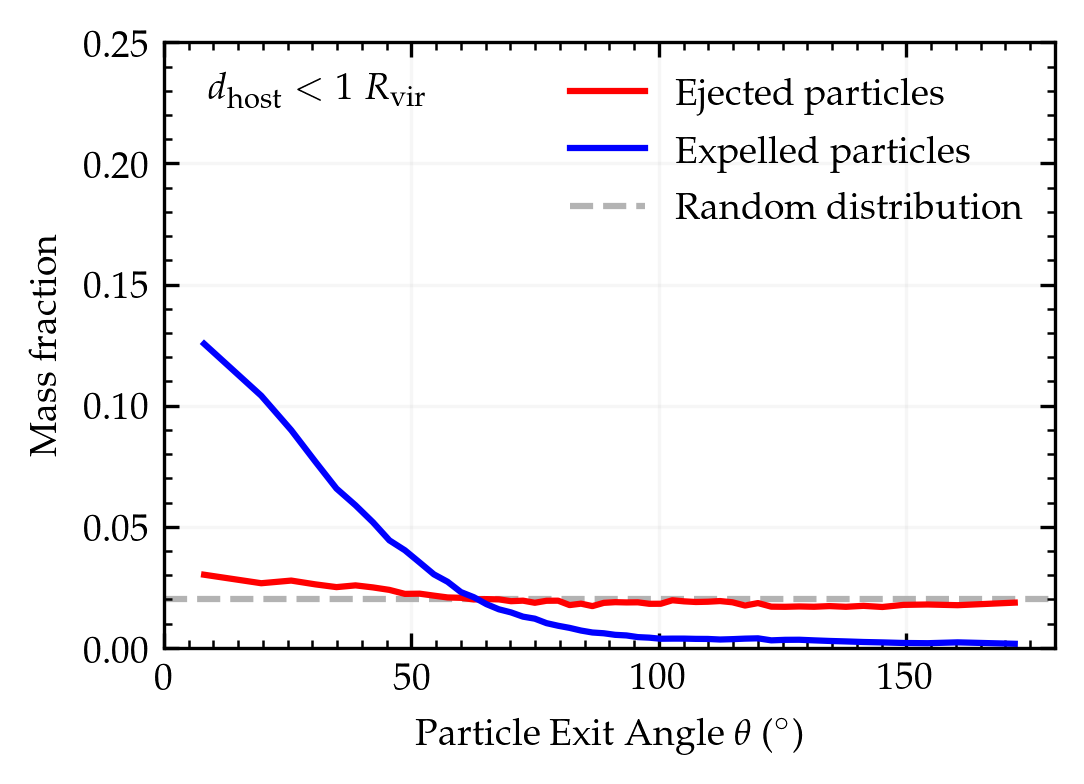

In [56]:
sat_pos = np.array([np.array(ejected.sat_Xc), np.array(ejected.sat_Yc), np.array(ejected.sat_Zc)]).T
host_pos = np.array([np.array(ejected.host_Xc), np.array(ejected.host_Yc), np.array(ejected.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag1 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag1 /= np.array(ejected.hostRvir)

sat_pos = np.array([np.array(expelled.sat_Xc), np.array(expelled.sat_Yc), np.array(expelled.sat_Zc)]).T
host_pos = np.array([np.array(expelled.host_Xc), np.array(expelled.host_Yc), np.array(expelled.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag2 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag2 /= np.array(expelled.hostRvir)

fig, ax = plt.subplots(1,1,dpi=300, figsize=(3.5,2.5), constrained_layout=True)

cond = pos_mag1 < 1
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=ejected.mass[cond]/np.sum(ejected.mass[cond]))
ax.plot(bincenters, y1, label='Ejected particles', c='r')

cond = pos_mag2 < 1
y2, bins = np.histogram(expelled.angle[cond], bins=bins, weights=expelled.mass[cond]/np.sum(expelled.mass[cond]))
ax.plot(bincenters, y2, label='Expelled particles', c='b')

# plot the line that represents a random distribution
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='Random distribution')

# add legends
ax.legend(frameon=False)

# labels and ticks and such
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Mass fraction')
ax.set_xlim(0,180)
ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.1, zorder=-1000)
ax.annotate(r'$d_{\rm host} < 1~R_{\rm vir}$', (0.05, 0.95), xycoords='axes fraction', va='top')

plt.savefig('plots/theta_allsats_stacked.pdf')
plt.show()

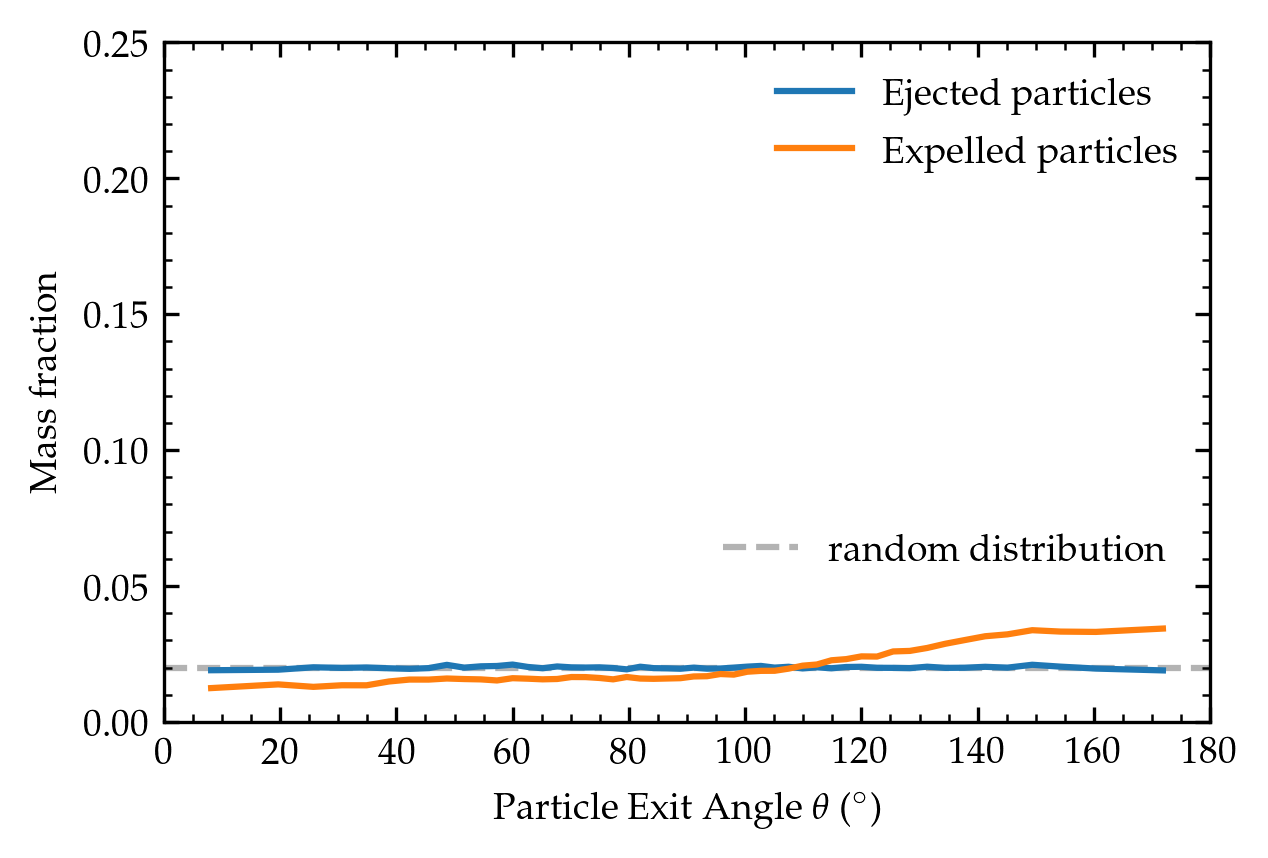

In [57]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3))

y1, bins = np.histogram(ejected.angle_tidal, bins=bins, weights=ejected.weight)
l1 = 'Ejected particles'
p1, = ax.plot(bincenters, y1, label=l1)

y2, bins = np.histogram(expelled.angle_tidal, bins=bins, weights=expelled.weight)
l2 = 'Expelled particles'
p2, = ax.plot(bincenters, y2, label=l2)

# plot the line that represents a random distribution
percent = 1/N
p3, = ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)

# add legends
leg1 = ax.legend([p1,p2],[l1,l2], frameon=False)
leg1._legend_box.align = 'right'
leg2 = ax.legend([p3],['random distribution'], frameon=False, loc=(0.52,0.2))
ax.add_artist(leg1)

# labels and ticks and such
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Mass fraction')
ax.set_xlim(0,180)
ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.show()

This plot provides clear evidence that ram pressure stripping is active in removing gas from the halo, but less so at removing gas from the disk. 

Since we categorize disk gas thermodynamically as well, we can break this down into gas ejected from the cool disk and gas ejected from the hot disk.


In [3]:
path = '../../Data/ejected_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = hdf.keys()
    print(*keys)
    
ejected, expelled, accreted = read_all_ejected_expelled_accreted()

/h148_13 /h148_14 /h148_28 /h148_3 /h148_37 /h148_68 /h229_20 /h229_22 /h229_27 /h242_12 /h242_24 /h242_41 /h242_80 /h329_11 /h329_33
h148_13 h148_14 h148_28 h148_3 h148_37 h148_68 h229_20 h229_22 h229_27 h242_12 h242_24 h242_41 h242_80 h329_11 h329_33
Returning (ejected, expelled, accreted) for all available satellites...


In [4]:
N = 50 # more bins than Bahé et al since we have lots of particles
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

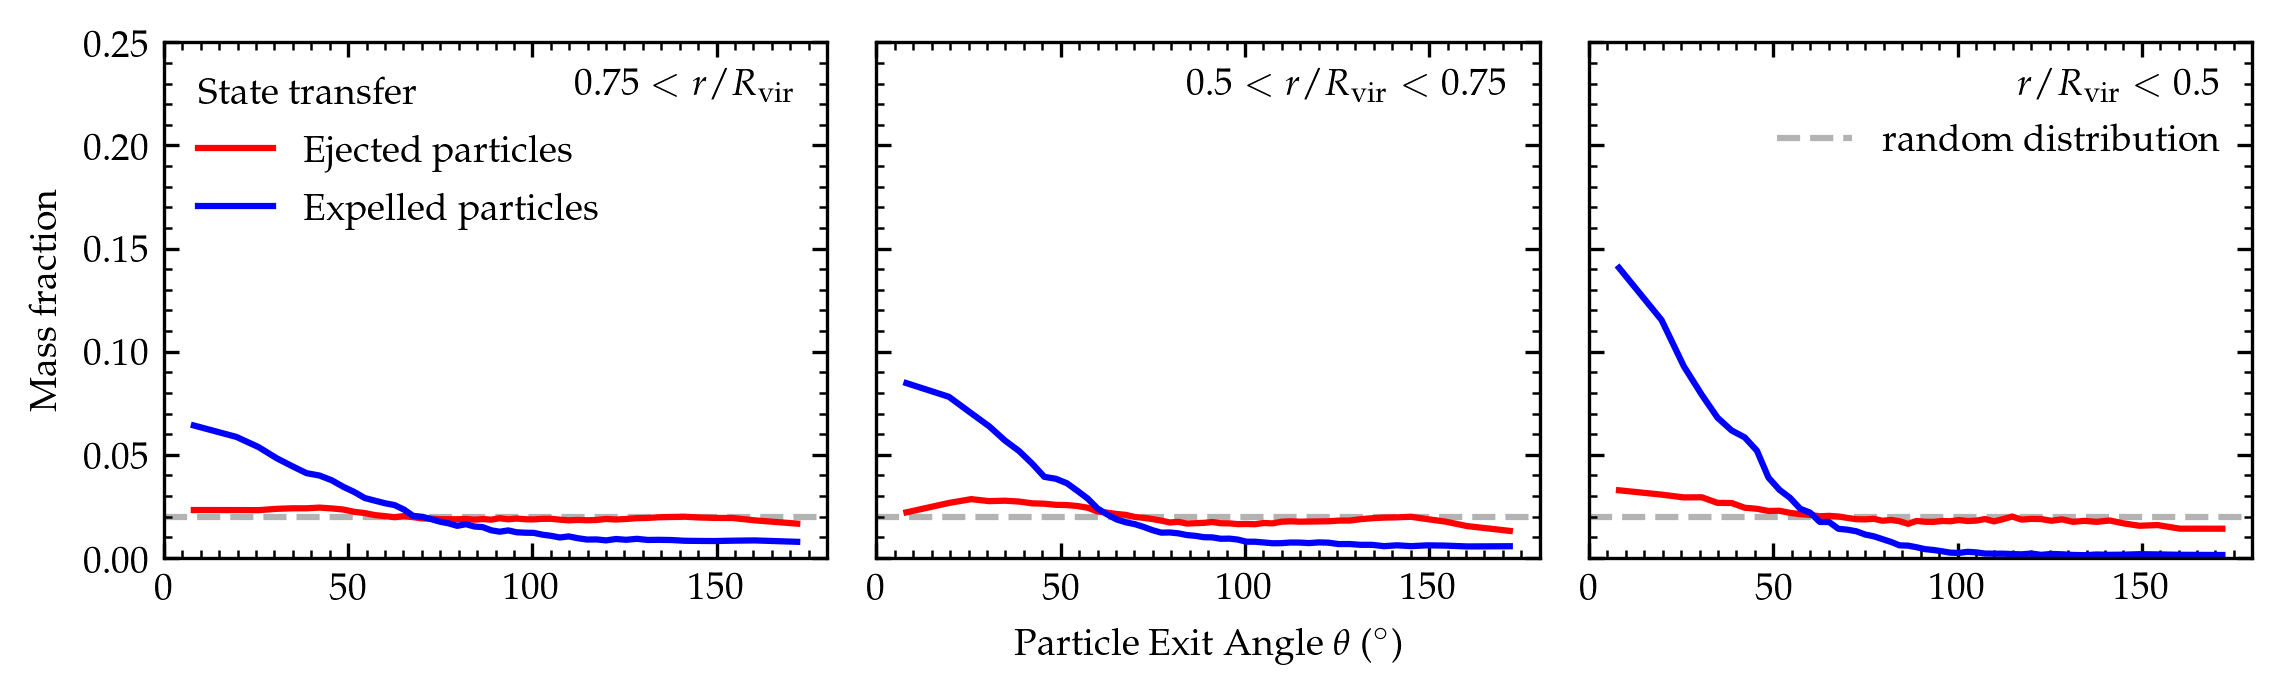

In [5]:
sat_pos = np.array([np.array(ejected.sat_Xc), np.array(ejected.sat_Yc), np.array(ejected.sat_Zc)]).T
host_pos = np.array([np.array(ejected.host_Xc), np.array(ejected.host_Yc), np.array(ejected.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag1 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag1 /= np.array(ejected.hostRvir)

sat_pos = np.array([np.array(expelled.sat_Xc), np.array(expelled.sat_Yc), np.array(expelled.sat_Zc)]).T
host_pos = np.array([np.array(expelled.host_Xc), np.array(expelled.host_Yc), np.array(expelled.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag2 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag2 /= np.array(expelled.hostRvir)


fig,ax = plt.subplots(1,3, dpi=300, figsize=(7.5,2.2), sharey=True, constrained_layout=True)

# leftmost ax will be r > 0.75
ax[0].annotate(r'$0.75 < r/R_{\rm vir}$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = pos_mag1 >= 0.75
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=ejected.mass[cond]/np.sum(ejected.mass[cond]))
l1 = r'Ejected particles'
ax[0].plot(bincenters, y1, label=l1, color='r')

cond = pos_mag2 > 0.75
y2, bins = np.histogram(expelled.angle[cond], bins=bins, weights=expelled.mass[cond]/np.sum(expelled.mass[cond]))
l2 = r'Expelled particles'
ax[0].plot(bincenters, y2, label=l2, color='b')


# middle ax will be 0.5 < r < 0.75
ax[1].annotate(r'$0.5 < r/R_{\rm vir} < 0.75$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = (pos_mag1 >= 0.5) & (pos_mag1 < 0.75)
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=ejected.mass[cond]/np.sum(ejected.mass[cond]))
ax[1].plot(bincenters, y1, color='r')

cond = (pos_mag2 >= 0.5) & (pos_mag2 < 0.75)
y2, bins = np.histogram(expelled.angle[cond], bins=bins, weights=expelled.mass[cond]/np.sum(expelled.mass[cond]))
ax[1].plot(bincenters, y2, color='b')


# rightmost ax will be r < 0.5
ax[2].annotate(r'$r/R_{\rm vir} < 0.5$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = pos_mag1 < 0.5
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=ejected.mass[cond]/np.sum(ejected.mass[cond]))
ax[2].plot(bincenters, y1, color='r')

cond = pos_mag2 < 0.5
y2, bins = np.histogram(expelled.angle[cond], bins=bins, weights=expelled.mass[cond]/np.sum(expelled.mass[cond]))
ax[2].plot(bincenters, y2, color='b')


# plot the line that represents a random distribution
percent = 1/N
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[2].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='random distribution')

# add legends
leg1 = ax[0].legend(title=r'State transfer', frameon=False, loc='upper left')
leg1._legend_box.align = 'left'
ax[2].legend(frameon=False, loc=(0.26,0.74))

# labels and ticks and such
ax[1].set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax[0].set_ylabel('Mass fraction')
for a in ax:
    a.set_xlim(0,180)
    a.set_ylim(0,0.25)

    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
    a.tick_params(direction='in',which='both',right=True,top=True)

# plt.savefig('plots/theta_allsats_byR.pdf')
plt.show()

In [95]:
keys_sample = ['h148_13','h148_28','h148_37','h148_45','h148_68','h148_80','h148_283','h148_278','h148_329','h229_20',
               'h229_22','h229_23','h229_27','h229_55','h242_24','h242_41','h242_80','h329_33','h329_137']
print(len(keys_sample))

19


# Grid plot of exit angle as a function of Pram and Prest

First load in the ejected, expelled datasets

In [2]:
keys_sample = ['h148_13','h148_28','h148_37','h148_45','h148_68','h148_80','h148_283','h148_278','h148_329','h229_20',
               'h229_22','h229_23','h229_27','h229_55','h242_24','h242_41','h242_80','h329_33','h329_137']

ejected, cooled, expelled, accreted = read_all_ejected_expelled()
ejected = ejected[np.isin(ejected.key, keys_sample)]
expelled = expelled[np.isin(expelled.key, keys_sample)]

h148_13 h148_14 h148_278 h148_28 h148_283 h148_3 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_12 h242_24 h242_41 h242_80 h329_11 h329_137 h329_33
Returning (ejected, cooled, expelled, accreted) for all available satellites...


In [3]:
ejected.head()

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,angle,key,angle_tidal
0,11.214915,2202002,0.000120,53035.859375,28366.376150,10.908183,6.698204,0.121201,0.612335,-0.205156,...,19.203362,False,True,False,False,False,False,134.055296,h148_13,NaN
0,12.507856,2202002,0.000027,16609.818359,29001.936444,12.388833,8.954684,0.148129,8.203483,-3.552072,...,17.758932,False,True,False,False,False,False,46.365776,h148_13,NaN
2,9.921974,2857672,0.000126,58067.246094,27134.726367,9.669960,7.982986,0.155638,-0.130506,7.981885,...,20.680841,False,True,False,False,False,False,95.014185,h148_13,NaN
4,10.767100,4073949,0.058975,9752.045898,26835.758536,0.000000,0.849211,0.015786,-0.681446,-0.438338,...,20.143633,False,True,False,False,False,False,12.792650,h148_13,NaN
4,11.214915,4073949,0.000031,54464.347656,26965.973341,11.058858,11.656469,0.210918,-5.592503,8.339077,...,19.203362,False,True,False,False,False,False,53.294073,h148_13,NaN


In [4]:
N = 50 # more bins than Bahé et al since we have lots of particles
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

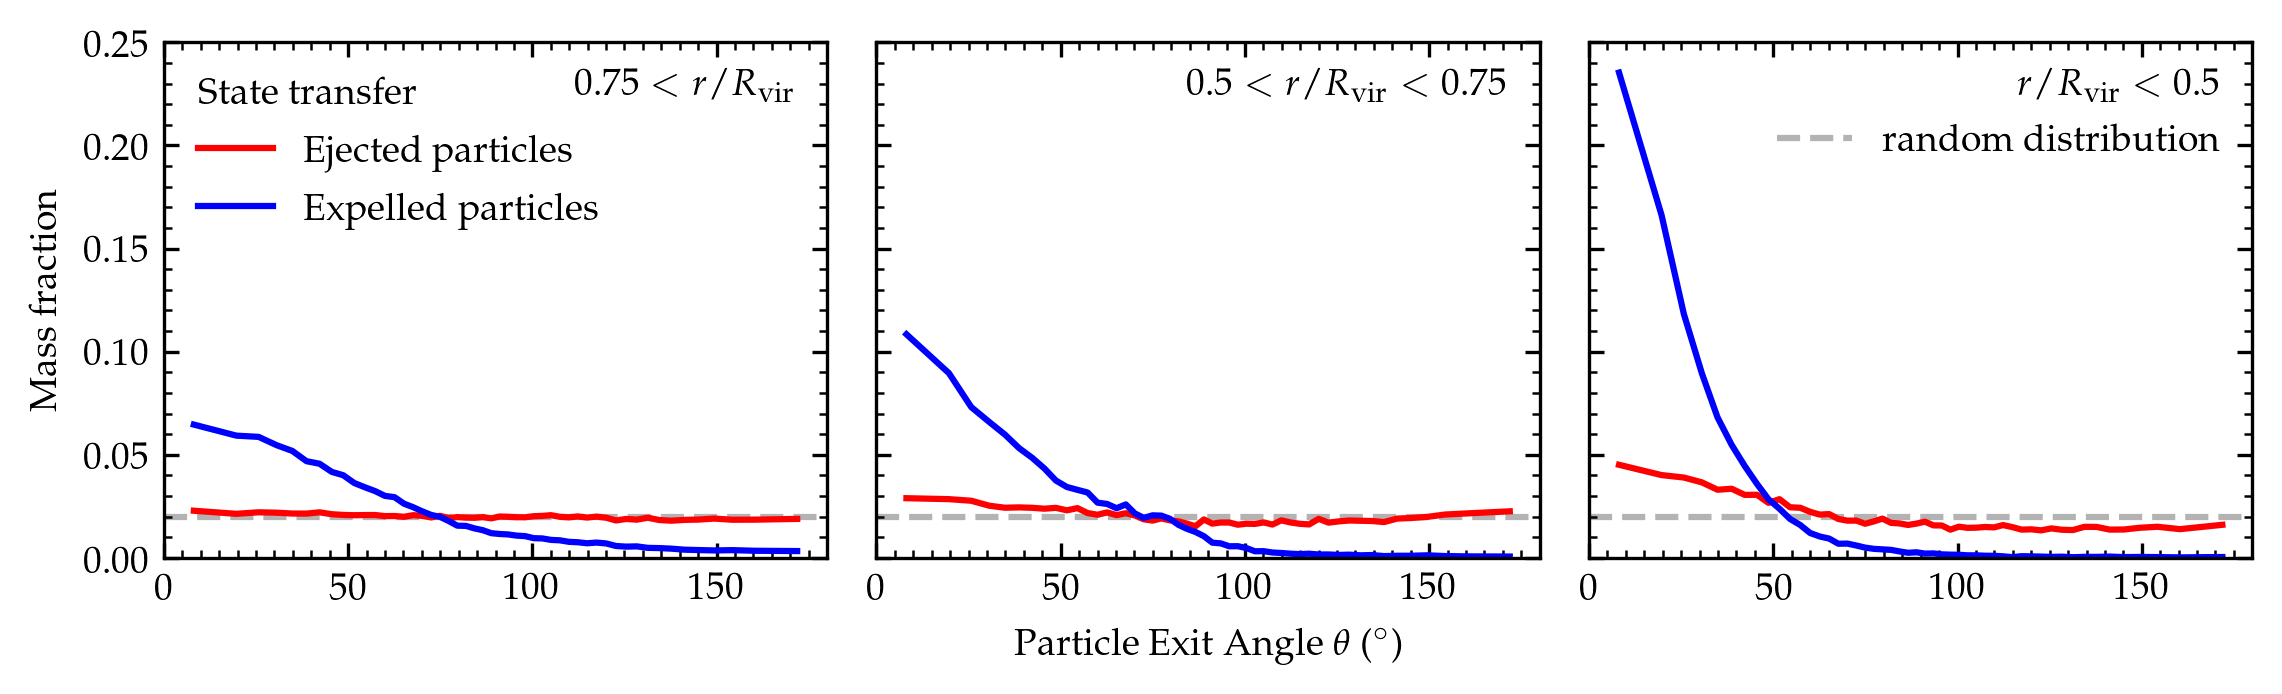

In [5]:
sat_pos = np.array([np.array(ejected.sat_Xc), np.array(ejected.sat_Yc), np.array(ejected.sat_Zc)]).T
host_pos = np.array([np.array(ejected.host_Xc), np.array(ejected.host_Yc), np.array(ejected.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag1 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag1 /= np.array(ejected.hostRvir)

sat_pos = np.array([np.array(expelled.sat_Xc), np.array(expelled.sat_Yc), np.array(expelled.sat_Zc)]).T
host_pos = np.array([np.array(expelled.host_Xc), np.array(expelled.host_Yc), np.array(expelled.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag2 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag2 /= np.array(expelled.hostRvir)


fig,ax = plt.subplots(1,3, dpi=300, figsize=(7.5,2.2), sharey=True, constrained_layout=True)

# leftmost ax will be r > 0.75
ax[0].annotate(r'$0.75 < r/R_{\rm vir}$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = pos_mag1 >= 0.75
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=ejected.mass[cond]/np.sum(ejected.mass[cond]))
l1 = r'Ejected particles'
ax[0].plot(bincenters, y1, label=l1, color='r')

cond = pos_mag2 > 0.75
y2, bins = np.histogram(expelled.angle[cond], bins=bins, weights=expelled.mass[cond]/np.sum(expelled.mass[cond]))
l2 = r'Expelled particles'
ax[0].plot(bincenters, y2, label=l2, color='b')


# middle ax will be 0.5 < r < 0.75
ax[1].annotate(r'$0.5 < r/R_{\rm vir} < 0.75$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = (pos_mag1 >= 0.5) & (pos_mag1 < 0.75)
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=ejected.mass[cond]/np.sum(ejected.mass[cond]))
ax[1].plot(bincenters, y1, color='r')

cond = (pos_mag2 >= 0.5) & (pos_mag2 < 0.75)
y2, bins = np.histogram(expelled.angle[cond], bins=bins, weights=expelled.mass[cond]/np.sum(expelled.mass[cond]))
ax[1].plot(bincenters, y2, color='b')


# rightmost ax will be r < 0.5
ax[2].annotate(r'$r/R_{\rm vir} < 0.5$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = pos_mag1 < 0.5
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=ejected.mass[cond]/np.sum(ejected.mass[cond]))
ax[2].plot(bincenters, y1, color='r')

cond = pos_mag2 < 0.5
y2, bins = np.histogram(expelled.angle[cond], bins=bins, weights=expelled.mass[cond]/np.sum(expelled.mass[cond]))
ax[2].plot(bincenters, y2, color='b')


# plot the line that represents a random distribution
percent = 1/N
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[2].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='random distribution')

# add legends
leg1 = ax[0].legend(title=r'State transfer', frameon=False, loc='upper left')
leg1._legend_box.align = 'left'
ax[2].legend(frameon=False, loc=(0.26,0.74))

# labels and ticks and such
ax[1].set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax[0].set_ylabel('Mass fraction')
for a in ax:
    a.set_xlim(0,180)
    a.set_ylim(0,0.25)

    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
    a.tick_params(direction='in',which='both',right=True,top=True)

# plt.savefig('plots/theta_allsats_byR.pdf')
plt.show()

Next, load in the ram pressure dataset and group all keys into one dataframe. 

In [6]:
path = '../../Data/ram_pressure.hdf5'
ram_pressure = pd.DataFrame()

with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

for key in keys:
    d = pd.read_hdf(path, key=key)
    d['key'] = key
    ram_pressure = pd.concat([ram_pressure, d])
    
ram_pressure.head()

,t,a,h1dist,dNN,M_star,M_gas,satRvir,hostRvir,vel_CGM,rho_CGM,...,rho_CGM_adv,std_vel_CGM,std_rho_CGM,Pram_adv,Prest,SigmaGas,dphidz,SFR,sSFR,key
0,6.474131,0.537186,423.531296,178.684714,100847839.53591666,314970038.6902275,42.360119,177.866525,184.559286,218.474060,...,458.98931660712736,7.983066,209.16724495036166,194286.52639588623,70906067.03846446,170201.660478939,416.600325,0.006685,6.62895e-11,h148_13
0,6.905111,0.563402,361.437487,178.728207,101175469.43702735,308855984.29167813,44.759939,188.949459,202.219302,259.355120,...,662.0364104629074,18.996878,297.001715177182,467552.32845517993,60500181.96811111,142372.95083385304,424.941547,0.006486,6.41029e-11,h148_13
0,7.039793,0.571574,340.566235,178.166036,101182058.5286643,301198403.8916383,45.468217,192.398621,208.994033,333.859921,...,795.3245987113976,21.531193,361.24019217524454,815914.7954962957,65630573.398863465,156325.7031222481,419.832261,0.002601,2.57041e-11,h148_13
0,7.336092,0.589531,292.055470,175.412003,101457993.92692062,277943421.0439347,47.157674,200.539727,225.969959,852.895770,...,1156.5488973193503,43.748361,617.7729346214282,4437030.714881859,89306071.6931496,213625.2056783062,418.050255,0.004567,4.50179e-11,h148_13
0,7.767072,0.615628,213.638074,164.678961,101922259.70865524,159423887.21248782,49.372360,218.455662,251.073050,1511.600202,...,2865.357386220595,20.478919,3021.5777796497846,144504078.89391506,2095343647.2374294,5096302.225314851,411.149801,0.004102,4.02489e-11,h148_13


In [7]:
ejected_merged = pd.merge(ejected, ram_pressure, right_on=['key','t'], left_on=['key', 'time'])
expelled_merged = pd.merge(expelled, ram_pressure, right_on=['key','t'], left_on=['key', 'time'])
ejected_merged.head()

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,vel_CGM_adv,rho_CGM_adv,std_vel_CGM,std_rho_CGM,Pram_adv,Prest,SigmaGas,dphidz,SFR,sSFR
0,11.214915,2202002,0.000120,53035.859375,28366.376150,10.908183,6.698204,0.121201,0.612335,-0.205156,...,124.610592,246.68217868089573,42.452535,49.755209695975466,3830431.4305241746,374843370.8148858,1073300.623286654,349.243597,0.000466,4.46537e-12
1,11.214915,4073949,0.000031,54464.347656,26965.973341,11.058858,11.656469,0.210918,-5.592503,8.339077,...,124.610592,246.68217868089573,42.452535,49.755209695975466,3830431.4305241746,374843370.8148858,1073300.623286654,349.243597,0.000466,4.46537e-12
2,11.214915,4340176,0.001112,14165.883789,27285.939882,10.685118,3.025277,0.054741,-2.653128,-0.498549,...,124.610592,246.68217868089573,42.452535,49.755209695975466,3830431.4305241746,374843370.8148858,1073300.623286654,349.243597,0.000466,4.46537e-12
3,11.214915,5212688,0.018649,9826.400391,27174.549484,0.000000,1.021319,0.018480,0.204697,0.741898,...,124.610592,246.68217868089573,42.452535,49.755209695975466,3830431.4305241746,374843370.8148858,1073300.623286654,349.243597,0.000466,4.46537e-12
4,11.214915,6988228,0.208150,17343.492188,26798.731448,11.038656,0.824147,0.014913,-0.238316,0.661909,...,124.610592,246.68217868089573,42.452535,49.755209695975466,3830431.4305241746,374843370.8148858,1073300.623286654,349.243597,0.000466,4.46537e-12


In [8]:
P_rest_ej = np.array(ejected_merged.Prest,dtype=float)
P_ram_ej = np.array(ejected_merged.Pram_adv,dtype=float)
P_rest_ex = np.array(expelled_merged.Prest,dtype=float)
P_ram_ex = np.array(expelled_merged.Pram_adv,dtype=float)

ratio_ej = P_ram_ej/P_rest_ej
ratio_ex = P_ram_ex/P_rest_ex

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [18]:
def plot_panel(N, ax, ejected, expelled, label=False):
    theta1,theta2 = 0,0 # initialize
    bins = np.array([theta1]) 
    while theta2 < 3.14:
        theta2 = np.arccos(np.cos(theta1)-(2/N))
        bins = np.append(bins,theta2)
        theta1 = theta2

    bins = bins*180/np.pi
    bincenters = 0.5*(bins[1:]+bins[:-1])

    if label:
        l = r'Ejected particles'
    else:
        l = None
    
    y1, bins = np.histogram(ejected.angle, bins=bins, weights=ejected.mass/np.sum(ejected.mass))
    ax.plot(bincenters, y1, label=l, color='r')

    if label:
        l = r'Expelled (from halo)'
    else:
        l = None
    
    e = expelled[expelled.state1=='sat_halo']
    y2, bins = np.histogram(e.angle, bins=bins, weights=e.mass/np.sum(e.mass))
    ax.plot(bincenters, y2, label=l, color='b')
    
    
    if label:
        l = r'Expelled (from disk)'
    else:
        l = None
    
    e = expelled[expelled.state1=='sat_disk']
    y3, bins = np.histogram(e.angle, bins=bins, weights=e.mass/np.sum(e.mass))
    ax.plot(bincenters, y3, label=l, color='b', linestyle='--')
    
    
    print('ejected',len(ejected),len(np.unique(ejected.key)))
    print('expelled',len(expelled),len(np.unique(expelled.key)))
    #ax.annotate(r'$N_{\rm ej} =$'+f'{len(ejected)}', (0.95, 0.95), xycoords='axes fraction', va='top', ha='right')
    #ax.annotate(r'$N_{\rm ex} =$'+f'{len(expelled)}', (0.95, 0.85), xycoords='axes fraction', va='top', ha='right')


ejected 36349 12
expelled 30057 13
ejected 54177 18
expelled 67835 18
ejected 24869 14
expelled 43009 15
ejected 4147 8
expelled 16639 14


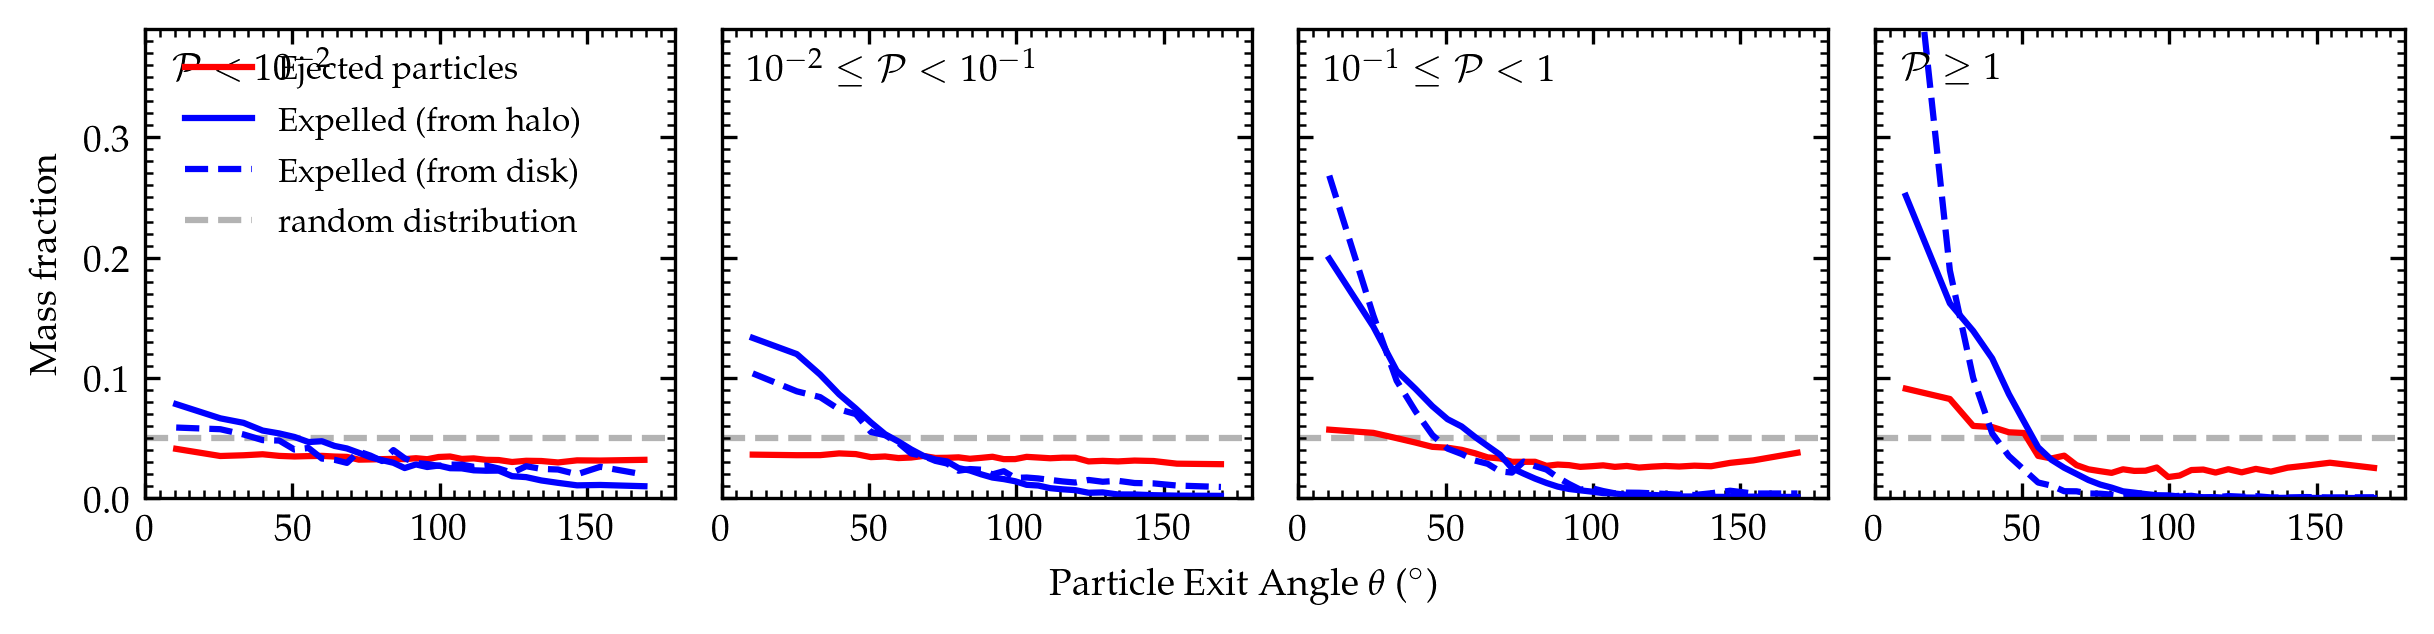

In [19]:
fig,ax = plt.subplots(1,4, dpi=300, figsize=(8,2), sharey=True, constrained_layout=True)


cond_ej = ratio_ej < 1e-2
cond_ex = ratio_ex < 1e-2 
plot_panel(N, ax[0], ejected_merged[cond_ej], expelled_merged[cond_ex], label=True)
ax[0].annotate(r'$\mathcal{P} < 10^{-2}$', (0.05,0.95),xycoords='axes fraction',ha='left', va='top')


cond_ej = (ratio_ej >= 1e-2) & (ratio_ej < 1e-1)
cond_ex = (ratio_ex >= 1e-2) & (ratio_ex < 1e-1)
plot_panel(N, ax[1], ejected_merged[cond_ej], expelled_merged[cond_ex])
ax[1].annotate(r'$10^{-2} \leq \mathcal{P} < 10^{-1}$',(0.05,0.95),xycoords='axes fraction',ha='left', va='top')


cond_ej = (ratio_ej >= 1e-1) & (ratio_ej < 1)
cond_ex = (ratio_ex >= 1e-1) & (ratio_ex < 1)
plot_panel(N, ax[2], ejected_merged[cond_ej], expelled_merged[cond_ex])
ax[2].annotate(r'$10^{-1} \leq \mathcal{P} < 1$',(0.05,0.95),xycoords='axes fraction',ha='left', va='top')

cond_ej = ratio_ej >= 1
cond_ex = ratio_ex >= 1
plot_panel(N, ax[3], ejected_merged[cond_ej], expelled_merged[cond_ex])
ax[3].annotate(r'$\mathcal{P} \geq 1$',(0.05,0.95),xycoords='axes fraction',ha='left', va='top')


# plot the line that represents a random distribution
percent = 1/20
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='random distribution')
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[2].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[3].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)

# add legends
leg1 = ax[0].legend(frameon=False, loc=(0.05, 0.52), fontsize=8)

# labels and ticks and such
fig.add_subplot(111, frameon=False)
ax[1].set_xlabel('.', color=(0, 0, 0, 0))
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax[0].set_ylabel('Mass fraction')

for a in ax:
    a.set_xlim(0,180)
    a.set_ylim(0,0.39)

    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
    a.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('plots/theta_allsats_by_ratio.pdf')
plt.show()

ejected 119542 18
expelled 157540 18
ejected 36349 12
expelled 30057 13
ejected 54177 18
expelled 67835 18
ejected 24869 14
expelled 43009 15
ejected 4147 8
expelled 16639 14


/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator


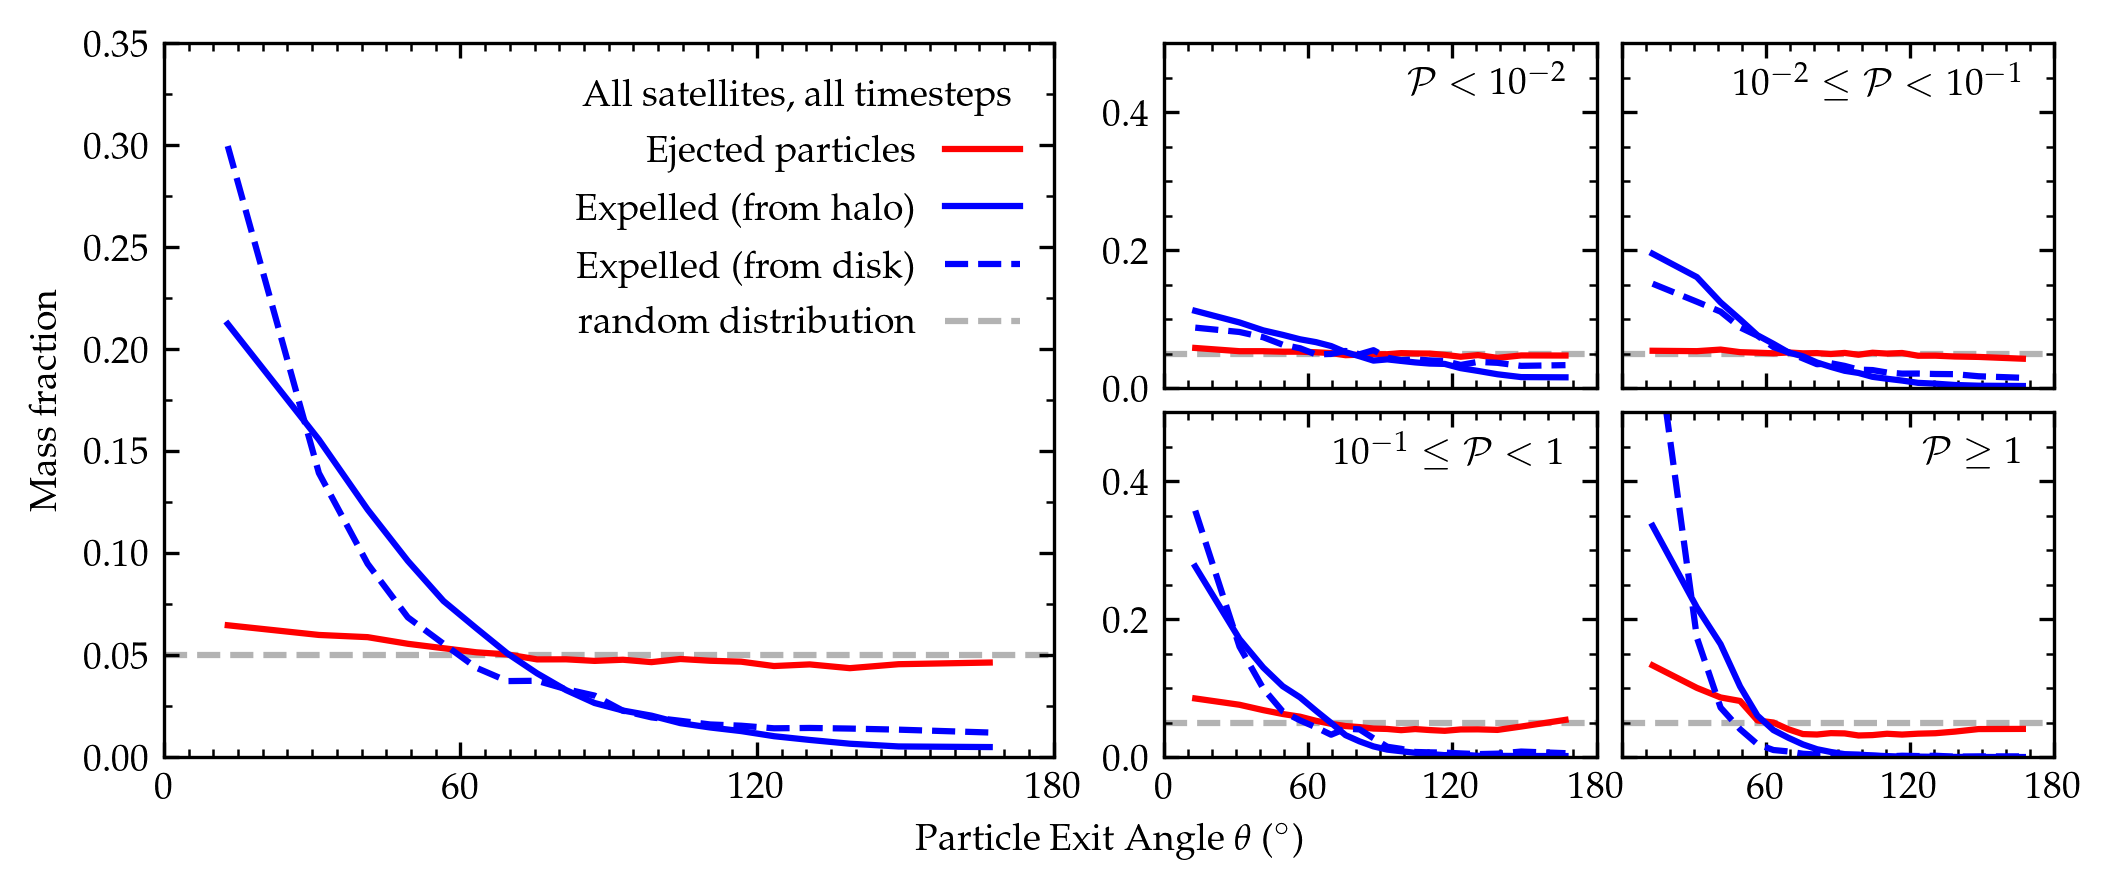

In [30]:
fig = plt.figure(dpi=300, figsize=(7,2.8))
gs = mpl.gridspec.GridSpec(nrows=2, ncols=5, width_ratios = [1,1,0.14,1,1])
gs.update(hspace=0.07, wspace=0.07, top=0.98, right=0.98, left=0.08, bottom=0.13)
ax0 = plt.subplot(gs[:,:2])
ax_buffer = plt.subplot(gs[:,2])
ax1 = plt.subplot(gs[0, 3])
ax2 = plt.subplot(gs[0, 4])
ax3 = plt.subplot(gs[1, 3])
ax4 = plt.subplot(gs[1, 4])

ax_buffer.axis('off')

N = 20

plot_panel(N, ax0, ejected_merged, expelled_merged, label=True)
# ax0.annotate(r'All satellites, all timesteps', (0.05,0.95),xycoords='axes fraction',ha='left', va='top')

cond_ej = ratio_ej < 1e-2
cond_ex = ratio_ex < 1e-2 
plot_panel(N, ax1, ejected_merged[cond_ej], expelled_merged[cond_ex], label=True)
ax1.annotate(r'$\mathcal{P} < 10^{-2}$', (0.93,0.93),xycoords='axes fraction',ha='right', va='top')
ax1.tick_params(labelbottom=False)

cond_ej = (ratio_ej >= 1e-2) & (ratio_ej < 1e-1)
cond_ex = (ratio_ex >= 1e-2) & (ratio_ex < 1e-1)
plot_panel(N, ax2, ejected_merged[cond_ej], expelled_merged[cond_ex])
ax2.annotate(r'$10^{-2} \leq \mathcal{P} < 10^{-1}$',(0.93,0.93),xycoords='axes fraction',ha='right', va='top')
ax2.tick_params(labelleft=False, labelbottom=False)

cond_ej = (ratio_ej >= 1e-1) & (ratio_ej < 1)
cond_ex = (ratio_ex >= 1e-1) & (ratio_ex < 1)
plot_panel(N, ax3, ejected_merged[cond_ej], expelled_merged[cond_ex])
ax3.annotate(r'$10^{-1} \leq \mathcal{P} < 1$',(0.93,0.93),xycoords='axes fraction',ha='right', va='top')

cond_ej = ratio_ej >= 1
cond_ex = ratio_ex >= 1
plot_panel(N, ax4, ejected_merged[cond_ej], expelled_merged[cond_ex])
ax4.annotate(r'$\mathcal{P} \geq 1$',(0.93,0.93),xycoords='axes fraction',ha='right', va='top')
ax4.tick_params(labelleft=False)


# plot the line that represents a random distribution
percent = 1/N
ax0.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='random distribution')
ax1.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax2.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax3.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax4.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)

# add legends
leg = ax0.legend(frameon=False, loc='upper right', title='All satellites, all timesteps')
vp = leg._legend_box._children[-1]._children[0]
for c in vp._children:
    c._children.reverse()
vp.align="right" 


# labels and ticks and such
ax0.set_xlabel('.', color=(0, 0, 0, 0))
ax0.set_ylabel('Mass fraction')
fig.text(0.53, 0.03, r'Particle Exit Angle $\theta$ ($^\circ$)', ha='center', va='center')

for a in [ax0,ax1,ax2,ax3,ax4]:
    a.set_xlim(0,180)
    a.set_ylim(0,0.5)

    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(60))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    a.tick_params(direction='in',which='both',right=True,top=True)
    
ax4.set_xticklabels([None, None, 60, 120, 180])
ax0.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax0.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.025))
ax0.set_ylim(0, 0.35)

plt.savefig('plots/theta.pdf')
plt.show()

In [39]:
path = '../../Data/ram_pressure.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])
print('Running for keys:', *keys)

def read_timescales():
    '''Function to read in the data file which contains quenching and infall times'''
    data = []
    with open('../../Data/QuenchingTimescales.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

def read_timesteps(sim):
    '''Function to read in the data file which contains quenching and infall times'''
    data = []
    with open(f'../../Data/timesteps_data/{sim}.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

timescales = read_timescales()

data_all = pd.DataFrame()
for key in keys:
    if key=='h242_12' or key=='h148_3': print(f'skipping {key}'); continue;
    sim = key[:4]
    haloid = int(key[5:])

    # load ram pressure data
    data = pd.read_hdf(path, key=key)
    # fix data types
    data['Pram_adv'] = np.array(data.Pram_adv,dtype=float)
    data['Pram'] = np.array(data.Pram,dtype=float)
    data['Prest'] = np.array(data.Prest,dtype=float)
    data['ratio'] = data.Pram_adv / data.Prest
    dt = np.array(data.t)[1:] - np.array(data.t)[:-1]
    dt = np.append(dt[0],dt)
    data['dt'] = dt
    
    ts = timescales[(timescales.sim==sim)&(timescales.haloid==haloid)]
    data['tau'] = ts.tinfall.iloc[0] - ts.tquench.iloc[0]    

    # load ejected/expelled data
    ejected,cooled,expelled,accreted = read_ejected_expelled(sim, haloid)

    Mgas_div = np.array(data.M_gas,dtype=float)
    Mgas_div = np.append(Mgas_div[0], Mgas_div[:-1])
    
    # first, ejected gas
    data = pd.merge_asof(data, ejected.groupby(['time']).mass.sum().reset_index(), left_on='t', right_on='time')
    data = data.rename(columns={'mass':'M_ejected'})
    data['Mdot_ejected'] = data.M_ejected / data.dt
    data['Mdot_ejected_by_Mgas'] = data.Mdot_ejected / Mgas_div

    # next, cooled gas
    data = pd.merge_asof(data, cooled.groupby(['time']).mass.sum().reset_index(), left_on='t', right_on='time')
    data = data.rename(columns={'mass':'M_cooled'})
    data['Mdot_cooled'] = data.M_cooled / data.dt
    data['Mdot_cooled_by_Mgas'] = data.Mdot_cooled / Mgas_div

    # next, expelled gas
    data = pd.merge_asof(data, expelled.groupby(['time']).mass.sum().reset_index(), left_on='t', right_on='time')
    data = data.rename(columns={'mass':'M_expelled'})
    data['Mdot_expelled'] = data.M_expelled / data.dt
    data['Mdot_expelled_by_Mgas'] = data.Mdot_expelled / Mgas_div

    # finally, accreted gas
    data = pd.merge_asof(data, accreted.groupby(['time']).mass.sum().reset_index(), left_on='t', right_on='time')
    data = data.rename(columns={'mass':'M_accreted'})
    data['Mdot_accreted'] = data.M_accreted / data.dt
    data['Mdot_accreted_by_Mgas'] = data.Mdot_accreted / Mgas_div
    
    data['key'] = key
    data_all = pd.concat([data_all,data])    

Running for keys: h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33
Returning (ejected, cooled, expelled, accreted) for h148-13...
Returning (ejected, cooled, expelled, accreted) for h148-278...
Returning (ejected, cooled, expelled, accreted) for h148-28...
Returning (ejected, cooled, expelled, accreted) for h148-283...
Returning (ejected, cooled, expelled, accreted) for h148-329...
Returning (ejected, cooled, expelled, accreted) for h148-37...
Returning (ejected, cooled, expelled, accreted) for h148-45...
Returning (ejected, cooled, expelled, accreted) for h148-68...
Returning (ejected, cooled, expelled, accreted) for h148-80...
Returning (ejected, cooled, expelled, accreted) for h229-20...
Returning (ejected, cooled, expelled, accreted) for h229-22...
Returning (ejected, cooled, expelled, accreted) for h229-23...
Returning (ejected, cooled, expelled, accreted) for h229-27...
Retu

/Users/hollis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


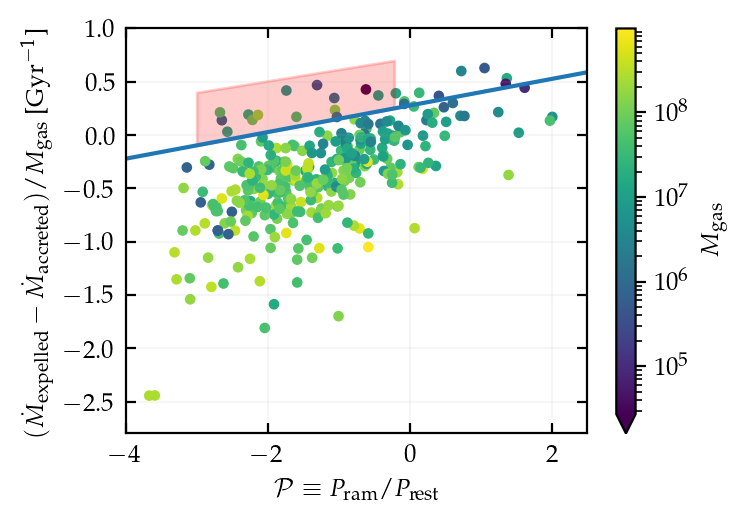

In [40]:
fig, ax = plt.subplots(1,1,dpi=200, figsize=(3.7,2.5))

im = ax.scatter(np.log10(data_all.ratio), np.log10(data_all.Mdot_expelled_by_Mgas-data_all.Mdot_accreted_by_Mgas), s=8, c=data_all.M_gas, norm=mpl.colors.LogNorm())
fig.colorbar(im, ax=ax, label=r'$M_{\rm gas}$', extend='min')
ax.set_xlabel(r'$\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$ ')
ax.set_ylabel(r'$(\dot{M}_{\rm expelled}-\dot{M}_{\rm accreted})/M_{\rm gas}$ [Gyr$^{-1}$]')
# ax.loglog()
ax.set_xlim(-4, 2.5)
ax.set_ylim(-2.8, 1)
ax.plot([1e-4,1e3],[3,3],color='0.85', zorder=-90)
ax.fill_between([1e-4,1e3],[3-1.2,3-1.2],[3+1.2,3+1.2], fc='0.95', zorder=-100)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.grid(alpha=0.1, zorder=-1000)

ax.fill_between([-3, -0.22], [-0.097, 0.25], [0.4, 0.7], color='r', alpha=0.2)
p = np.polyfit([-3, -0.22], [-0.097, 0.25], deg=1)
ax.axline((0,p[1]), slope=p[0])
plt.subplots_adjust(left=0.15, top=0.96, right=0.93, bottom=0.15, hspace=0.05)
# plt.savefig('plots/Pram_expulsion.pdf')
plt.show()

In [41]:
x = np.log10(data_all.ratio)
y = np.log10(data_all.Mdot_expelled_by_Mgas-data_all.Mdot_accreted_by_Mgas)
d = data_all[(x > np.log10(1e-3))&(x < np.log10(6e-1))&(y>(x*p[0]+p[1]))]

In [42]:
ejected, cooled, expelled, accreted = read_all_ejected_expelled()
ejected = ejected[(ejected.key != 'h148_3')&(ejected.key != 'h242_12')]
expelled = expelled[(expelled.key != 'h148_3')&(expelled.key != 'h242_12')]

N = 20 # more bins than Bahé et al since we have lots of particles
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

ejected_new = pd.DataFrame()
expelled_new = pd.DataFrame()
for key, t in zip(d.key, d.t):
    ej = ejected[ejected.key==key]
    ex = expelled[expelled.key==key]
    ej = ej[(ej.time-t)<0.01]
    ex = ex[(ex.time-t)<0.01]
    ejected_new = pd.concat([ejected_new, ej])
    expelled_new = pd.concat([expelled_new, ex])

h148_13 h148_14 h148_278 h148_28 h148_283 h148_3 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_12 h242_24 h242_41 h242_80 h329_11 h329_137 h329_33
Returning (ejected, cooled, expelled, accreted) for all available satellites...


ejected 60138 7
expelled 100931 7


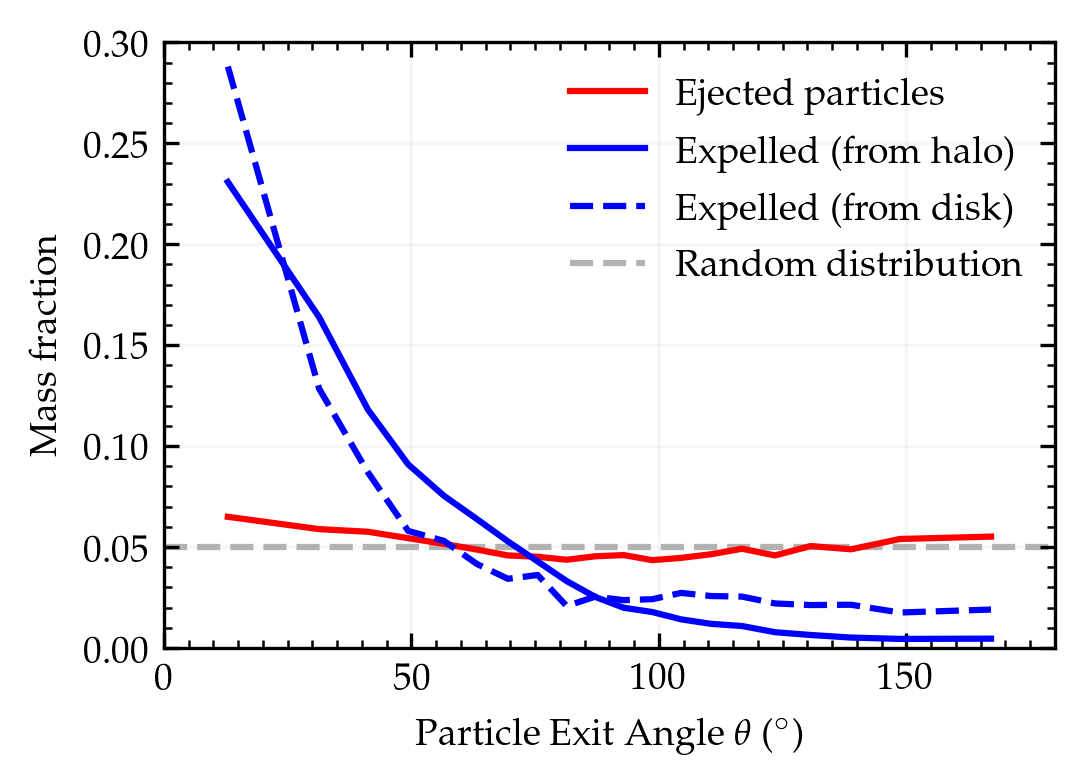

In [43]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(3.5,2.5), constrained_layout=True)

plot_panel(20, ax, ejected_new, expelled_new, label=True)

# y1, bins = np.histogram(ejected_new.angle, bins=bins, weights=ejected_new.mass/np.sum(ejected_new.mass))
# ax.plot(bincenters, y1, label='Ejected particles', c='r')

# y2, bins = np.histogram(expelled_new.angle, bins=bins, weights=expelled_new.mass/np.sum(expelled_new.mass))
# ax.plot(bincenters, y2, label='Expelled particles', c='b')

percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='Random distribution')
ax.legend(frameon=False)
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Mass fraction')
ax.set_xlim(0,180)
ax.set_ylim(0,0.3)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.1, zorder=-1000)
plt.show()

In [ ]:
def calc_massrate(data, bin_results=False, bins=bins):
    time = np.unique(data.time)
    dt = time[1:]-time[:-1]
    dt = np.append(dt[0], dt)
    dt = dt[np.unique(data.time, return_inverse=True)[1]]
    
    data2['massrate'] = np.array(data['mass'])/dt
    
    

In [109]:
ejected_merged.Pram_adv[0]

SimArray(4089951.08894245, 'Msol kpc**-3')

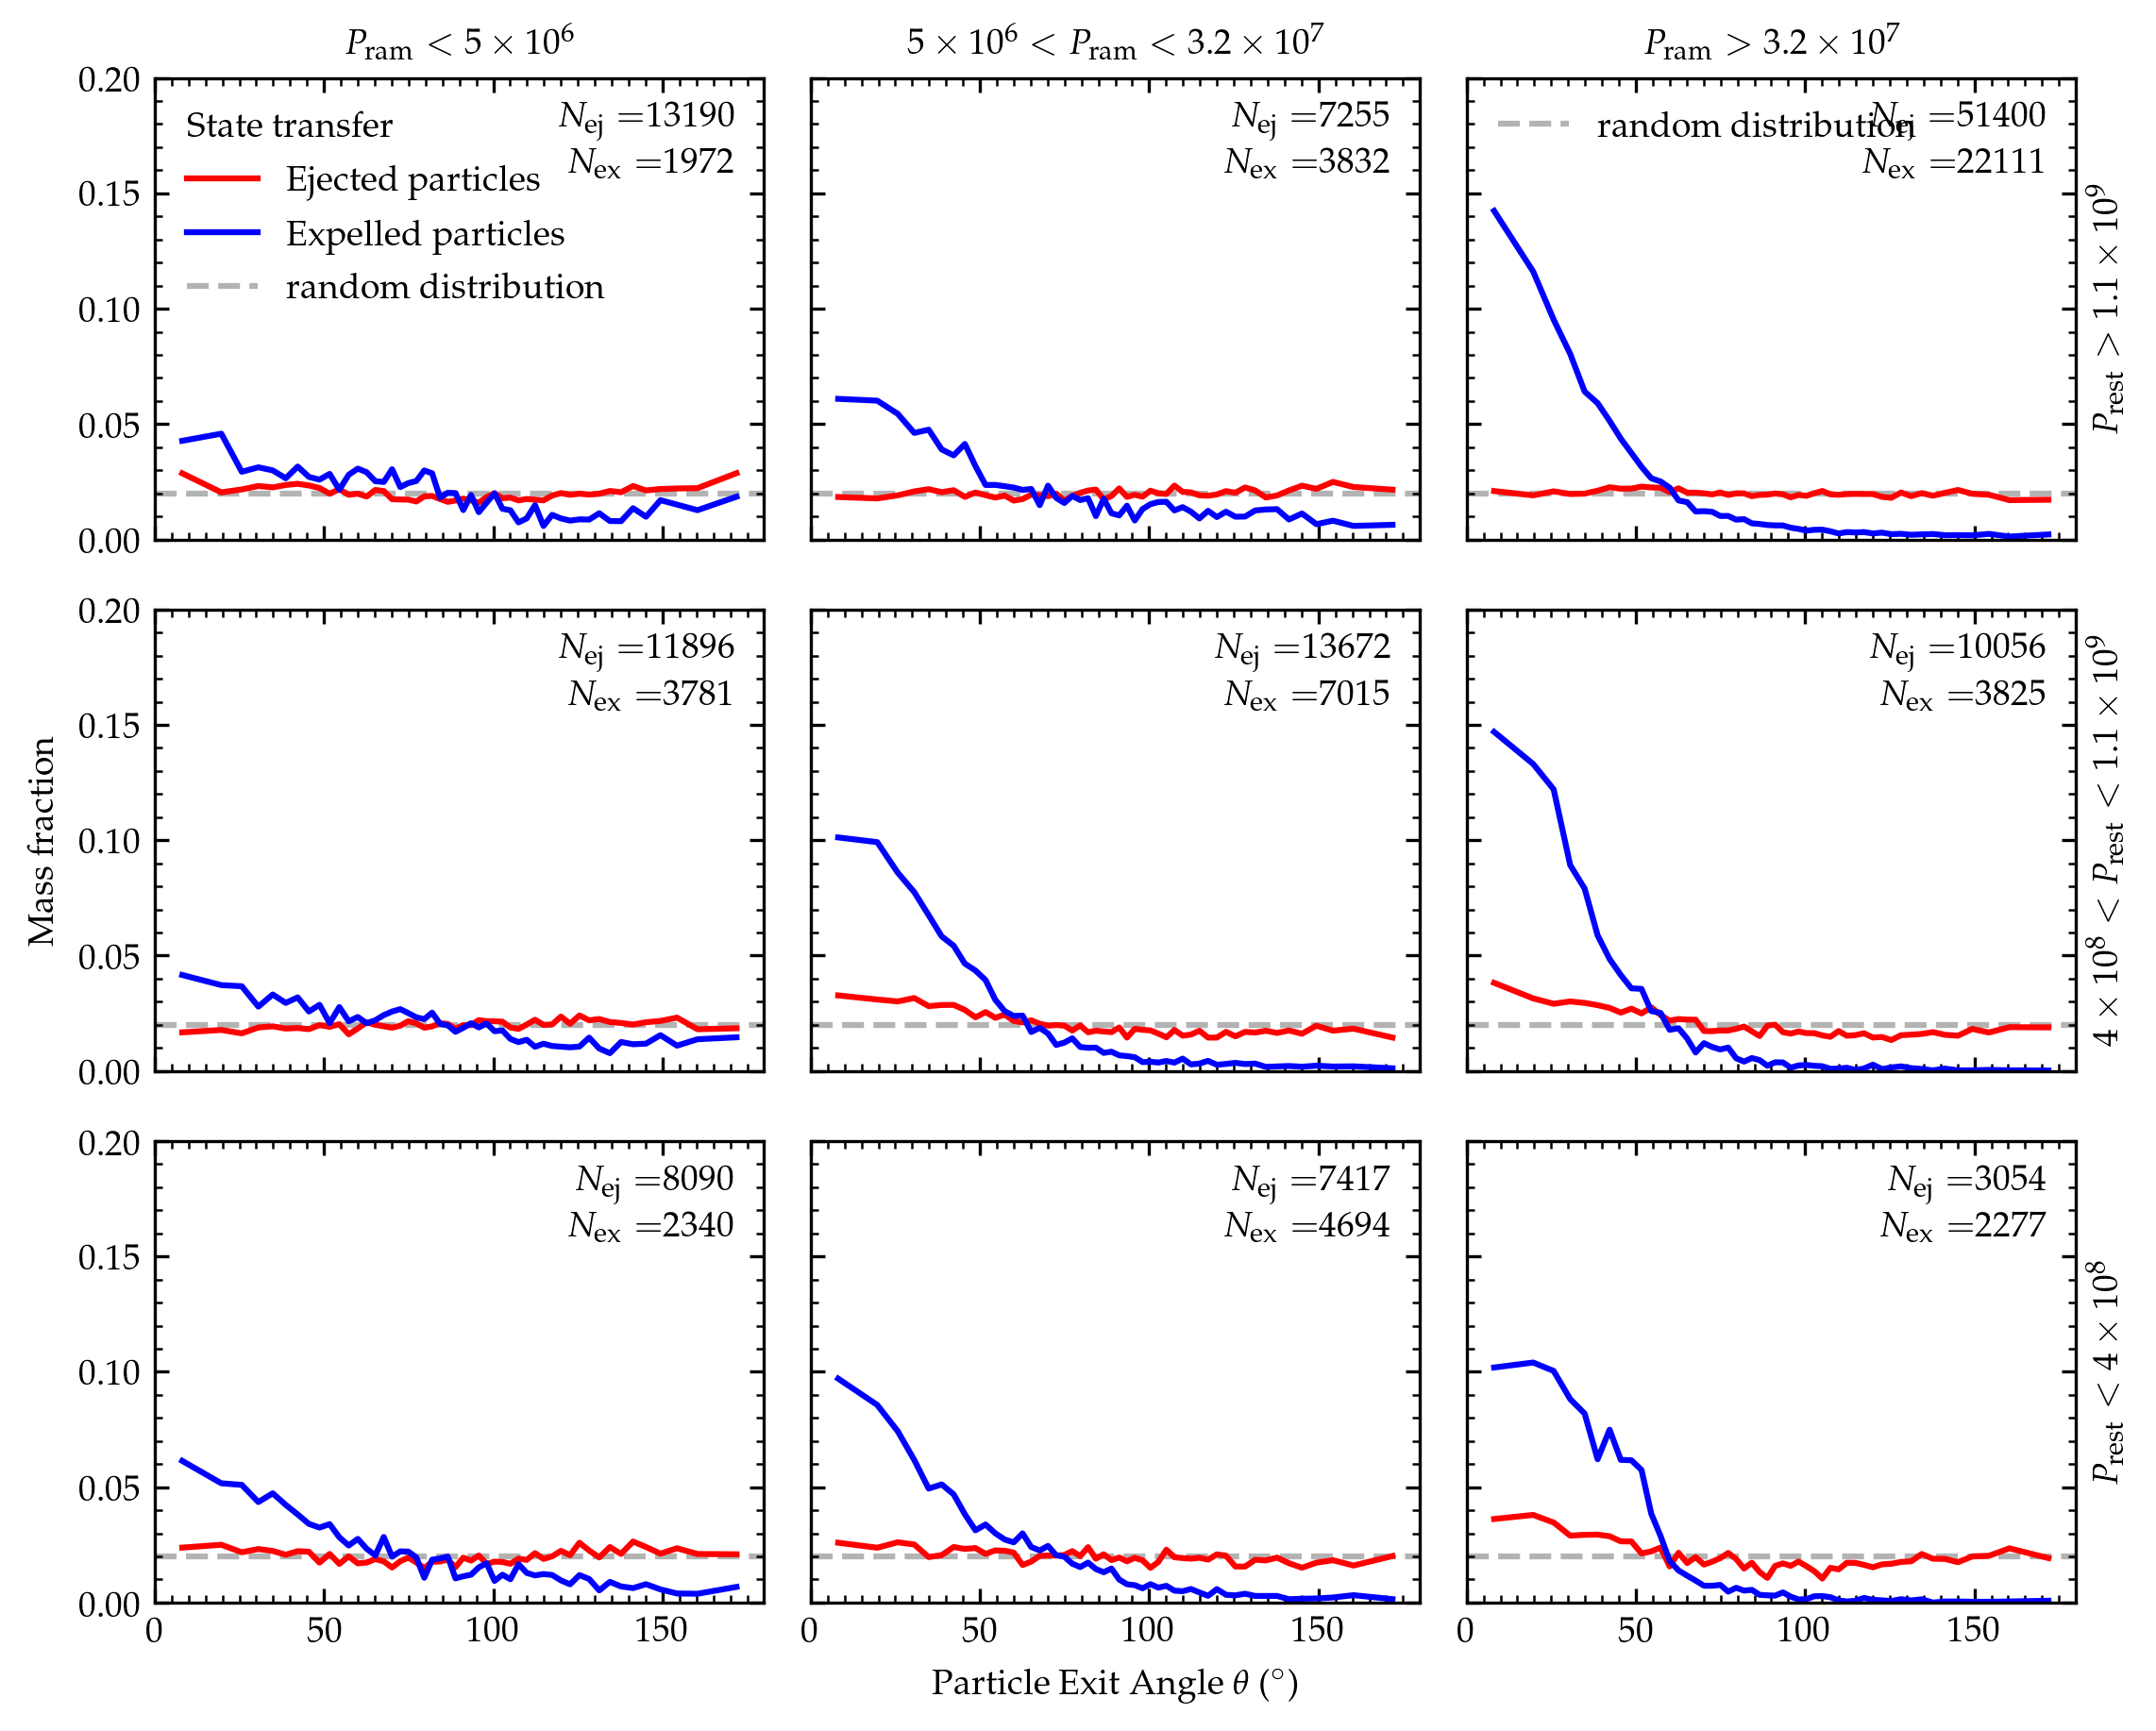

In [122]:
fig, ax = plt.subplots(3,3, dpi=300, figsize=(7.5,6), sharey=True, sharex=True, constrained_layout=True)

P_rest_ej = np.array(ejected_merged.Prest,dtype=float)
P_ram_ej = np.array(ejected_merged.Pram_adv,dtype=float)
P_rest_ex = np.array(expelled_merged.Prest,dtype=float)
P_ram_ex = np.array(expelled_merged.Pram_adv,dtype=float)

# top row
row_cond_ej = P_rest_ej > 1.14e9
row_cond_ex = P_rest_ex > 1.14e9

## left panel
cond_ej = row_cond_ej & (P_ram_ej <= 4.98e6)
cond_ex = row_cond_ex & (P_ram_ex <= 4.98e6)
plot_panel(ax[0,0], ejected_merged[cond_ej], expelled_merged[cond_ex], label=True)

## middle panel
cond_ej = row_cond_ej & (P_ram_ej > 4.98e6) & (P_ram_ej <= 3.2e7)
cond_ex = row_cond_ex & (P_ram_ex > 4.98e6) & (P_ram_ex <= 3.2e7)
plot_panel(ax[0,1], ejected_merged[cond_ej], expelled_merged[cond_ex])

## right panel
cond_ej = row_cond_ej & (P_ram_ej > 3.2e7)
cond_ex = row_cond_ex & (P_ram_ex > 3.2e7)
plot_panel(ax[0,2], ejected_merged[cond_ej], expelled_merged[cond_ex])


# middle row
row_cond_ej = (P_rest_ej > 3.98e8) & (P_rest_ej <= 1.14e9)
row_cond_ex = (P_rest_ex > 3.98e8) & (P_rest_ex <= 1.14e9)

## left panel
cond_ej = row_cond_ej & (P_ram_ej <= 4.98e6)
cond_ex = row_cond_ex & (P_ram_ex <= 4.98e6)
plot_panel(ax[1,0], ejected_merged[cond_ej], expelled_merged[cond_ex], label=True)

## middle panel
cond_ej = row_cond_ej & (P_ram_ej > 4.98e6) & (P_ram_ej <= 3.2e7)
cond_ex = row_cond_ex & (P_ram_ex > 4.98e6) & (P_ram_ex <= 3.2e7)
plot_panel(ax[1,1], ejected_merged[cond_ej], expelled_merged[cond_ex])

## right panel
cond_ej = row_cond_ej & (P_ram_ej > 3.2e7)
cond_ex = row_cond_ex & (P_ram_ex > 3.2e7)
plot_panel(ax[1,2], ejected_merged[cond_ej], expelled_merged[cond_ex])

# bottom row
row_cond_ej = P_rest_ej <= 3.98e8
row_cond_ex = P_rest_ex <= 3.98e8

## left panel
cond_ej = row_cond_ej & (P_ram_ej <= 4.98e6)
cond_ex = row_cond_ex & (P_ram_ex <= 4.98e6)
plot_panel(ax[2,0], ejected_merged[cond_ej], expelled_merged[cond_ex], label=True)

## middle panel
cond_ej = row_cond_ej & (P_ram_ej > 4.98e6) & (P_ram_ej <= 3.2e7)
cond_ex = row_cond_ex & (P_ram_ex > 4.98e6) & (P_ram_ex <= 3.2e7)
plot_panel(ax[2,1], ejected_merged[cond_ej], expelled_merged[cond_ex])

## right panel
cond_ej = row_cond_ej & (P_ram_ej > 3.2e7)
cond_ex = row_cond_ex & (P_ram_ex > 3.2e7)
plot_panel(ax[2,2], ejected_merged[cond_ej], expelled_merged[cond_ex])


# plot the line that represents a random distribution
percent = 1/N
for a in ax.flatten():
    a.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='random distribution')

# add legends
leg1 = ax[0,0].legend(title=r'State transfer', frameon=False, loc='upper left')
leg1._legend_box.align = 'left'
ax[0,2].legend(frameon=False, loc='upper left')

# labels and ticks and such
ax[2,1].set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax[1,0].set_ylabel('Mass fraction')
for a in ax.flatten():
    a.set_xlim(0,180)
    a.set_ylim(0,0.2)

    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
    a.tick_params(direction='in',which='both',right=True,top=True)
    
    
ax[0,0].set_title(r'$P_{\rm ram} < 5\times 10^6$', fontsize=9)
ax[0,1].set_title(r'$5\times 10^6 < P_{\rm ram} < 3.2\times 10^7$', fontsize=9)
ax[0,2].set_title(r'$P_{\rm ram} > 3.2\times 10^7$', fontsize=9)

ax[0,2].set_ylabel(r'$P_{\rm rest} > 1.1\times 10^9$', fontsize=9, rotation=90)
ax[0,2].yaxis.set_label_position('right')

ax[1,2].set_ylabel(r'$4\times 10^8 < P_{\rm rest} < 1.1\times 10^9$', fontsize=9, rotation=90)
ax[1,2].yaxis.set_label_position('right')

ax[2,2].set_ylabel(r'$P_{\rm rest} < 4\times 10^8$', fontsize=9, rotation=90)
ax[2,2].yaxis.set_label_position('right')

plt.savefig('plots/theta_allsats_by_Pram_Prest.pdf')
plt.show()

## idea

try making a version of this plot but with $M_{gas,halo}$ as one of the variables. specifically to test your shielding hypothesis

do galaxies with high $P_{\rm ram}$ show stronger ram pressure from disk when $M_{gas,halo}$ is low, i.e. most of the halo gas has been stripped already? 

In [28]:
expelled_merged.mass_in_halo_sum

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
51842    0.0
51843    0.0
51844    0.0
51845    0.0
51846    0.0
Name: mass_in_halo_sum, Length: 51847, dtype: float64

In [51]:
def calc_mass_in_halo(data):
    tpdata = pd.DataFrame()
    for key in np.unique(data.key):
        sim = key[:4]
        haloid = int(key[5:])
        tp = read_tracked_particles(sim,haloid)
        tp['key'] = key
        tpdata = pd.concat([tpdata, tp])
    
    
    tpdata['mass_in_halo'] = np.array(tpdata.mass,dtype=float)*np.array(tpdata.sat_halo,dtype=int)
    out1 = tpdata.groupby(['key','time'])['mass_in_halo'].sum().reset_index()
    tpdata['mass_in_sat'] = np.array(tpdata.mass,dtype=float)*np.array(tpdata.in_sat,dtype=int)
    out2 = tpdata.groupby(['key','time'])['mass_in_sat'].sum().reset_index()
    out2['halo_mass_frac'] = np.array(out1['mass_in_halo'])/np.array(out2['mass_in_sat'])
    out = out2.copy()
    out = out[['key','time','halo_mass_frac']]
    data = pd.merge(data, out, on=['key','time'])
    return data

ejected_merged = calc_mass_in_halo(ejected_merged)
expelled_merged = calc_mass_in_halo(expelled_merged)

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


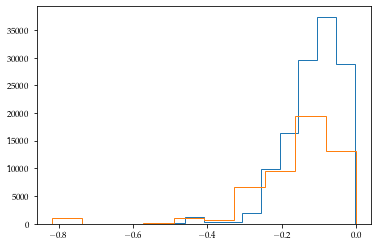

M_halo
Min: 1.52e-01
33rd percentile: 6.83e-01
66th percentile: 7.97e-01
Max: 1.00e+00


In [60]:
M_halo_ej = np.array(ejected_merged.halo_mass_frac,dtype=float)
plt.hist(np.log10(M_halo_ej), histtype='step')
x = M_halo_ej

M_halo_ex = np.array(expelled_merged.halo_mass_frac,dtype=float)
plt.hist(np.log10(M_halo_ex[(M_halo_ex != 0)&~np.isnan(M_halo_ex)]), histtype='step')
plt.show()
x = M_halo_ex[~np.isnan(M_halo_ex)]

print('M_halo')
print(f'Min: {np.min(x):.2e}')
print(f'33rd percentile: {np.percentile(x, 33):.2e}')
print(f'66th percentile: {np.percentile(x, 66):.2e}')
print(f'Max: {np.max(x):.2e}')

array([0.90740787, 0.90740787, 0.90740787, ..., 0.79324259, 0.97597803,
       0.97597803])

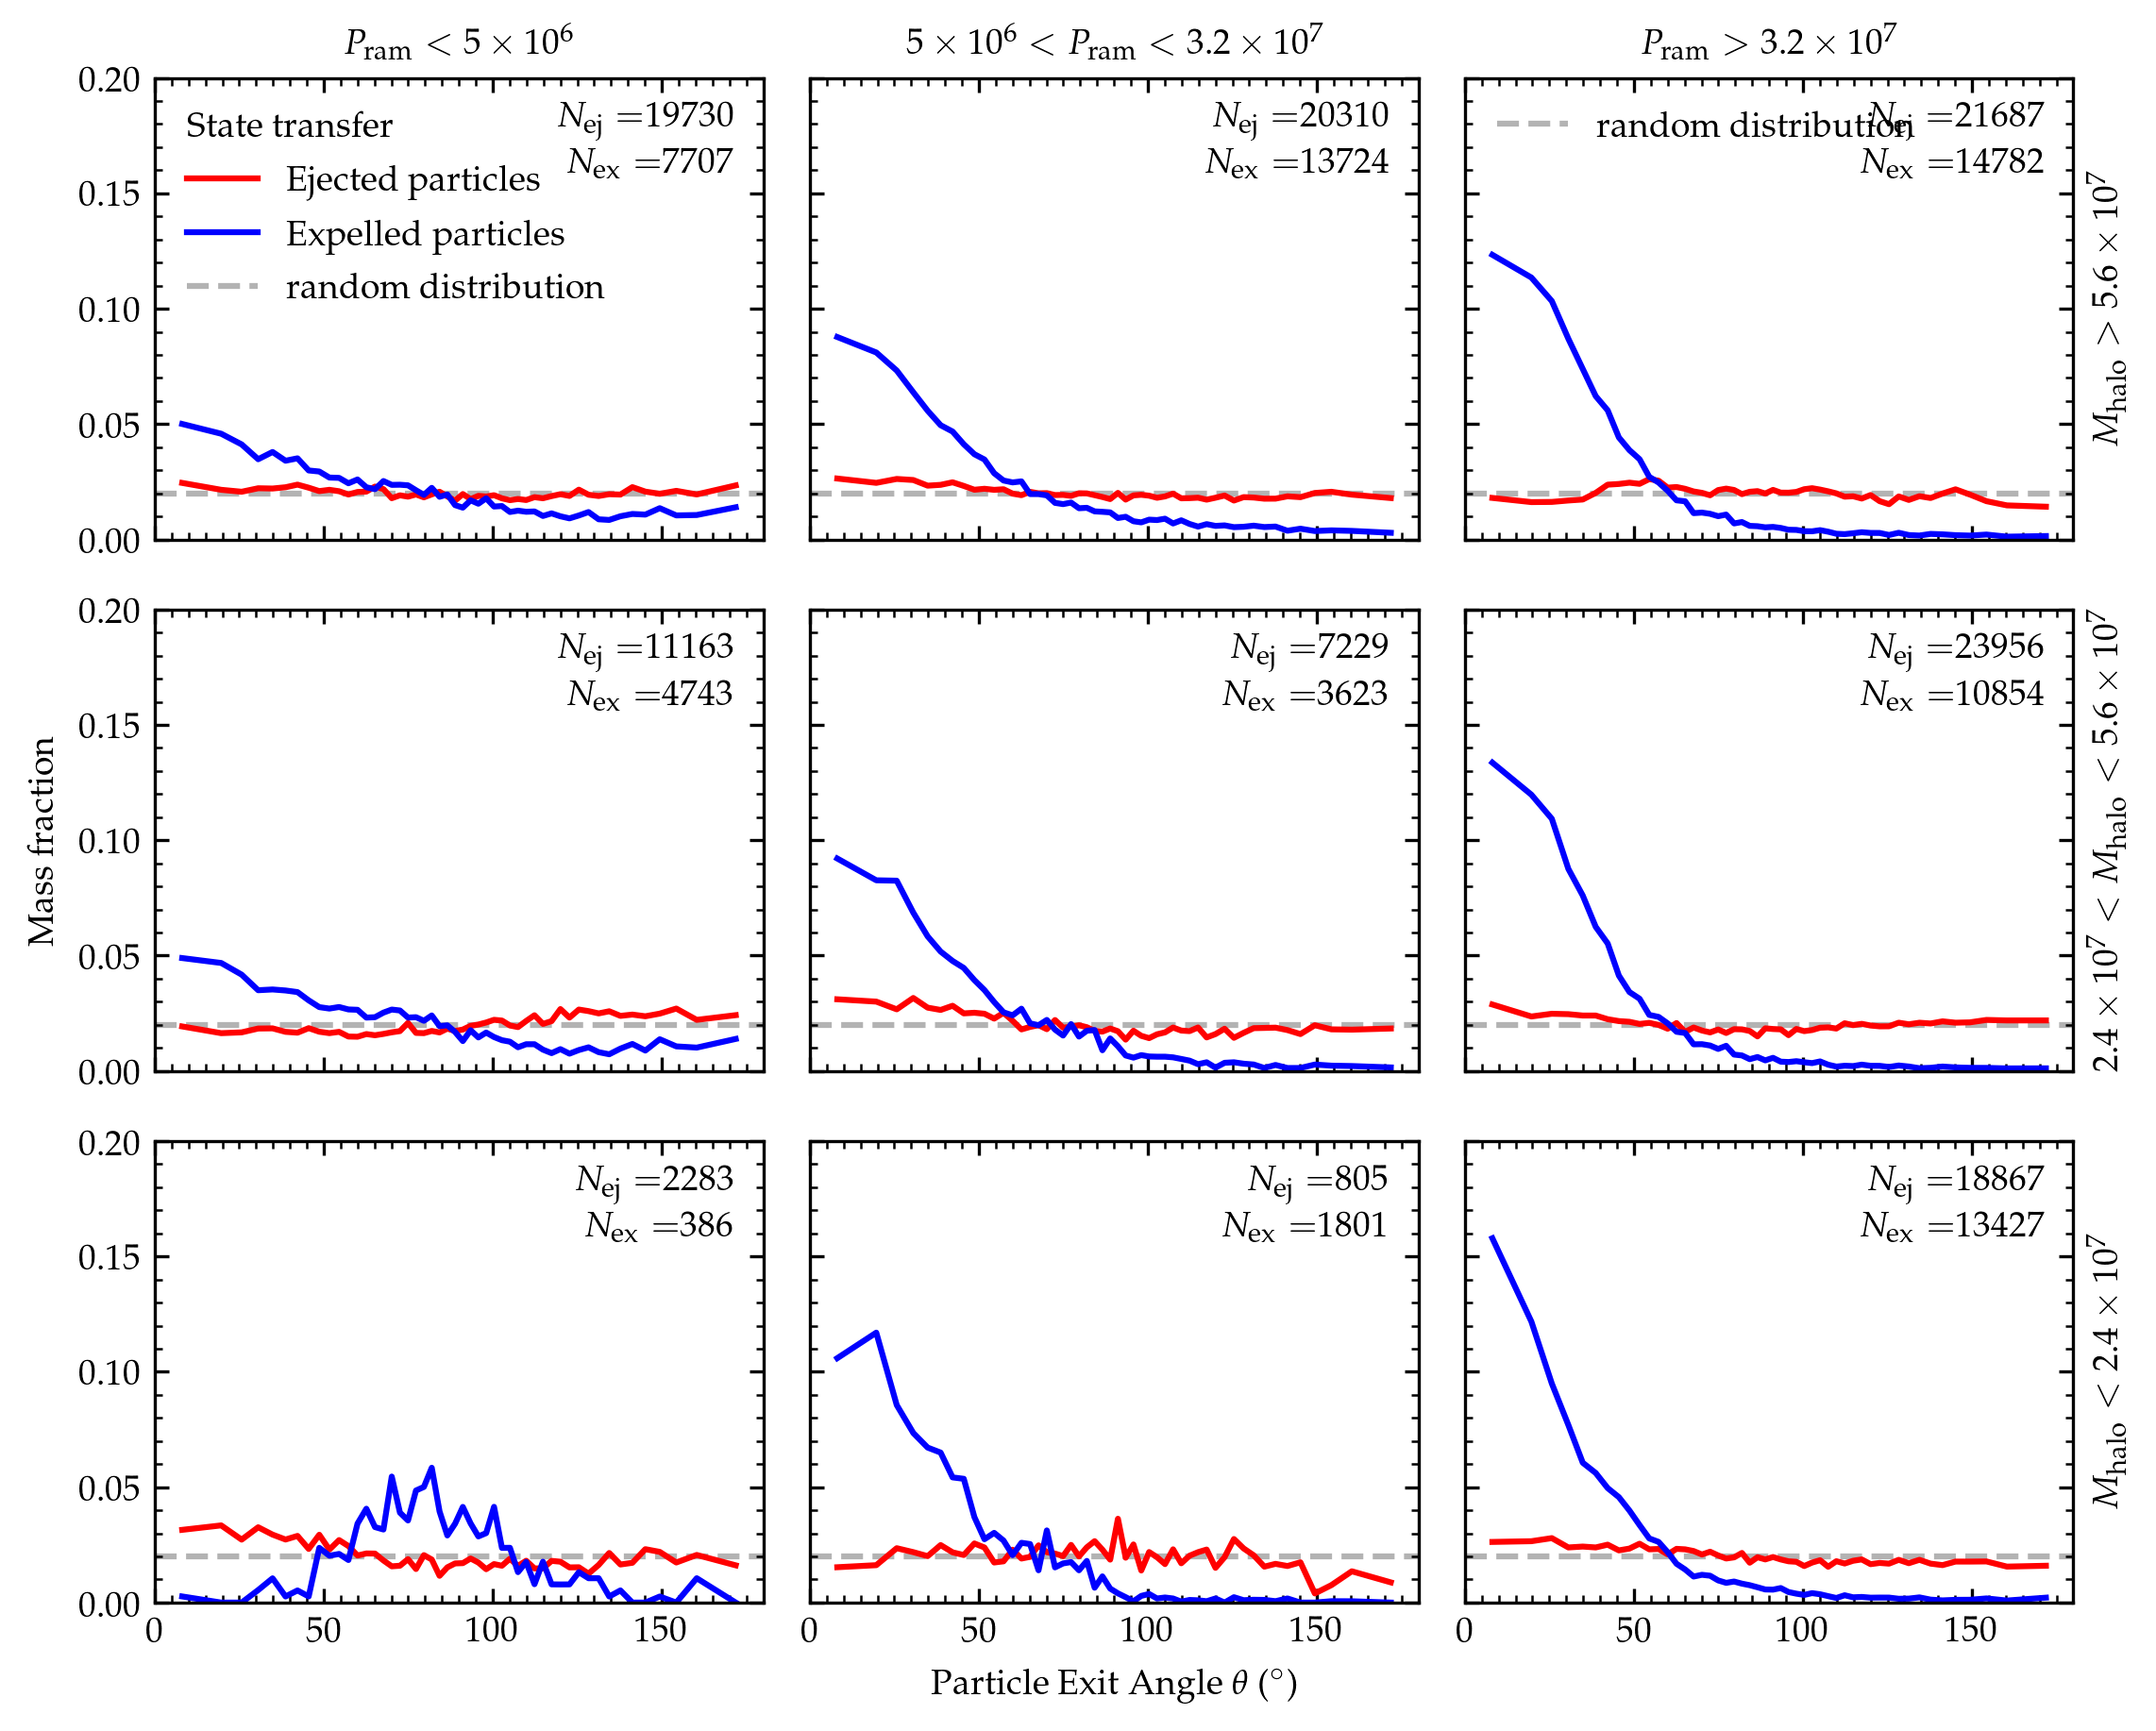

In [63]:
fig, ax = plt.subplots(3,3, dpi=300, figsize=(7.5,6), sharey=True, sharex=True, constrained_layout=True)

P_ram_ej = np.array(ejected_merged.Pram_adv,dtype=float)
P_ram_ex = np.array(expelled_merged.Pram_adv,dtype=float)
M_halo_ej = np.array(ejected_merged.halo_mass_frac,dtype=float)
M_halo_ex = np.array(expelled_merged.halo_mass_frac,dtype=float)

# top row
row_cond_ej = M_halo_ej > 0.8
row_cond_ex = M_halo_ex > 0.65

## left panel
cond_ej = row_cond_ej & (P_ram_ej <= 4.98e6)
cond_ex = row_cond_ex & (P_ram_ex <= 4.98e6)
plot_panel(ax[0,0], ejected_merged[cond_ej], expelled_merged[cond_ex], label=True)

## middle panel
cond_ej = row_cond_ej & (P_ram_ej > 4.98e6) & (P_ram_ej <= 3.2e7)
cond_ex = row_cond_ex & (P_ram_ex > 4.98e6) & (P_ram_ex <= 3.2e7)
plot_panel(ax[0,1], ejected_merged[cond_ej], expelled_merged[cond_ex])

## right panel
cond_ej = row_cond_ej & (P_ram_ej > 3.2e7)
cond_ex = row_cond_ex & (P_ram_ex > 3.2e7)
plot_panel(ax[0,2], ejected_merged[cond_ej], expelled_merged[cond_ex])


# middle row
row_cond_ej = (M_halo_ej > 0.65) & (M_halo_ej <= 0.8)
row_cond_ex = (M_halo_ex > 0.65) & (M_halo_ex <= 0.8)

## left panel
cond_ej = row_cond_ej & (P_ram_ej <= 4.98e6)
cond_ex = row_cond_ex & (P_ram_ex <= 4.98e6)
plot_panel(ax[1,0], ejected_merged[cond_ej], expelled_merged[cond_ex], label=True)

## middle panel
cond_ej = row_cond_ej & (P_ram_ej > 4.98e6) & (P_ram_ej <= 3.2e7)
cond_ex = row_cond_ex & (P_ram_ex > 4.98e6) & (P_ram_ex <= 3.2e7)
plot_panel(ax[1,1], ejected_merged[cond_ej], expelled_merged[cond_ex])

## right panel
cond_ej = row_cond_ej & (P_ram_ej > 3.2e7)
cond_ex = row_cond_ex & (P_ram_ex > 3.2e7)
plot_panel(ax[1,2], ejected_merged[cond_ej], expelled_merged[cond_ex])

# bottom row
row_cond_ej = M_halo_ej <= 0.65
row_cond_ex = M_halo_ex <= 0.65

## left panel
cond_ej = row_cond_ej & (P_ram_ej <= 4.98e6)
cond_ex = row_cond_ex & (P_ram_ex <= 4.98e6)
plot_panel(ax[2,0], ejected_merged[cond_ej], expelled_merged[cond_ex], label=True)

## middle panel
cond_ej = row_cond_ej & (P_ram_ej > 4.98e6) & (P_ram_ej <= 3.2e7)
cond_ex = row_cond_ex & (P_ram_ex > 4.98e6) & (P_ram_ex <= 3.2e7)
plot_panel(ax[2,1], ejected_merged[cond_ej], expelled_merged[cond_ex])

## right panel
cond_ej = row_cond_ej & (P_ram_ej > 3.2e7)
cond_ex = row_cond_ex & (P_ram_ex > 3.2e7)
plot_panel(ax[2,2], ejected_merged[cond_ej], expelled_merged[cond_ex])


# plot the line that represents a random distribution
percent = 1/N
for a in ax.flatten():
    a.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='random distribution')

# add legends
leg1 = ax[0,0].legend(title=r'State transfer', frameon=False, loc='upper left')
leg1._legend_box.align = 'left'
ax[0,2].legend(frameon=False, loc='upper left')

# labels and ticks and such
ax[2,1].set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax[1,0].set_ylabel('Mass fraction')
for a in ax.flatten():
    a.set_xlim(0,180)
    a.set_ylim(0,0.2)

    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
    a.tick_params(direction='in',which='both',right=True,top=True)
    
    
ax[0,0].set_title(r'$P_{\rm ram} < 5\times 10^6$', fontsize=9)
ax[0,1].set_title(r'$5\times 10^6 < P_{\rm ram} < 3.2\times 10^7$', fontsize=9)
ax[0,2].set_title(r'$P_{\rm ram} > 3.2\times 10^7$', fontsize=9)

ax[0,2].set_ylabel(r'$M_{\rm halo} > 5.6\times 10^7$', fontsize=9, rotation=90)
ax[0,2].yaxis.set_label_position('right')

ax[1,2].set_ylabel(r'$2.4\times 10^7 < M_{\rm halo} < 5.6\times 10^7$', fontsize=9, rotation=90)
ax[1,2].yaxis.set_label_position('right')

ax[2,2].set_ylabel(r'$M_{\rm halo} < 2.4\times 10^7$', fontsize=9, rotation=90)
ax[2,2].yaxis.set_label_position('right')

# plt.savefig('plots/theta_allsats_by_Pram_Prest.pdf')
plt.show()

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10


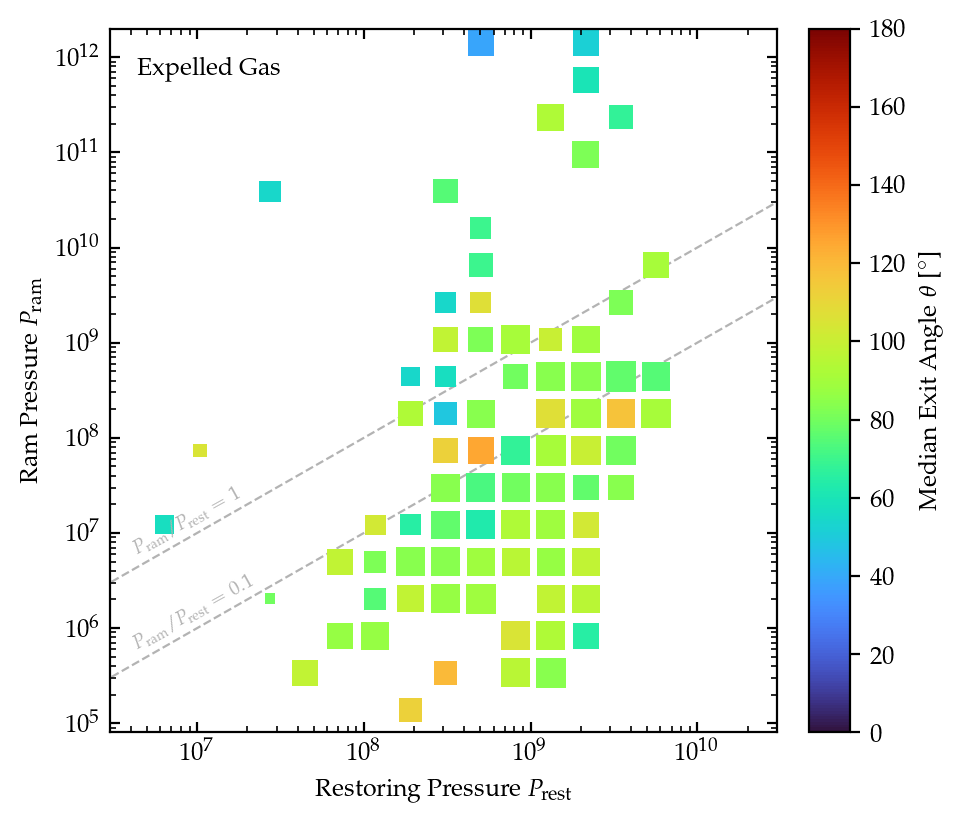

In [118]:
import scipy.stats

fig, ax = plt.subplots(1,1, figsize=(4.7,4), dpi=200, sharey=True, constrained_layout=True)


x = P_rest_ej
y = P_ram_ej
angles = np.array(ejected_merged.angle)
c = np.digitize(angles, bins=bins)

# x = P_rest_ex
# y = P_ram_ex
# angles = np.array(expelled_merged.angle)
# c = np.digitize(angles, bins=bins)


ymin,ymax = 8e4, 2e12
xmin,xmax = 3e6, 3e10

xbins = 10**np.linspace(np.log10(xmin),np.log10(xmax), 20)
ybins = 10**np.linspace(np.log10(ymin),np.log10(ymax), 20)

scale = 120

num, xedges, yedges = np.histogram2d(x, y, bins=[xbins, ybins])
mean, xedges, yedges, binnumbers = scipy.stats.binned_statistic_2d(x, y, c, statistic='median', bins=[xbins, ybins])
xcenters = 0.5*(xedges[1:]+xedges[:-1])
ycenters = 0.5*(yedges[1:]+yedges[:-1])
newx, newy, s, m = np.array([]), np.array([]), np.array([]), np.array([])
for x in range(len(xcenters)):
    for y in range(len(ycenters)):
        s = np.append(s, num[x,y])
        m = np.append(m, mean[x,y])
        newx = np.append(newx, xcenters[x])
        newy = np.append(newy, ycenters[y])
s_scaled = np.log10(s)/np.log10(s.max()) * scale

newm = []
for i in m:
    if np.isnan(i):
        newm.append(i)
    else:
        newm.append(bincenters[int(i)-1])

im = ax.scatter(newx, newy, c=newm, linewidths=0., cmap='turbo', vmin=0, vmax=180, s=s_scaled, marker='s')
cbar = fig.colorbar(im, ax=ax, label=r'Median Exit Angle $\theta$ [$^\circ$]')

# plt.plot([1e-10, 1e10], [1,1], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)
# plt.plot([1,1], [1e-10, 1e10], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)

# line where y = x
ax.plot([1e4,1e13], [1e4,1e13], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)
ax.annotate(r'$P_{\rm ram}/P_{\rm rest} = 1$', (4e6, 6e6), rotation=29, color='0.7', fontsize=7)

# line where P_ram = 0.1 P_rest, i.e. y = 0.1 x
ax.plot([1e4,1e13], [1e3,1e12], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)
ax.annotate(r'$P_{\rm ram}/P_{\rm rest} = 0.1$', (4e6, 6e5), rotation=29, color='0.7', fontsize=7)

ax.set_xlim(xmin,xmax)
ax.set_xlabel(r'Restoring Pressure $P_{\rm rest}$')

ax.set_ylim(ymin,ymax)
ax.set_ylabel(r'Ram Pressure $P_{\rm ram}$')
# ax.set_aspect('equal')

ax.loglog()
# ax.legend(frameon=False)
ax.tick_params(direction='in',which='both',top=True,right=True)


ax.annotate('Expelled Gas', (0.04, 0.96), xycoords='axes fraction', va='top')

plt.show()


/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10
/Users/hollis/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


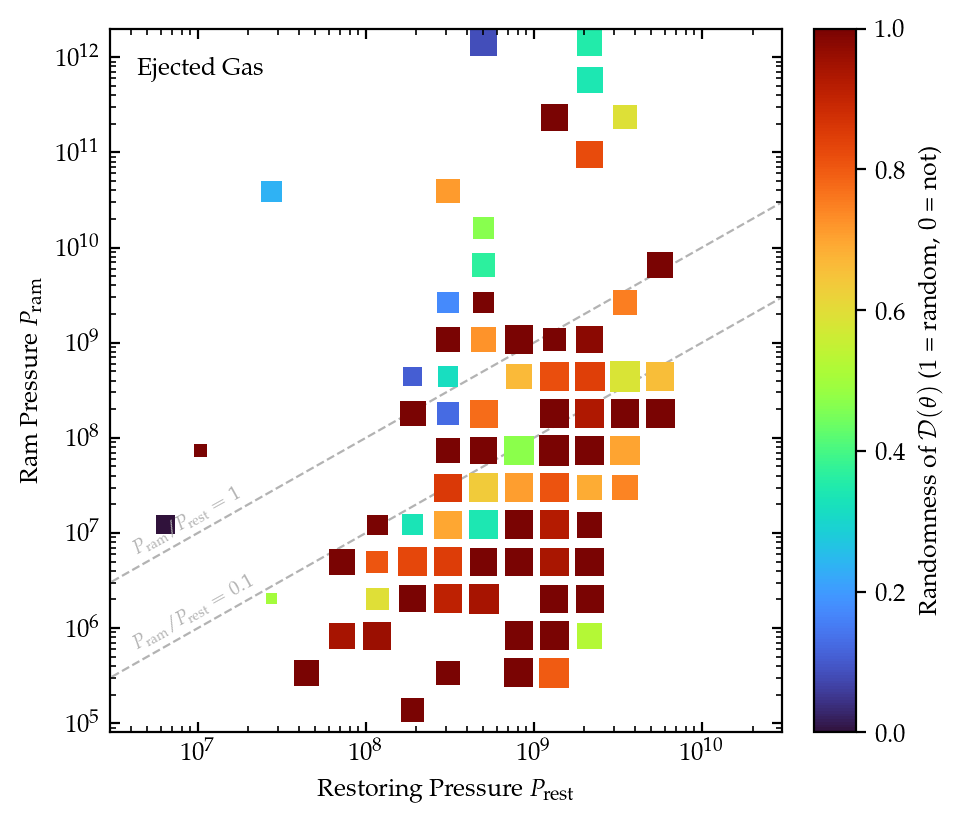

In [117]:
import scipy.stats

fig, ax = plt.subplots(1,1, figsize=(4.7,4), dpi=200, sharey=True, constrained_layout=True)


x = P_rest_ej
y = P_ram_ej
c = np.array(ejected_merged.angle)

# x = P_rest_ex
# y = P_ram_ex
# c = np.array(expelled_merged.angle)


ymin,ymax = 8e4, 2e12
xmin,xmax = 3e6, 3e10

xbins = 10**np.linspace(np.log10(xmin),np.log10(xmax), 20)
ybins = 10**np.linspace(np.log10(ymin),np.log10(ymax), 20)

scale = 120

def randomness_statistic(thetas):
    z = len(thetas[thetas > 90])/len(thetas[thetas < 90])
    return z
    


num, xedges, yedges = np.histogram2d(x, y, bins=[xbins, ybins])
mean, xedges, yedges, binnumbers = scipy.stats.binned_statistic_2d(x, y, c, statistic=randomness_statistic, bins=[xbins, ybins])
xcenters = 0.5*(xedges[1:]+xedges[:-1])
ycenters = 0.5*(yedges[1:]+yedges[:-1])
newx, newy, s, m = np.array([]), np.array([]), np.array([]), np.array([])
for x in range(len(xcenters)):
    for y in range(len(ycenters)):
        s = np.append(s, num[x,y])
        m = np.append(m, mean[x,y])
        newx = np.append(newx, xcenters[x])
        newy = np.append(newy, ycenters[y])
s_scaled = np.log10(s)/np.log10(s.max()) * scale

# newm = []
# for i in m:
#     if np.isnan(i):
#         newm.append(i)
#     else:
#         newm.append(bincenters[int(i)-1])

newm = m

im = ax.scatter(newx, newy, c=newm, linewidths=0., cmap='turbo', vmin=0, vmax=1, s=s_scaled, marker='s')
cbar = fig.colorbar(im, ax=ax, label=r'Randomness of $\mathcal{D}(\theta)$ (1 = random, 0 = not)')

# plt.plot([1e-10, 1e10], [1,1], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)
# plt.plot([1,1], [1e-10, 1e10], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)

# line where y = x
ax.plot([1e4,1e13], [1e4,1e13], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)
ax.annotate(r'$P_{\rm ram}/P_{\rm rest} = 1$', (4e6, 6e6), rotation=29, color='0.7', fontsize=7)

# line where P_ram = 0.1 P_rest, i.e. y = 0.1 x
ax.plot([1e4,1e13], [1e3,1e12], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)
ax.annotate(r'$P_{\rm ram}/P_{\rm rest} = 0.1$', (4e6, 6e5), rotation=29, color='0.7', fontsize=7)

ax.set_xlim(xmin,xmax)
ax.set_xlabel(r'Restoring Pressure $P_{\rm rest}$')

ax.set_ylim(ymin,ymax)
ax.set_ylabel(r'Ram Pressure $P_{\rm ram}$')
# ax.set_aspect('equal')

ax.loglog()
# ax.legend(frameon=False)
ax.tick_params(direction='in',which='both',top=True,right=True)


ax.annotate('Ejected Gas', (0.04, 0.96), xycoords='axes fraction', va='top')

plt.show()


In [64]:
data = read_tracked_particles('h148',68)
data.head()

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,cool_disk,hot_disk,cool_halo,hot_halo
0,5.868065,862870,0.000042,77277.796875,20329.218395,4.584909,32.461660,1.196116,-26.396881,3.917216,...,False,False,False,False,False,True,False,False,False,False
1,5.868065,908261,0.000108,40917.902344,23046.775237,4.296738,35.751742,1.317346,-31.229803,-7.729509,...,False,False,False,False,False,True,False,False,False,False
2,5.868065,1274232,0.000060,154811.500000,27362.974877,0.000000,45.951432,1.693174,-29.805282,7.049564,...,False,False,False,False,False,True,False,False,False,False
3,5.868065,1319588,0.000097,50256.691406,29960.409559,3.660178,33.483456,1.233766,-24.339920,1.210833,...,False,False,False,False,False,True,False,False,False,False
4,5.868065,1345557,0.000038,291773.031250,20221.370093,2.861061,28.801781,1.061260,-23.208525,15.573301,...,False,False,False,False,False,True,False,False,False,False


In [65]:
key = 'h148_68'
path = '../../Data/expelled_particles.hdf5'
expelled = pd.read_hdf(path, key=key)
expelled.head()

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_disk,host_halo,other_sat,IGM,cool_disk,hot_disk,cool_halo,hot_halo,state2,angle
2,9.921974,1274232,0.014496,12363.898438,27512.392303,8.988137,2.613642,0.076467,1.055830,1.901123,...,False,True,False,False,False,False,False,True,host halo,38.649036
2,10.352954,1274232,0.000287,35095.910156,27513.354247,8.988137,16.847174,0.486334,-8.843446,1.023100,...,False,True,False,False,False,False,False,False,host halo,92.241136
20,9.921974,2015967,0.002238,16695.691406,26554.675618,0.000000,23.344329,0.682984,-20.549929,7.510709,...,False,True,False,False,False,False,False,False,host halo,41.742848
21,10.767100,2016219,0.000086,19488.197266,26635.402959,9.833260,11.246251,0.324919,4.086353,9.873139,...,False,True,False,False,False,False,False,False,host halo,32.366807
30,9.921974,2016985,0.019664,11868.317383,26585.877502,9.093356,2.375633,0.069504,1.540172,1.796025,...,False,True,False,False,False,False,False,True,host halo,67.687899


In [70]:
data = data[data.pid==1274232]
data[['r_per_Rvir','hot_halo','host_halo','r','in_sat','in_host']]

,r_per_Rvir,hot_halo,host_halo,r,in_sat,in_host
2,1.693174,False,False,45.951432,False,False
2,0.592428,False,False,17.539487,False,False
2,0.555336,True,False,17.326834,True,False
2,0.449113,True,False,14.219644,True,False
2,0.261918,True,False,8.557850,True,False
2,0.149742,True,False,5.167705,True,False
2,0.061940,True,True,2.228244,True,True
2,0.021943,False,True,0.813378,True,True
2,0.009583,False,True,0.339268,True,True
2,0.038745,False,True,1.244188,True,True


At first, this result seemed backwards to me: this shows that ram pressure stripping is more effective at removing cool disk gas than hot disk gas. That makes no sense!

However, there is a bit of nuance: the hot disk is not a thing that is expected to exist in real galaxies. Its instead a product of our feedback model which heats up gas as a proxy for increasing its kinetic energy. This means that the hot disk gas here is largely gas that has been affected by SNe, or heated through some other mechanism, so it tends to be ejected in all directions. 

**I'm actually not sure I understand this yet.**

In [12]:
mass1 = np.array(just_left1.mass)
weights1 = mass1/mass1.sum()

mass2 = np.array(just_left2.mass)
weights2 = mass2/mass2.sum()

It is now time to construct our plot!

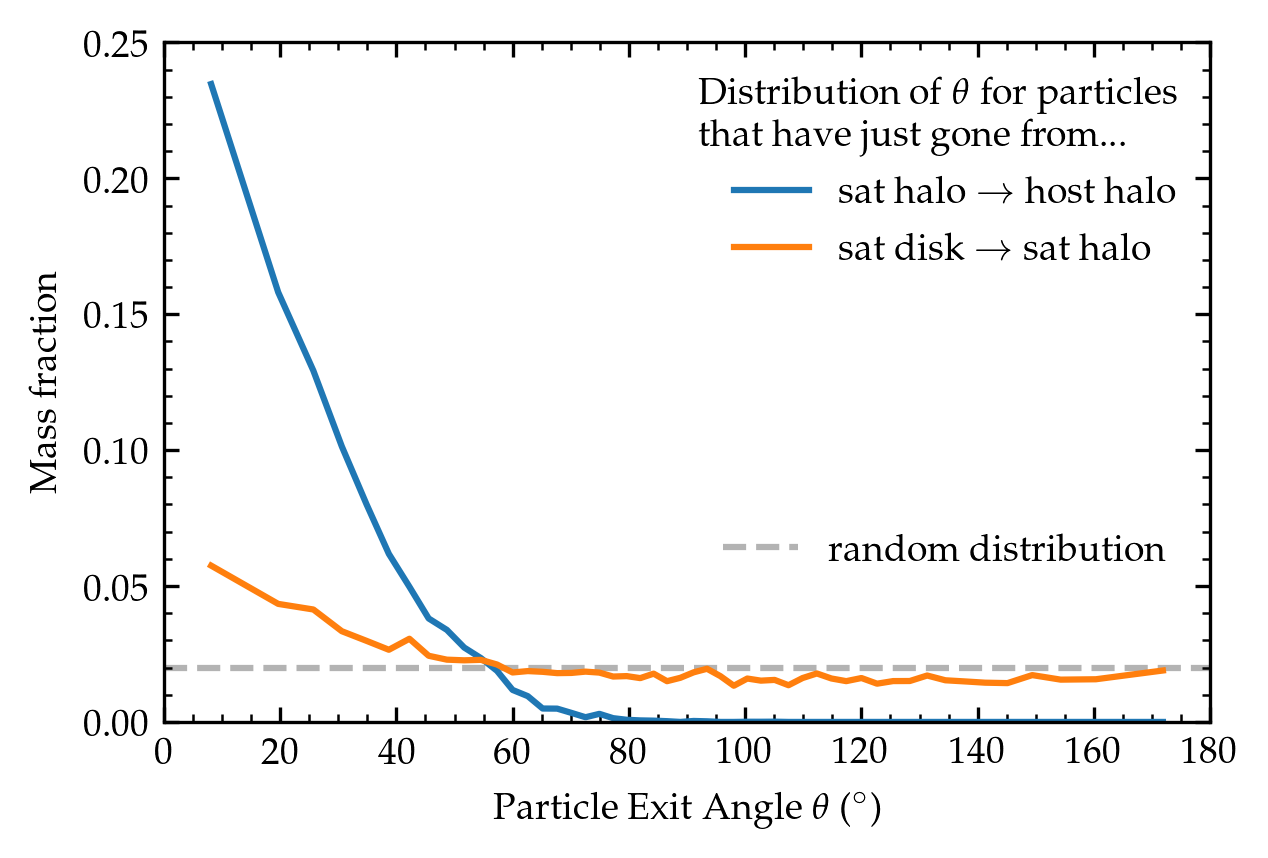

In [13]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3))

# plot the two distributions
y1, bins = np.histogram(angles1, bins=bins, weights=weights1)
l1 = r'sat halo $\to$ host halo'
p1, = ax.plot(bincenters, y1, label=l1)
y2, bins = np.histogram(angles2, bins=bins, weights=weights2)
l2 = r'sat disk $\to$ sat halo'
p2, = ax.plot(bincenters, y2, label=l2)

# plot the line that represents a random distribution
percent = 1/N
p3, = ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)

# add legends
leg1 = ax.legend([p1,p2],[l1,l2],title=r'Distribution of $\theta$ for'+' particles\n that have just gone from...', frameon=False)
leg1._legend_box.align = 'right'
leg2 = ax.legend([p3],['random distribution'], frameon=False, loc=(0.52,0.2))
ax.add_artist(leg1)

# labels and ticks and such
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Mass fraction')
ax.set_xlim(0,180)
ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.show()

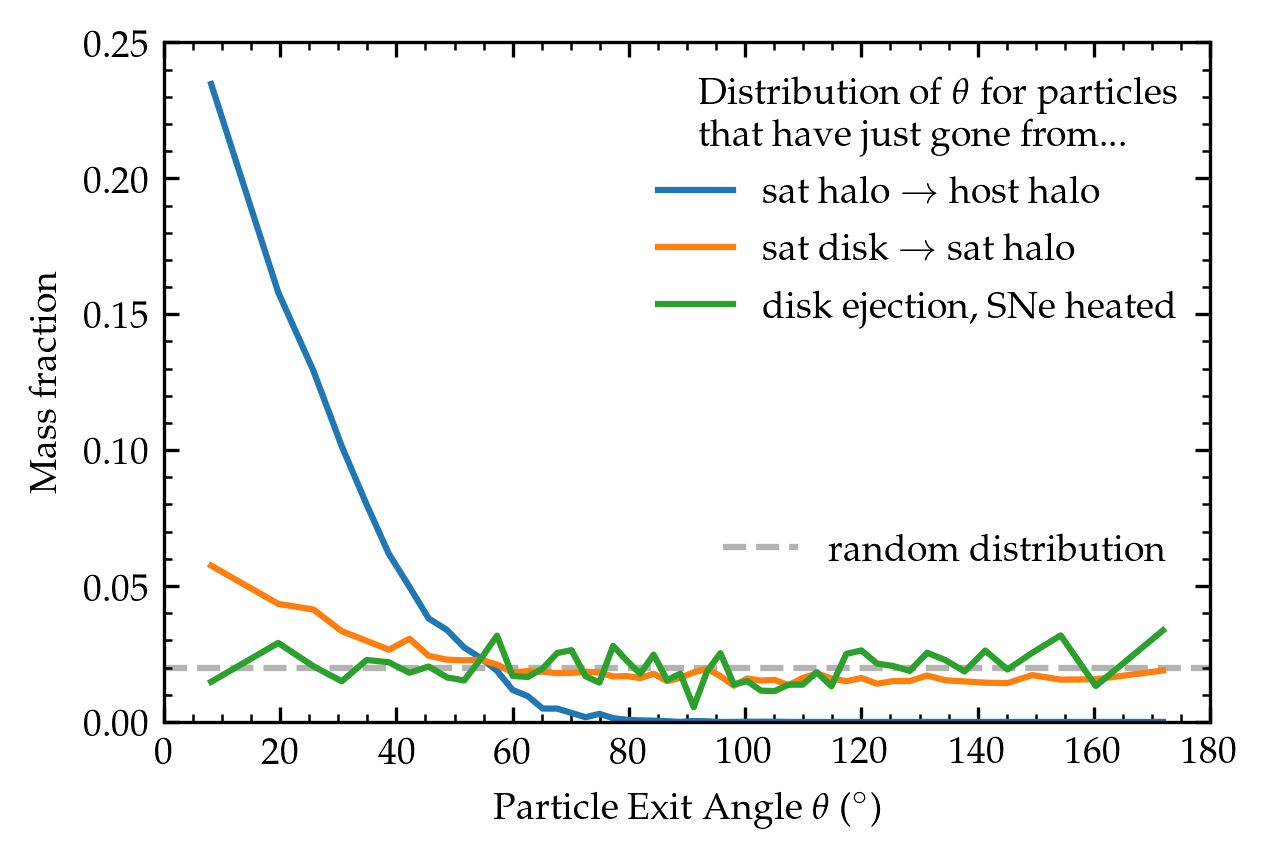

In [14]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3))

# plot the two distributions
y1, bins = np.histogram(angles1, bins=bins, weights=weights1)
l1 = r'sat halo $\to$ host halo'
p1, = ax.plot(bincenters, y1, label=l1)
y2, bins = np.histogram(angles2, bins=bins, weights=weights2)
l2 = r'sat disk $\to$ sat halo'
p2, = ax.plot(bincenters, y2, label=l2)

cond = just_left2.coolontime > just_left2.time
y3, bins = np.histogram(angles2[cond], bins=bins, weights=mass2[cond]/mass2[cond].sum())
l3 = r'disk ejection, SNe heated'
p3, = ax.plot(bincenters, y3, label=l3)

# plot the line that represents a random distribution
percent = 1/N
p4, = ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)

# add legends
leg1 = ax.legend([p1,p2,p3],[l1,l2,l3],title=r'Distribution of $\theta$ for'+' particles\n that have just gone from...', frameon=False)
leg1._legend_box.align = 'right'
leg2 = ax.legend([p4],['random distribution'], frameon=False, loc=(0.52,0.2))
ax.add_artist(leg1)

# labels and ticks and such
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Mass fraction')
ax.set_xlim(0,180)
ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.show()

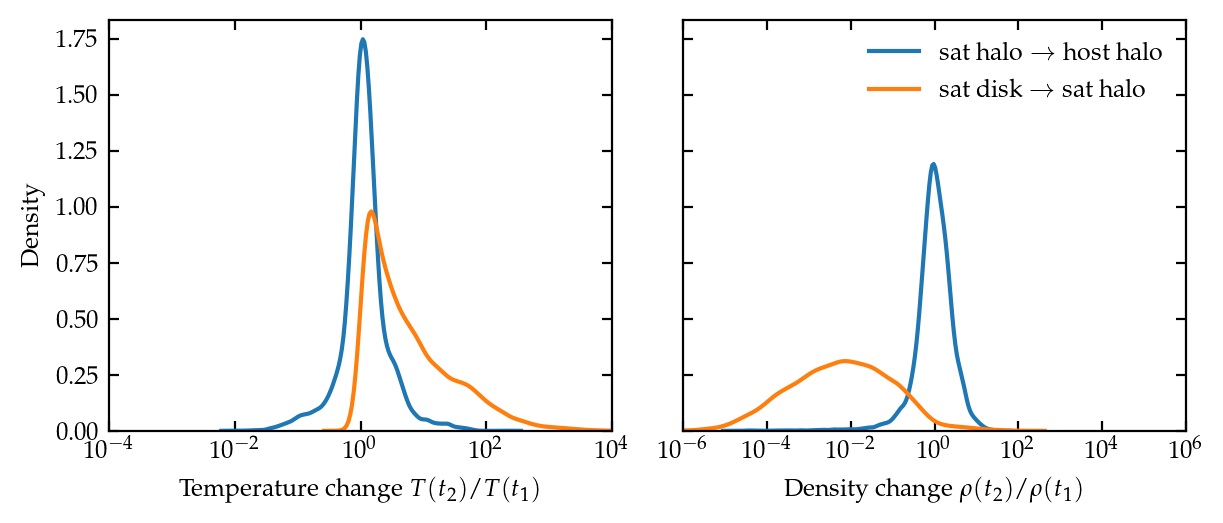

In [15]:
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize=(6,2.5), dpi=200, sharey=True, constrained_layout=True)
sns.kdeplot(np.array(just_left1.temp)/np.array(prior_to_leaving1.temp), ax=ax[0], log_scale=True, label=r'sat halo $\to$ host halo')
sns.kdeplot(np.array(just_left2.temp)/np.array(prior_to_leaving2.temp), ax=ax[0], log_scale=True, label=r'sat disk $\to$ sat halo')
# sns.kdeplot(np.array(just_left2.temp/prior_to_leaving2.temp)[prior_to_leaving2.coolontime > prior_to_leaving2.time], 
#             ax=ax[0], color='tab:orange', linestyle='--', linewidth='1', log_scale=True, label=r'sat disk $\to$ sat halo')

ax[0].set_xlim(1e-4,1e4)
ax[0].set_xlabel(r'Temperature change $T(t_2)/T(t_1)$')

sns.kdeplot(np.array(just_left1.rho)/np.array(prior_to_leaving1.rho), ax=ax[1], log_scale=True, label=r'sat halo $\to$ host halo')
sns.kdeplot(np.array(just_left2.rho)/np.array(prior_to_leaving2.rho), ax=ax[1], log_scale=True, label=r'sat disk $\to$ sat halo')

ax[1].set_xlim(1e-6,1e6)
ax[1].set_xlabel(r'Density change $\rho(t_2)/\rho(t_1)$')
ax[1].legend(frameon=False)

ax[0].tick_params(direction='in',which='both',top=True,right=True)
ax[1].tick_params(direction='in',which='both',top=True,right=True)

plt.show()


The goal of this plot would be to distinguish between the two processes potentially leading to a random distribuition of exit angles. 

* The first, feedback, should increase the gas temperature while leaving the density alone.
* The second, tidal stripping, should not affect the temperature but may affect the density. 

We can see above that for halo gas ejected, there is generally no preference for an increase or decrease in either temperature or density. This makes sense, as ram pressure should not be able to significantly alter the state of the gas. The only documented thing I can think of is RP compacting gas and increasing the density, but that would probably not happen for the already hot/diffuse gas in the halo. 

For disk gas ejected, however, there is a strong preference for an increase in temperature and a decrease in density. However, the increase in temperature peaks close to 1, indicating that a lot of particles have little temperature change but have a change in density. This is a signature of tidal stripping. The temperature distribution is highly right-skewed, which indicates that there is likely feedback at play. 

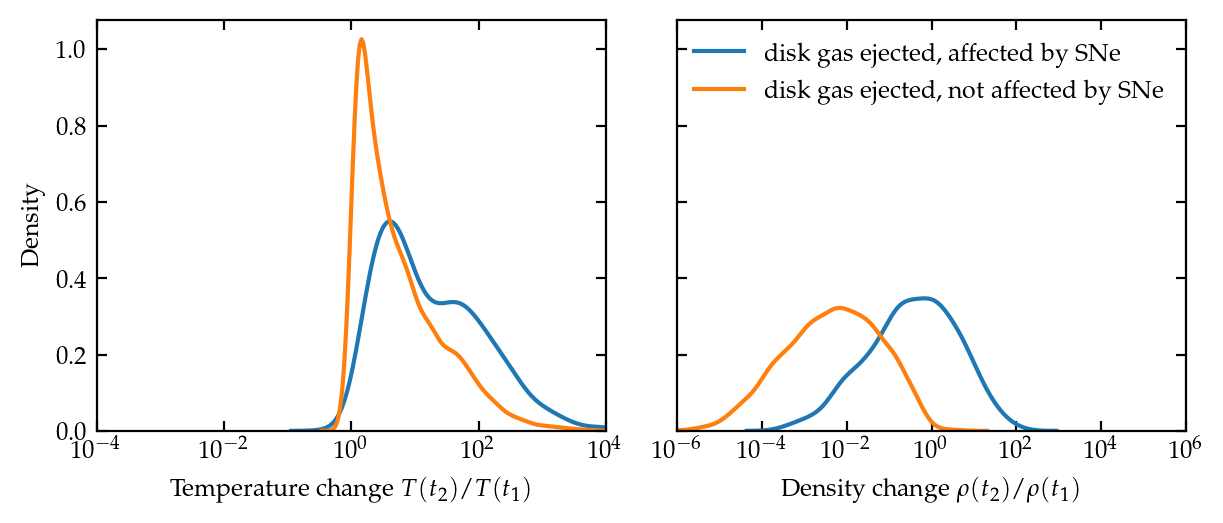

In [16]:
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize=(6,2.5), dpi=200, sharey=True, constrained_layout=True)

cond =  just_left2.coolontime > just_left2.time

y = np.array(just_left2.temp)/np.array(prior_to_leaving2.temp)
sns.kdeplot(y[cond], ax=ax[0], log_scale=True, label=r'disk gas ejected, affected by SNe')
sns.kdeplot(y[~cond], ax=ax[0], log_scale=True, label=r'disk gas ejected, not affected by SNe')

ax[0].set_xlim(1e-4,1e4)
ax[0].set_xlabel(r'Temperature change $T(t_2)/T(t_1)$')

y = np.array(just_left2.rho)/np.array(prior_to_leaving2.rho)
sns.kdeplot(y[cond], ax=ax[1], log_scale=True, label=r'disk gas ejected, affected by SNe')
sns.kdeplot(y[~cond], ax=ax[1], log_scale=True, label=r'disk gas ejected, not affected by SNe')

ax[1].set_xlim(1e-6,1e6)
ax[1].set_xlabel(r'Density change $\rho(t_2)/\rho(t_1)$')
ax[1].legend(frameon=False)

ax[0].tick_params(direction='in',which='both',top=True,right=True)
ax[1].tick_params(direction='in',which='both',top=True,right=True)

plt.show()


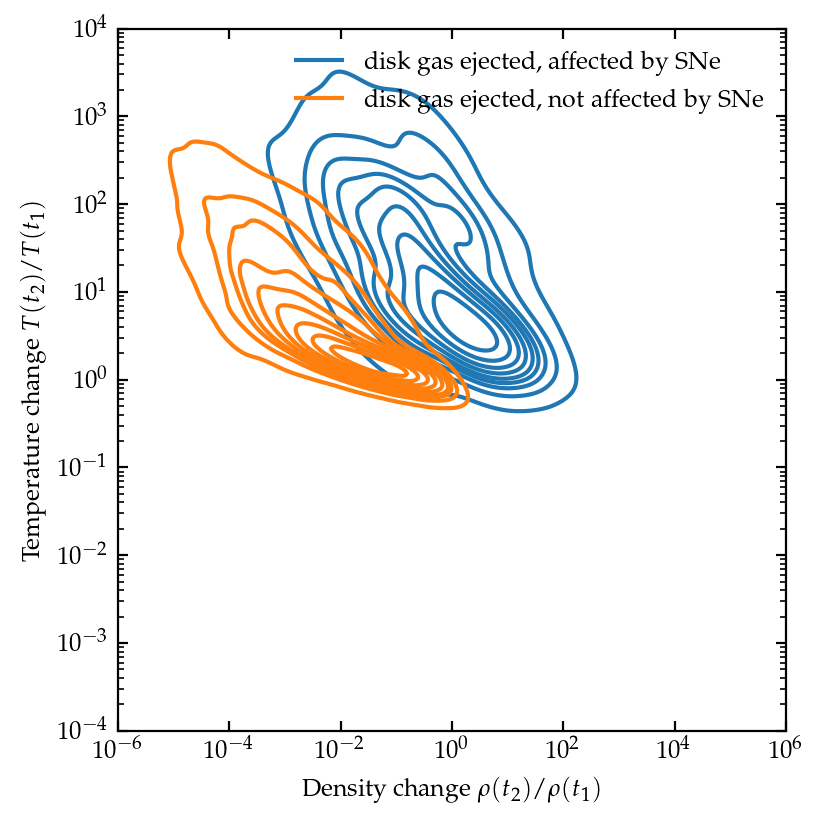

In [17]:
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200, sharey=True, constrained_layout=True)

cond =  just_left2.coolontime > just_left2.time

x = np.array(just_left2.rho)/np.array(prior_to_leaving2.rho)
y = np.array(just_left2.temp)/np.array(prior_to_leaving2.temp)
sns.kdeplot(x=x[cond], y=y[cond], ax=ax, log_scale=True, label=r'disk gas ejected, affected by SNe')
sns.kdeplot(x=x[~cond], y=y[~cond], ax=ax, log_scale=True, label=r'disk gas ejected, not affected by SNe')

ax.set_xlim(1e-6,1e6)
ax.set_xlabel(r'Density change $\rho(t_2)/\rho(t_1)$')

ax.set_ylim(1e-4,1e4)
ax.set_ylabel(r'Temperature change $T(t_2)/T(t_1)$')

ax.legend(frameon=False)
ax.tick_params(direction='in',which='both',top=True,right=True)

plt.show()


/Users/hollis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/hollis/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


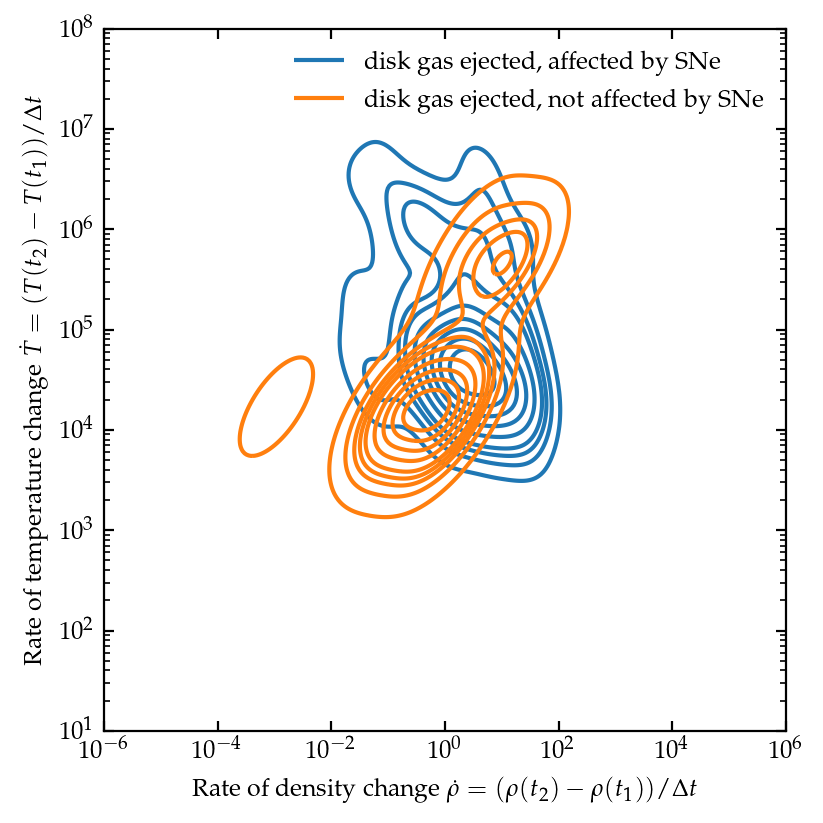

In [64]:
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200, sharey=True, constrained_layout=True)

cond =  just_left2.coolontime > just_left2.time

delta_t = np.array(just_left2.time) - np.array(prior_to_leaving2.time)
x = (np.array(just_left2.rho) - np.array(prior_to_leaving2.rho)) / delta_t
y = (np.array(just_left2.temp) - np.array(prior_to_leaving2.temp)) / delta_t
sns.kdeplot(x=x[cond], y=y[cond], ax=ax, log_scale=True, label=r'disk gas ejected, affected by SNe')
sns.kdeplot(x=x[~cond], y=y[~cond], ax=ax, log_scale=True, label=r'disk gas ejected, not affected by SNe')



# delta_t = np.array(just_left1.time) - np.array(prior_to_leaving1.time)
# x = (np.array(just_left1.rho) - np.array(prior_to_leaving1.rho)) / delta_t
# y = (np.array(just_left1.temp) - np.array(prior_to_leaving1.temp)) / delta_t
# sns.kdeplot(x=x, y=y, ax=ax, log_scale=True, label=r'halo gas ejected')

ax.set_xlim(1e-6,1e6)
ax.set_xlabel(r'Rate of density change $\dot{\rho} = (\rho(t_2) - \rho(t_1))/\Delta t$')

ax.set_ylim(1e1,1e8)
ax.set_ylabel(r'Rate of temperature change $\dot{T} = (T(t_2) - T(t_1))/\Delta t$')

ax.legend(frameon=False)
ax.tick_params(direction='in',which='both',top=True,right=True)


plt.show()


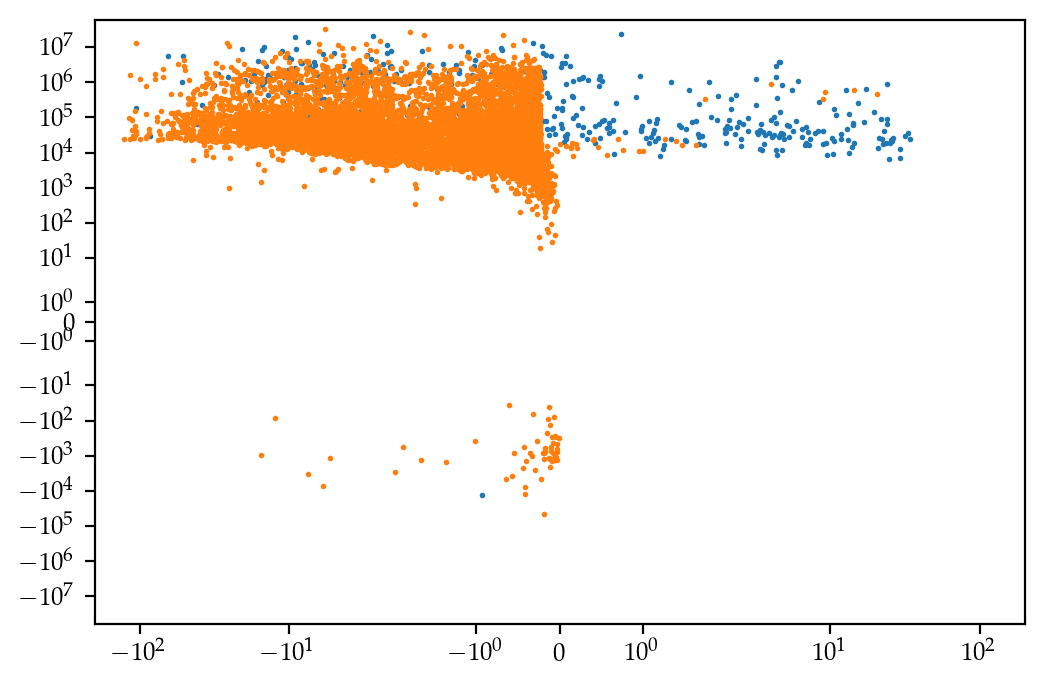

In [68]:
plt.figure(dpi=200)

plt.scatter(x[cond],y[cond], s=1)
plt.scatter(x[~cond],y[~cond], s=1)
plt.xscale('symlog')
plt.xlim(-2e2, 2e2)

plt.yscale('symlog')
plt.ylim(-6e7,6e7)

plt.show()


In [35]:
delta_t = np.array(just_left2.time) - np.array(prior_to_leaving2.time)
x = 10**((np.array(just_left2.rho) - np.array(prior_to_leaving2.rho)) / delta_t)
y = (np.array(just_left2.temp) - np.array(prior_to_leaving2.temp)) / delta_t

y

array([102765.30235316,  44933.36566406, 114734.46352017, ...,
         8222.29398161, 188252.83177516,  13807.00063654])

Plotting disk gas
Plotting halo gas


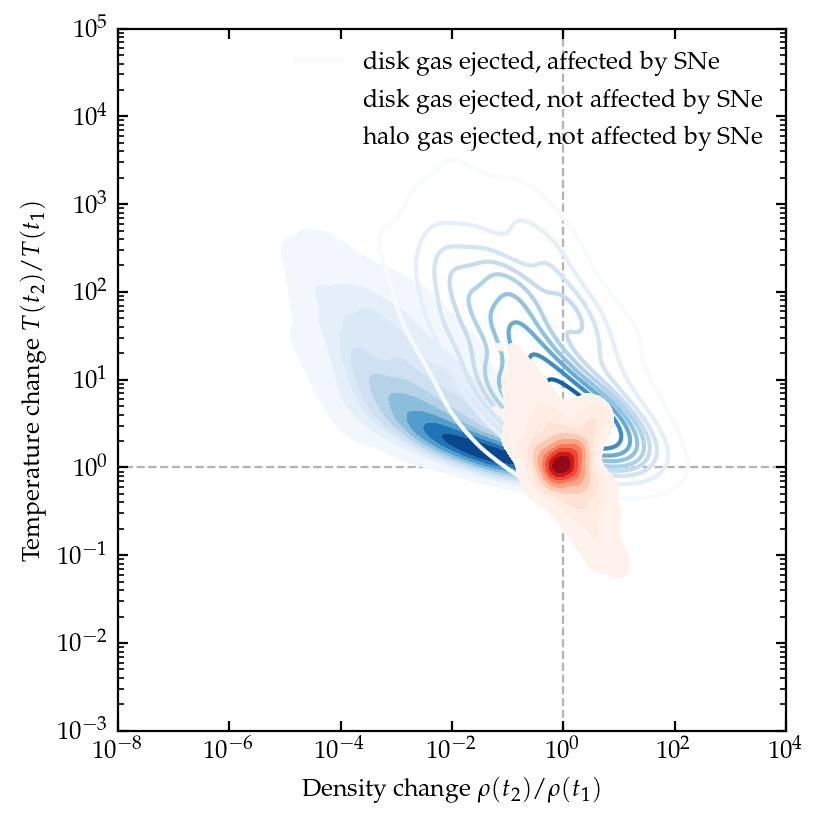

In [22]:
import scipy.stats

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200, sharey=True, constrained_layout=True)

x = np.array(just_left2.rho)/np.array(prior_to_leaving2.rho)
y = np.array(just_left2.temp)/np.array(prior_to_leaving2.temp)
c = np.digitize(angles2, bins=bins)

cond =  just_left2.coolontime > just_left2.time
print('Plotting disk gas')
sns.kdeplot(x=x[cond], y=y[cond], ax=ax, log_scale=True, fill=False, cmap='Blues', label=r'disk gas ejected, affected by SNe', zorder=1)
sns.kdeplot(x=x[~cond], y=y[~cond], ax=ax, log_scale=True, fill=True, cmap='Blues', label=r'disk gas ejected, not affected by SNe', zorder=0)


x = np.array(just_left1.rho)/np.array(prior_to_leaving1.rho)
y = np.array(just_left1.temp)/np.array(prior_to_leaving1.temp)
c = np.digitize(angles1, bins=bins)

cond =  just_left1.coolontime > just_left1.time
print('Plotting halo gas')
sns.kdeplot(x=x[cond], y=y[cond], ax=ax, log_scale=True, fill=False, cmap='Reds', label=r'halo gas ejected, affected by SNe', zorder=2)
sns.kdeplot(x=x[~cond], y=y[~cond], ax=ax, log_scale=True, fill=True, cmap='Reds', label=r'halo gas ejected, not affected by SNe', zorder=1)



xmin,xmax = 1e-8,1e4
ymin,ymax = 1e-3,1e5

plt.plot([1e-10, 1e10], [1,1], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)
plt.plot([1,1], [1e-10, 1e10], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)

ax.set_xlim(xmin,xmax)
ax.set_xlabel(r'Density change $\rho(t_2)/\rho(t_1)$')

ax.set_ylim(ymin,ymax)
ax.set_ylabel(r'Temperature change $T(t_2)/T(t_1)$')
# ax.set_aspect('equal')

ax.loglog()
ax.legend(frameon=False)
ax.tick_params(direction='in',which='both',top=True,right=True)


plt.show()


In [67]:
N = 50 # more bins than Bahé et al since we have lots of particles
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/Users/hollis/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


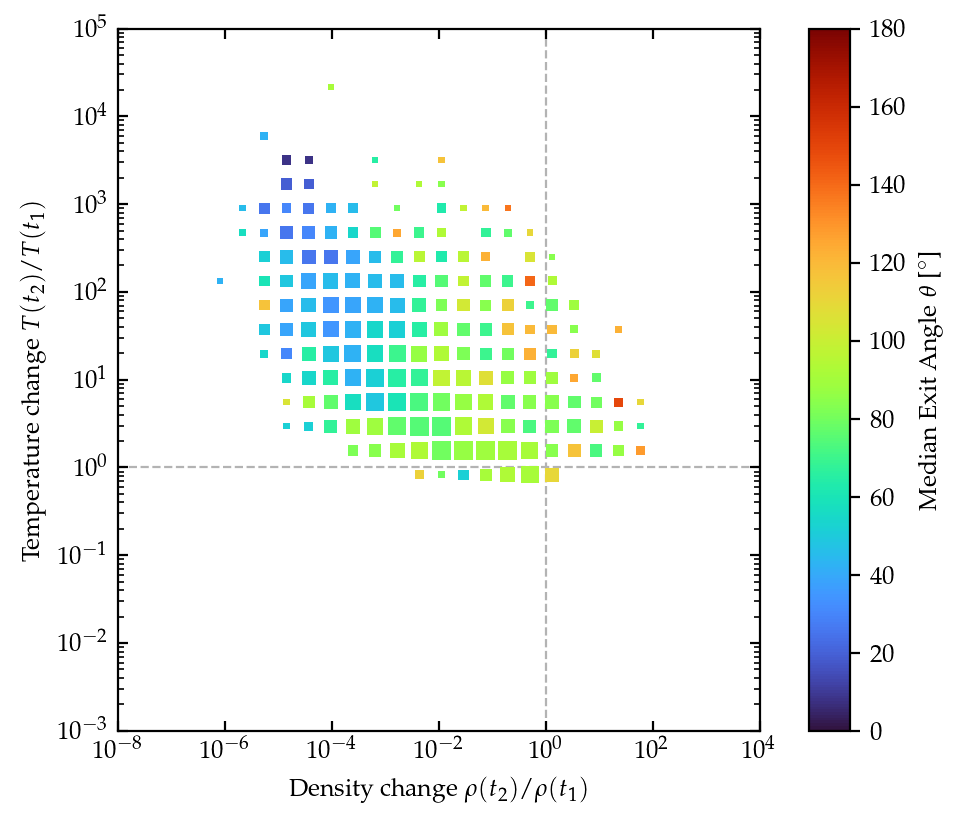

In [38]:
import scipy.stats

fig, ax = plt.subplots(1,1, figsize=(4.7,4), dpi=200, sharey=True, constrained_layout=True)

x = np.array(just_left2.rho)/np.array(prior_to_leaving2.rho)
y = np.array(just_left2.temp)/np.array(prior_to_leaving2.temp)
c = np.digitize(angles2, bins=bins)


xmin,xmax = 1e-8,1e4
ymin,ymax = 1e-3,1e5

xbins = 10**np.linspace(np.log10(xmin),np.log10(xmax), 30)
ybins = 10**np.linspace(np.log10(ymin),np.log10(ymax), 30)

scale = 50

num, xedges, yedges = np.histogram2d(x, y, bins=[xbins, ybins])
mean, xedges, yedges, binnumbers = scipy.stats.binned_statistic_2d(x, y, c, statistic='median', bins=[xbins, ybins])
xcenters = 0.5*(xedges[1:]+xedges[:-1])
ycenters = 0.5*(yedges[1:]+yedges[:-1])
newx, newy, s, m = np.array([]), np.array([]), np.array([]), np.array([])
for x in range(len(xcenters)):
    for y in range(len(ycenters)):
        s = np.append(s, num[x,y])
        m = np.append(m, mean[x,y])
        newx = np.append(newx, xcenters[x])
        newy = np.append(newy, ycenters[y])
s_scaled = np.log10(s)/np.log10(s.max()) * scale



newm = []
for i in m:
    if np.isnan(i):
        newm.append(i)
    else:
        newm.append(bincenters[int(i)-1])

im = ax.scatter(newx, newy, c=newm, linewidths=0., cmap='turbo', vmin=0, vmax=180, s=s_scaled, marker='s')
cbar = fig.colorbar(im, ax=ax, label=r'Median Exit Angle $\theta$ [$^\circ$]')

plt.plot([1e-10, 1e10], [1,1], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)
plt.plot([1,1], [1e-10, 1e10], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)

ax.set_xlim(xmin,xmax)
ax.set_xlabel(r'Density change $\rho(t_2)/\rho(t_1)$')

ax.set_ylim(ymin,ymax)
ax.set_ylabel(r'Temperature change $T(t_2)/T(t_1)$')
# ax.set_aspect('equal')

ax.loglog()
# ax.legend(frameon=False)
ax.tick_params(direction='in',which='both',top=True,right=True)


plt.show()


/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


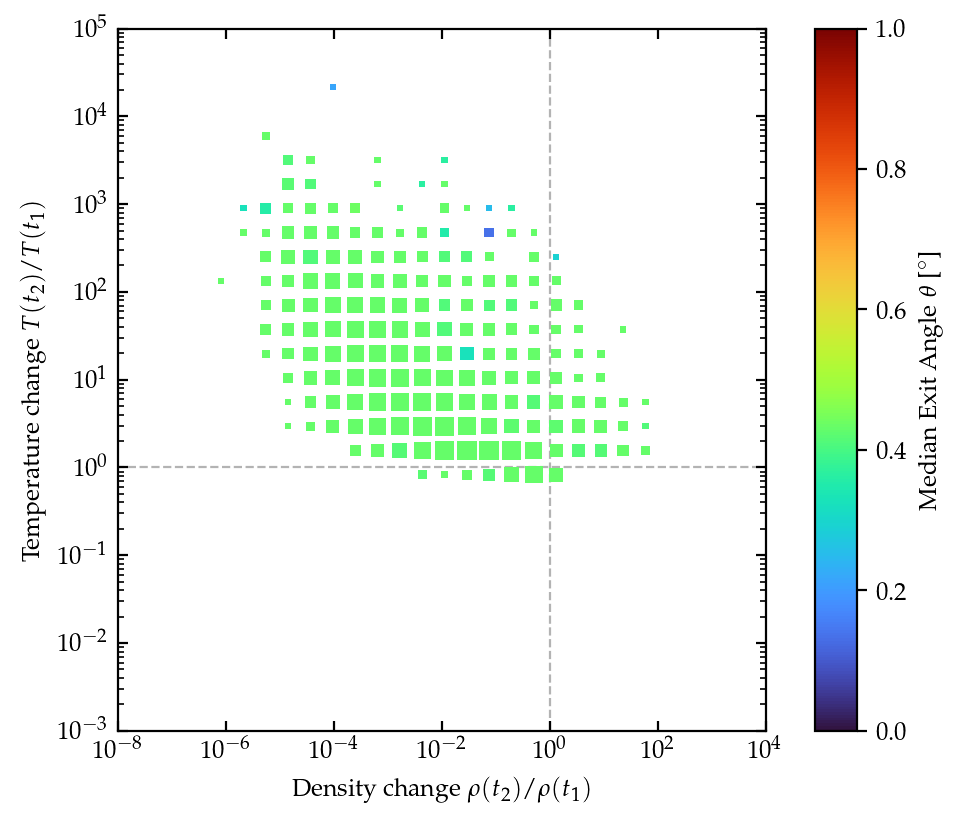

In [42]:
import scipy.stats

fig, ax = plt.subplots(1,1, figsize=(4.7,4), dpi=200, sharey=True, constrained_layout=True)

x = np.array(just_left2.rho)/np.array(prior_to_leaving2.rho)
y = np.array(just_left2.temp)/np.array(prior_to_leaving2.temp)
c = np.array(just_left2.time) - np.array(prior_to_leaving2.time)


xmin,xmax = 1e-8,1e4
ymin,ymax = 1e-3,1e5

xbins = 10**np.linspace(np.log10(xmin),np.log10(xmax), 30)
ybins = 10**np.linspace(np.log10(ymin),np.log10(ymax), 30)

scale = 50

num, xedges, yedges = np.histogram2d(x, y, bins=[xbins, ybins])
mean, xedges, yedges, binnumbers = scipy.stats.binned_statistic_2d(x, y, c, statistic='median', bins=[xbins, ybins])
xcenters = 0.5*(xedges[1:]+xedges[:-1])
ycenters = 0.5*(yedges[1:]+yedges[:-1])
newx, newy, s, m = np.array([]), np.array([]), np.array([]), np.array([])
for x in range(len(xcenters)):
    for y in range(len(ycenters)):
        s = np.append(s, num[x,y])
        m = np.append(m, mean[x,y])
        newx = np.append(newx, xcenters[x])
        newy = np.append(newy, ycenters[y])
s_scaled = np.log10(s)/np.log10(s.max()) * scale


im = ax.scatter(newx, newy, c=m, linewidths=0., cmap='turbo', vmin=0, vmax=1, s=s_scaled, marker='s')
cbar = fig.colorbar(im, ax=ax, label=r'Median Exit Angle $\theta$ [$^\circ$]')

plt.plot([1e-10, 1e10], [1,1], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)
plt.plot([1,1], [1e-10, 1e10], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)

ax.set_xlim(xmin,xmax)
ax.set_xlabel(r'Density change $\rho(t_2)/\rho(t_1)$')

ax.set_ylim(ymin,ymax)
ax.set_ylabel(r'Temperature change $T(t_2)/T(t_1)$')
# ax.set_aspect('equal')

ax.loglog()
# ax.legend(frameon=False)
ax.tick_params(direction='in',which='both',top=True,right=True)


plt.show()


/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


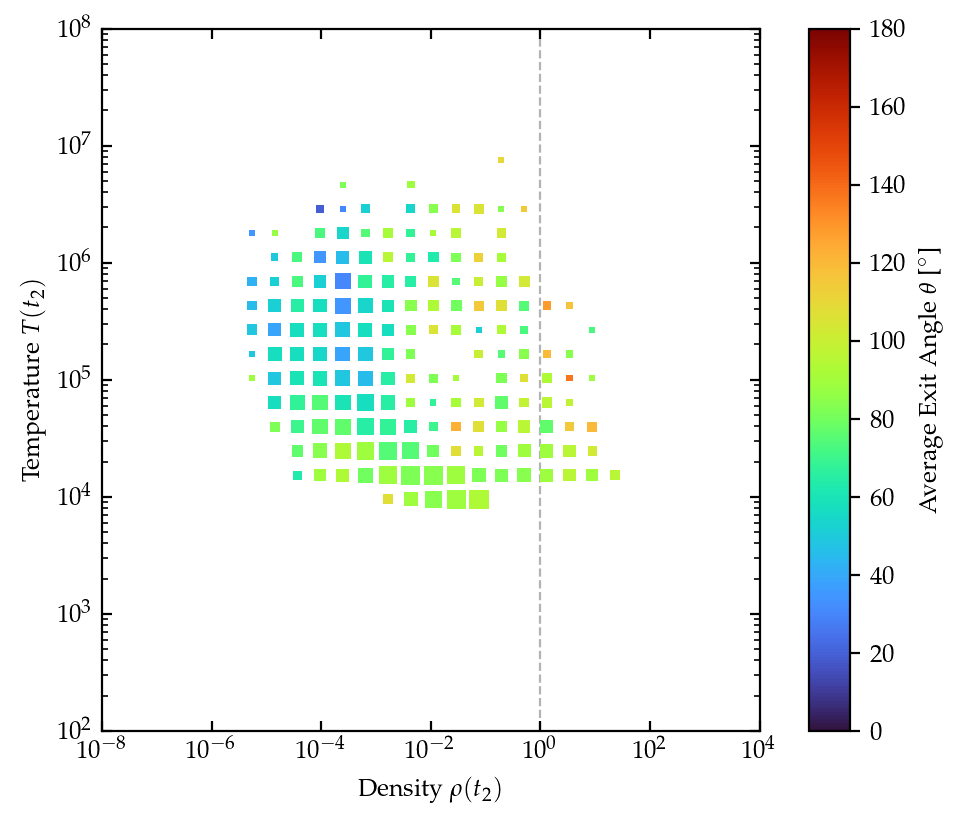

In [99]:
import scipy.stats

fig, ax = plt.subplots(1,1, figsize=(4.7,4), dpi=200, sharey=True, constrained_layout=True)

x = np.array(just_left2.rho)
y = np.array(just_left2.temp)
c = np.digitize(angles2, bins=bins)


xmin,xmax = 1e-8,1e4
ymin,ymax = 1e2,1e8

xbins = 10**np.linspace(np.log10(xmin),np.log10(xmax), 30)
ybins = 10**np.linspace(np.log10(ymin),np.log10(ymax), 30)

scale = 50

num, xedges, yedges = np.histogram2d(x, y, bins=[xbins, ybins])
mean, xedges, yedges, binnumbers = scipy.stats.binned_statistic_2d(x, y, c, statistic='mean', bins=[xbins, ybins])
xcenters = 0.5*(xedges[1:]+xedges[:-1])
ycenters = 0.5*(yedges[1:]+yedges[:-1])
newx, newy, s, m = np.array([]), np.array([]), np.array([]), np.array([])
for x in range(len(xcenters)):
    for y in range(len(ycenters)):
        s = np.append(s, num[x,y])
        m = np.append(m, mean[x,y])
        newx = np.append(newx, xcenters[x])
        newy = np.append(newy, ycenters[y])
s_scaled = np.log10(s)/np.log10(s.max()) * scale


newm = []
for i in m:
    if np.isnan(i):
        newm.append(i)
    else:
        newm.append(bincenters[int(round(i,0))-1])

im = ax.scatter(newx, newy, c=newm, linewidths=0., cmap='turbo', vmin=0, vmax=180, s=s_scaled, marker='s')
cbar = fig.colorbar(im, ax=ax, label=r'Average Exit Angle $\theta$ [$^\circ$]')

plt.plot([1e-10, 1e10], [1,1], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)
plt.plot([1,1], [1e-10, 1e10], color='0.7', linestyle='--', linewidth=0.8, zorder=-1)

ax.set_xlim(xmin,xmax)
ax.set_xlabel(r'Density $\rho(t_2)$')

ax.set_ylim(ymin,ymax)
ax.set_ylabel(r'Temperature $T(t_2)$')
# ax.set_aspect('equal')

ax.loglog()
# ax.legend(frameon=False)
ax.tick_params(direction='in',which='both',top=True,right=True)


plt.show()


In [74]:
s_scaled

array([       -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,        -inf,
              -inf,        -inf,        -inf,        -inf,      

In [243]:
cond = np.array(prior_to_leaving2.coolontime > prior_to_leaving2.time)
np.array(just_left2.temp/prior_to_leaving2.temp)

array([ 6.0639922 , 92.58289303,  1.89912656, ...,         nan,
               nan,         nan])

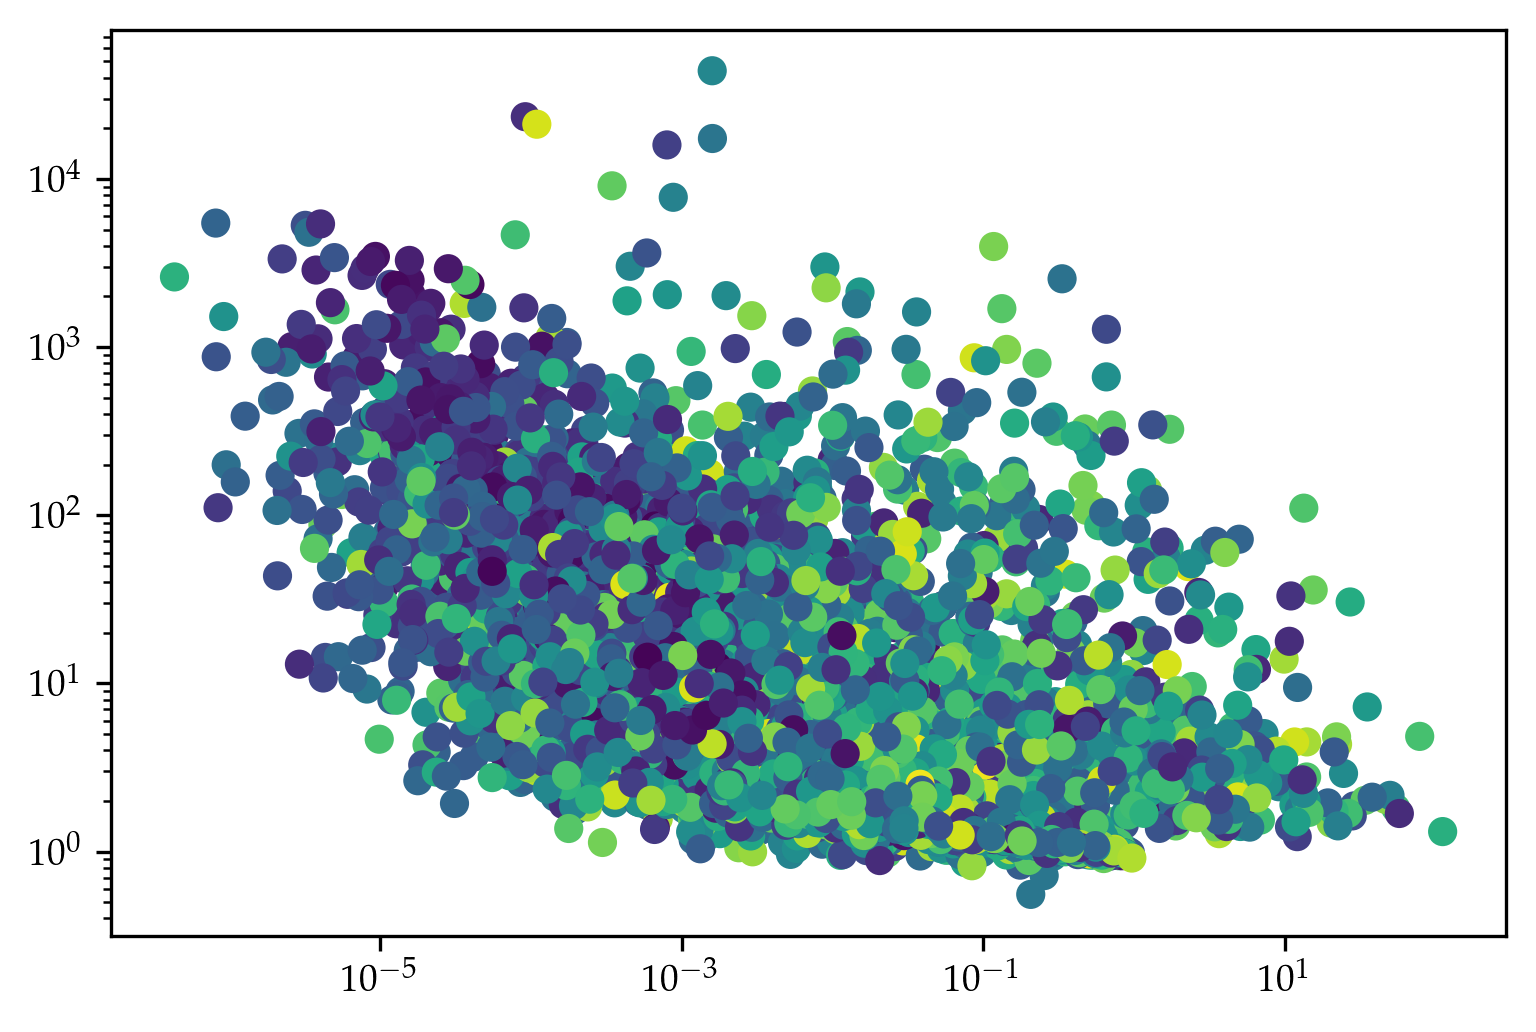

In [50]:
plt.figure(dpi=300)
x = np.array(just_left2.rho)/np.array(prior_to_leaving2.rho)
y = np.array(just_left2.temp)/np.array(prior_to_leaving2.temp)
c = angles2
plt.scatter(x,y,c=angles2)
plt.loglog()
plt.show()

In [19]:
len(just_left1.temp)

13938

In [21]:
len(prior_to_leaving1.temp)

13938

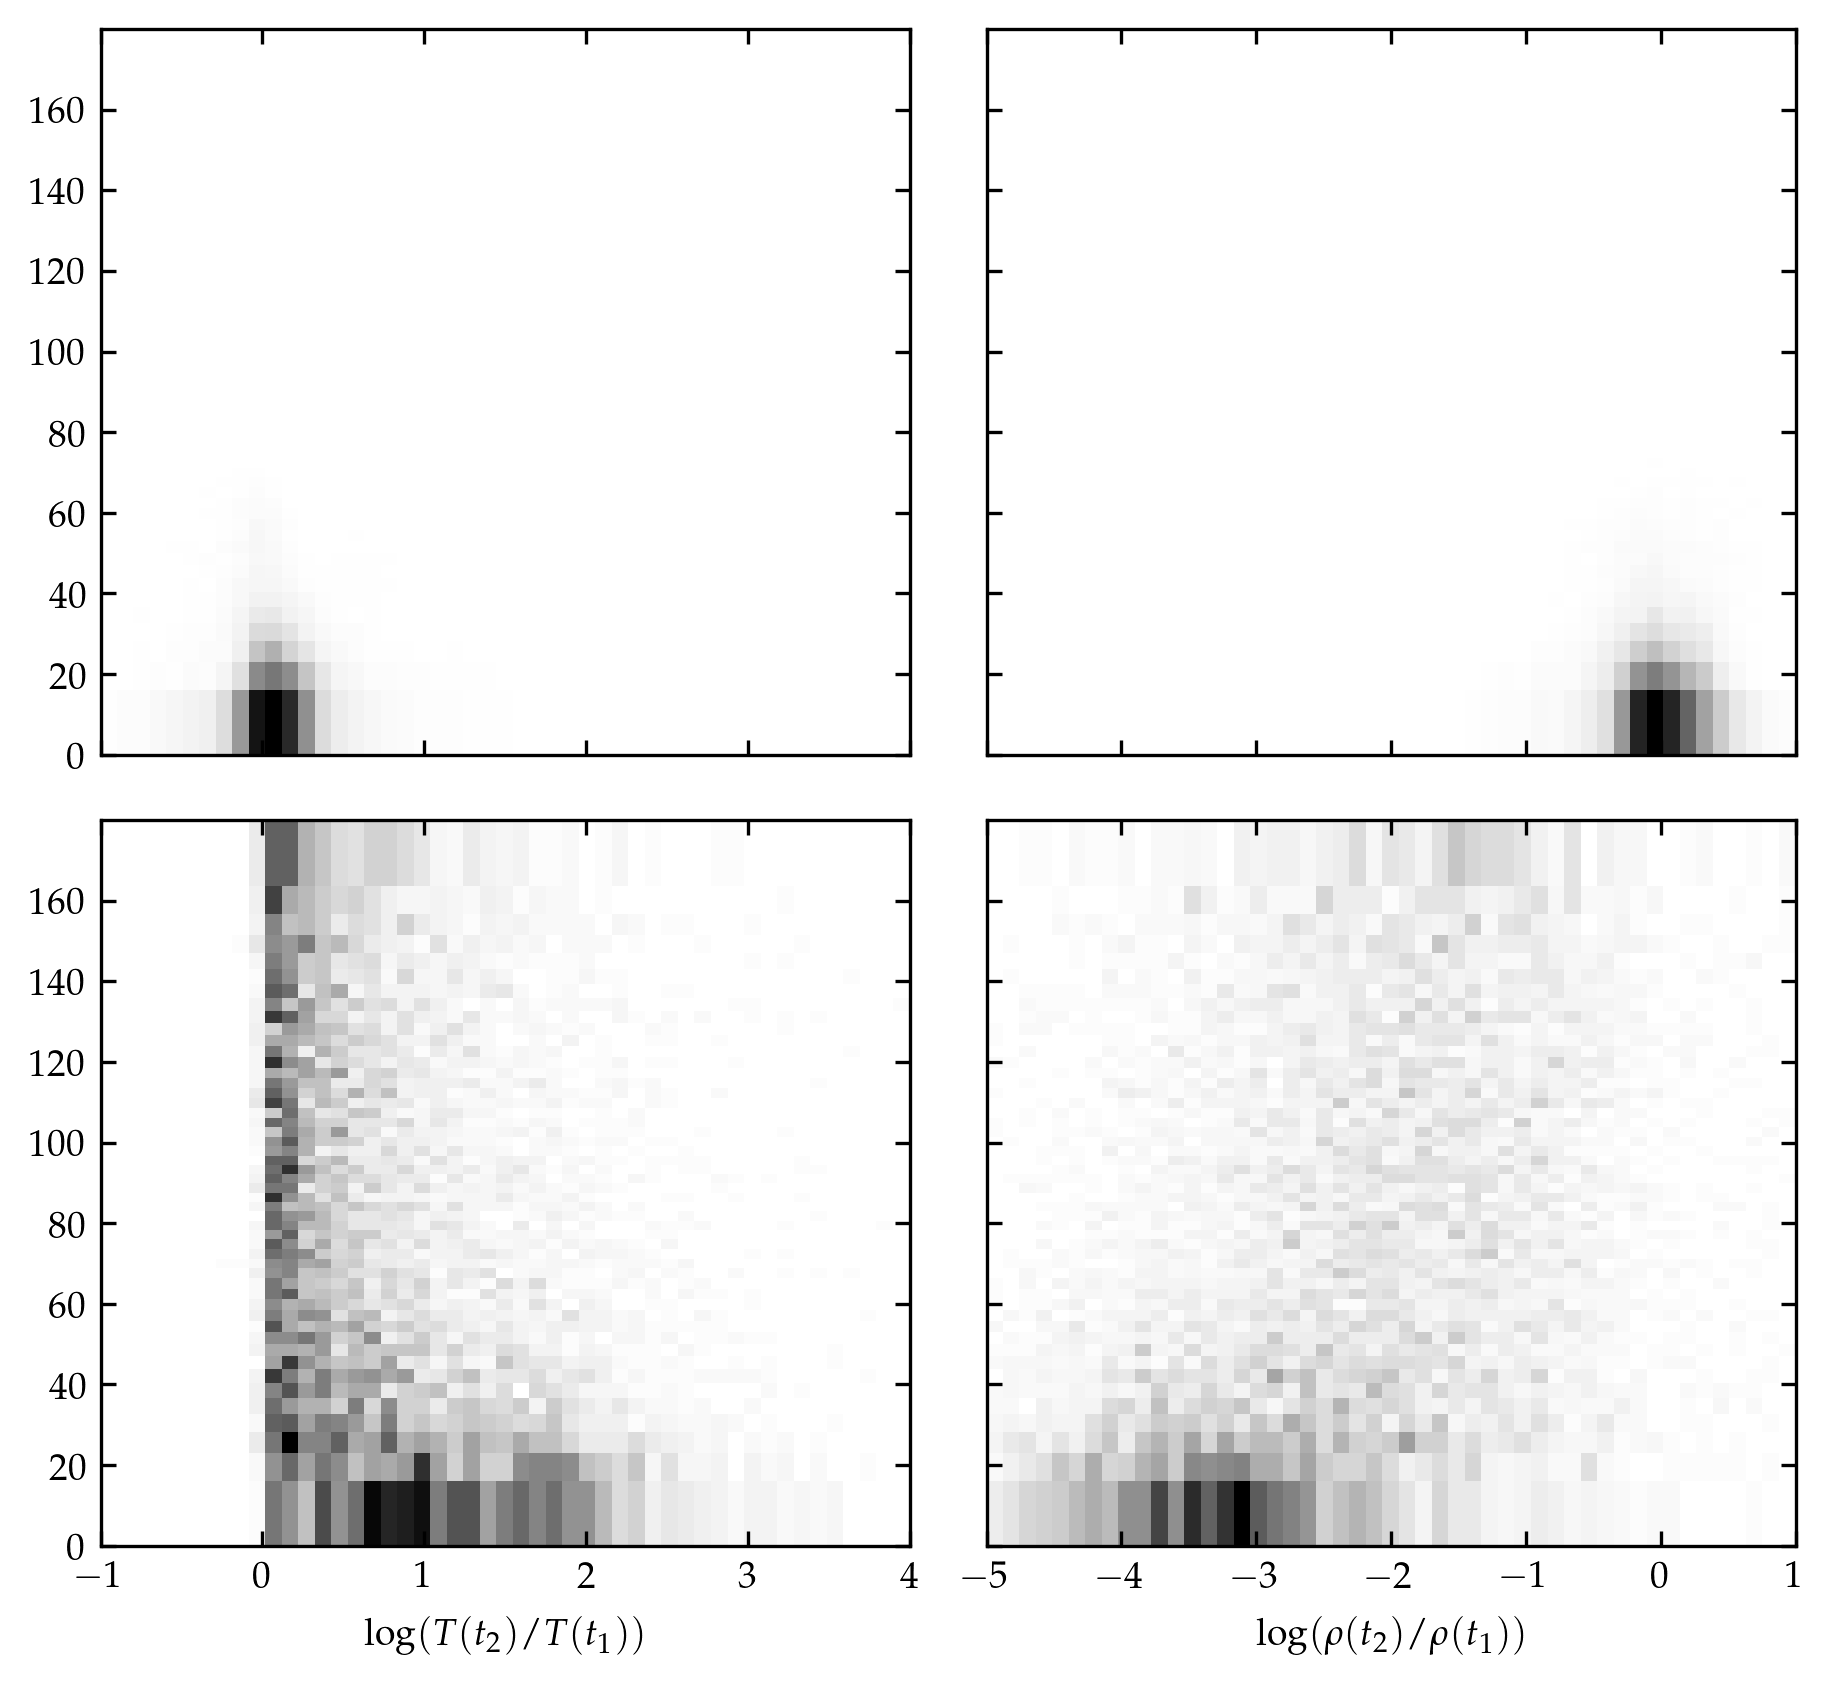

In [103]:
ybins = bins
xbins = np.linspace(-1,4,50)
cmap = 'Greys'



fig, ax = plt.subplots(2,2, figsize=(6,5.5), dpi=300, sharey=True, constrained_layout=True)

x = np.log10(np.array(just_left1.temp)/np.array(prior_to_leaving1.temp))
y = angles1
ax[0,0].hist2d(x,y, bins=[xbins,ybins], cmap=cmap)


x = np.log10(np.array(just_left2.temp)/np.array(prior_to_leaving2.temp))
y = angles2
ax[1,0].hist2d(x,y, bins=[xbins,ybins], cmap=cmap)


xbins = np.linspace(-5,1,50)

x = np.log10(np.array(just_left1.rho)/np.array(prior_to_leaving1.rho))
y = angles1
ax[0,1].hist2d(x,y, bins=[xbins,ybins], cmap=cmap)


x = np.log10(np.array(just_left2.rho)/np.array(prior_to_leaving2.rho))
y = angles2
ax[1,1].hist2d(x,y, bins=[xbins,ybins], cmap=cmap)

ax[0,0].tick_params(labelbottom=False)
ax[0,1].tick_params(labelbottom=False)

for a in ax.flatten():
    a.tick_params(top=True, right=True, direction='in', which='both')
    
ax[1,0].set_xlabel(r'$\log(T(t_2)/T(t_1))$')
ax[1,1].set_xlabel(r'$\log(\rho(t_2)/\rho(t_1))$')

plt.show()

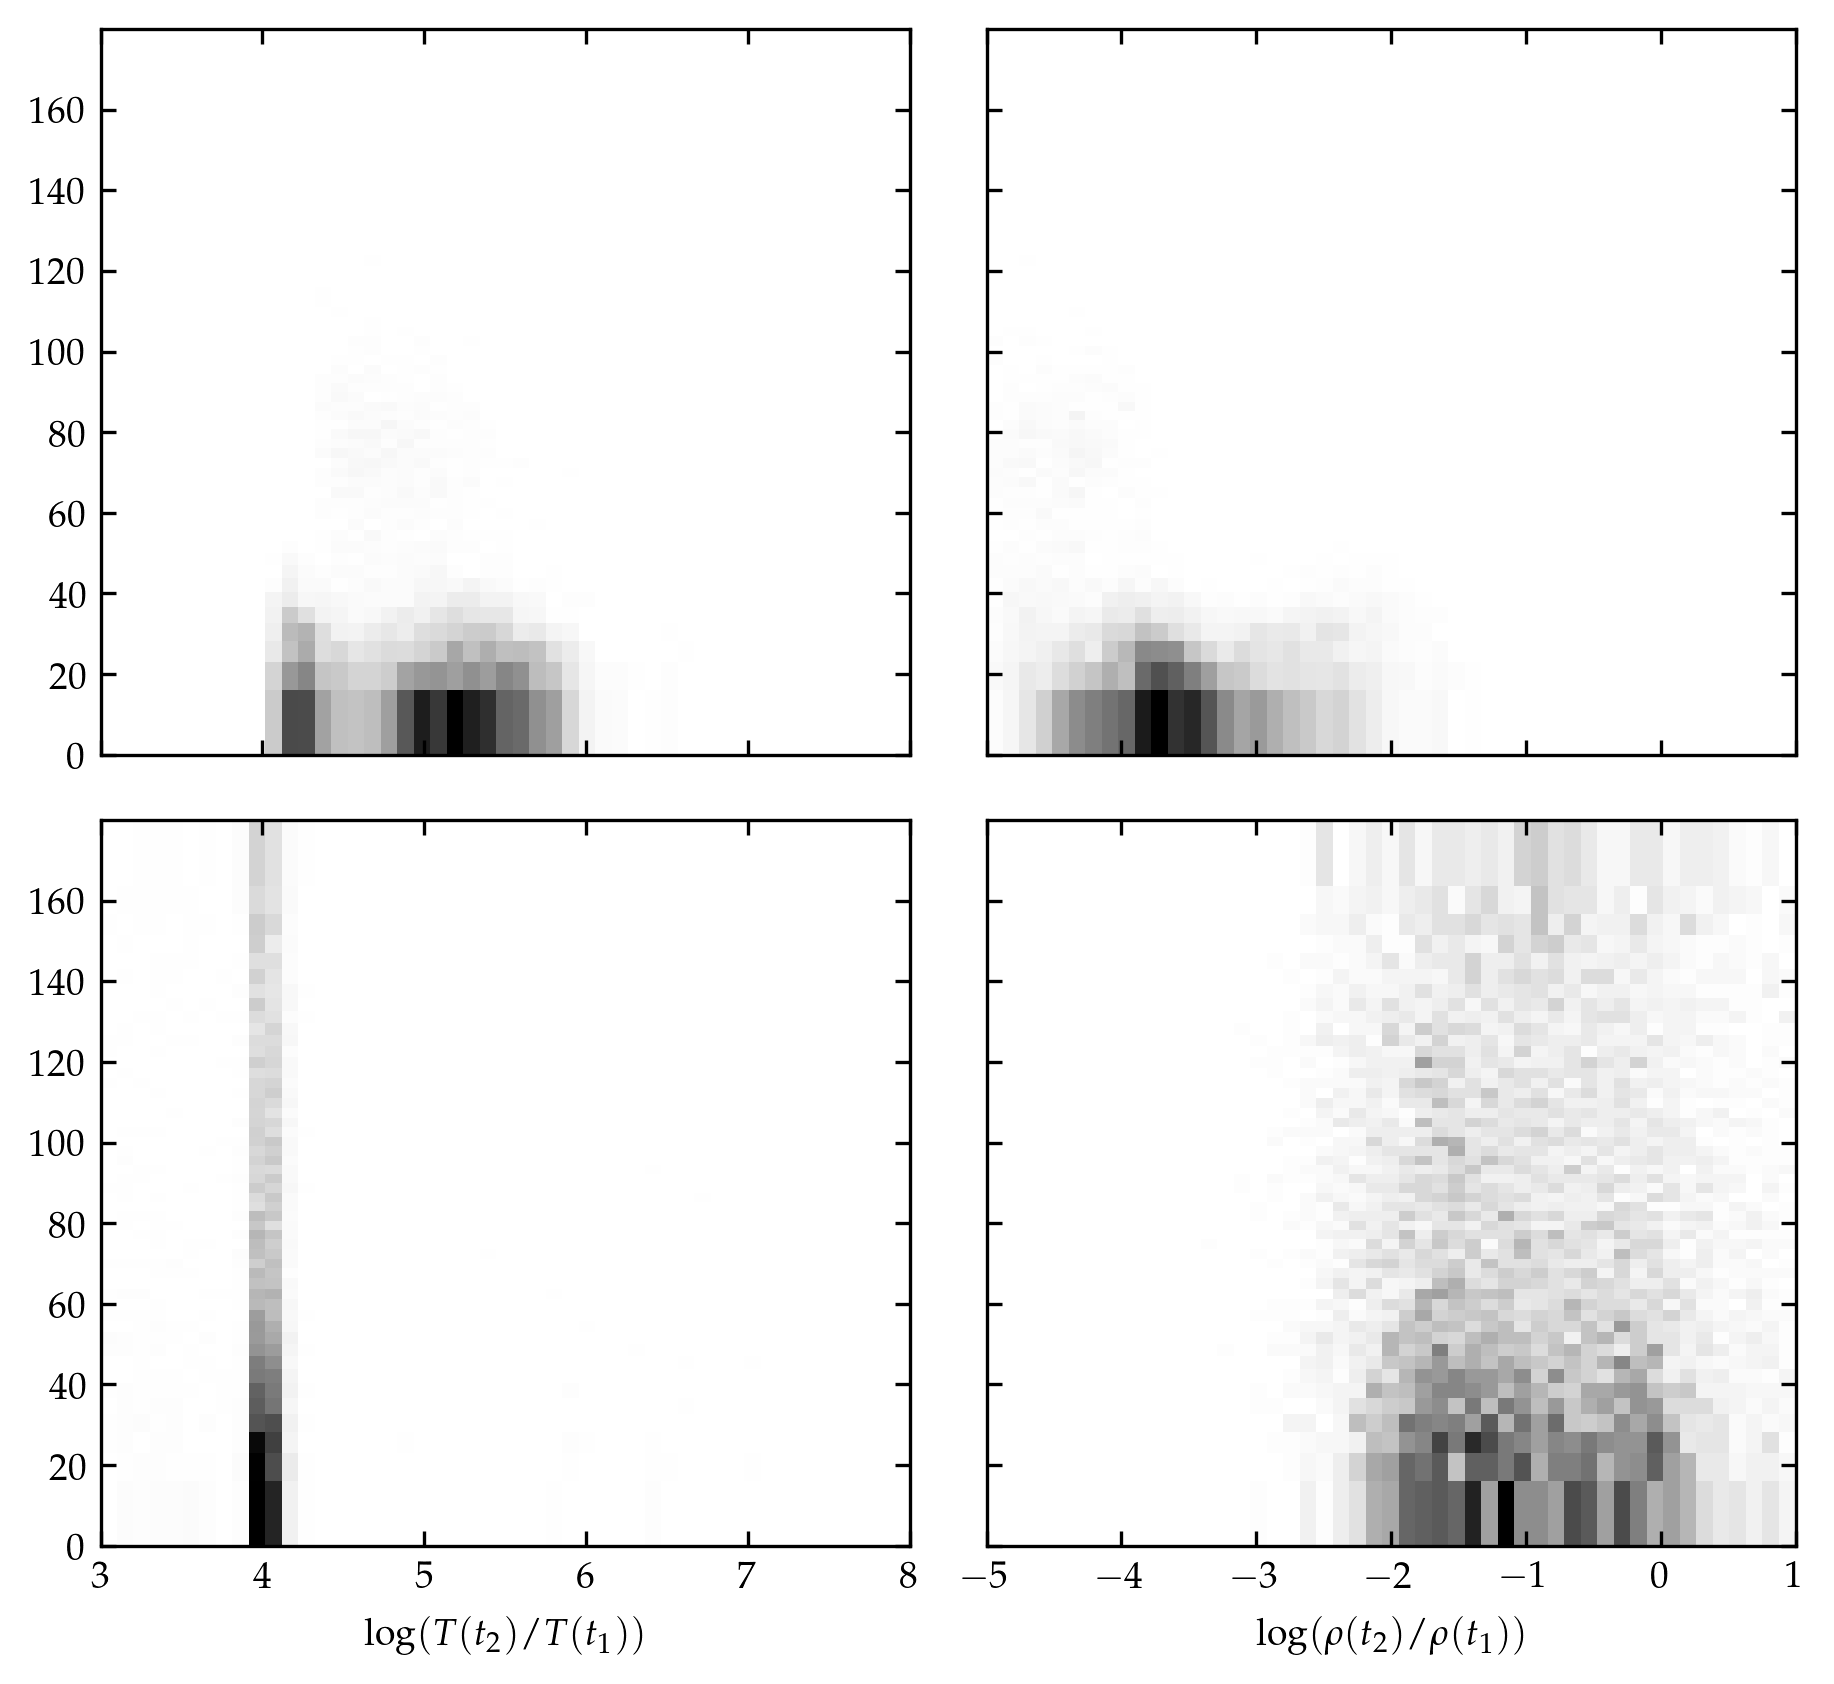

In [99]:
ybins = bins
xbins = np.linspace(3,8,50)
cmap = 'Greys'



fig, ax = plt.subplots(2,2, figsize=(6,5.5), dpi=300, sharey=True, constrained_layout=True)

x = np.log10(np.array(prior_to_leaving1.temp))
y = angles1
ax[0,0].hist2d(x,y, bins=[xbins,ybins], cmap=cmap)


x = np.log10(np.array(prior_to_leaving2.temp))
y = angles2
ax[1,0].hist2d(x,y, bins=[xbins,ybins], cmap=cmap)


xbins = np.linspace(-5,1,50)

x = np.log10(np.array(prior_to_leaving1.rho))
y = angles1
ax[0,1].hist2d(x,y, bins=[xbins,ybins], cmap=cmap)


x = np.log10(np.array(prior_to_leaving2.rho))
y = angles2
ax[1,1].hist2d(x,y, bins=[xbins,ybins], cmap=cmap)

ax[0,0].tick_params(labelbottom=False)
ax[0,1].tick_params(labelbottom=False)

for a in ax.flatten():
    a.tick_params(top=True, right=True, direction='in', which='both')
    
ax[1,0].set_xlabel(r'$\log(T(t_2)/T(t_1))$')
ax[1,1].set_xlabel(r'$\log(\rho(t_2)/\rho(t_1))$')

plt.show()

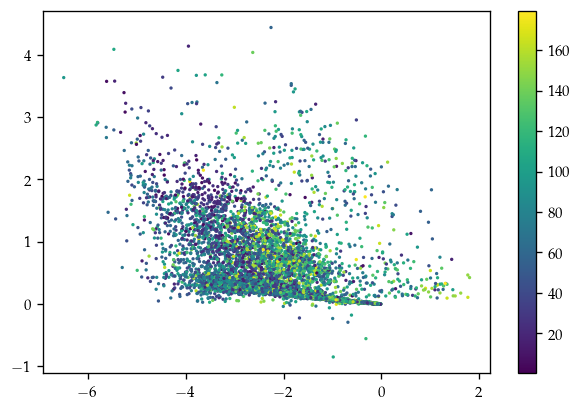

In [84]:
y = np.log10(np.array(just_left2.temp)/np.array(prior_to_leaving2.temp))
x = np.log10(np.array(just_left2.rho)/np.array(prior_to_leaving2.rho))
c = angles2

plt.figure(dpi=120)
plt.scatter(x,y, c=c, s=1)
plt.colorbar()
plt.show()

## Scaling up to multiple satellites

In [127]:
keys = ['h242_24', 'h148_13', 'h148_28', 'h148_37', 'h148_68', 'h229_20', 'h229_22', 'h242_80']
path = '../../Data/tracked_particles.hdf5'

data = pd.DataFrame()

for key in keys:
    d = pd.read_hdf(path, key=key)
    d['key'] = key
    data = pd.concat([data,d])

# Temporary code to fix classification issue 
# (forgot to exclude disk particles from the halo in particletracking.py, so some were being classified in both)

data = data.rename(columns={'sat_disk': 'sat_disk_wrong',
                            'host_disk': 'host_disk_wrong',
                            'sat_halo': 'sat_halo_wrong',
                            'host_halo': 'host_halo_wrong'})

data['sat_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r <= 3)
data['sat_halo'] = (data.r_per_Rvir < 1) & ~data.sat_disk
data['host_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r_per_Rvir > 1) & (data.h1dist < 0.1)
data['host_halo'] = (data.r_per_Rvir > 1) & (data.h1dist < 1) & ~data.host_disk

data

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,sat_halo_wrong,IGM,host_halo_wrong,host_disk_wrong,classification,key,sat_disk,sat_halo,host_disk,host_halo
0,5.181190,811077,0.000037,5.369499e+05,26510.536704,0.000000,317.229043,5.719189,-173.390813,23.552462,...,False,False,True,False,4.0,h242_24,False,False,False,True
1,5.181190,6872943,0.000560,1.621470e+06,33820.435130,4.999814,305.111904,5.500734,-149.748558,152.158116,...,False,False,True,False,4.0,h242_24,False,False,False,True
2,5.181190,8840402,0.000179,6.317682e+04,26510.536704,0.000000,352.882340,6.361967,133.276947,199.077824,...,False,True,False,False,5.0,h242_24,False,False,False,False
3,5.181190,8987571,0.000017,2.664518e+05,26510.536704,0.000000,26.778647,0.482781,-9.585453,-3.929157,...,True,False,False,False,2.0,h242_24,False,True,False,False
4,5.181190,9655109,0.000078,1.011527e+05,26510.536704,0.000000,16.040076,0.289180,-2.434631,-11.577726,...,True,False,False,False,2.0,h242_24,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12737,13.800797,10298301,0.056452,5.618703e+03,28948.967330,13.774364,135.163190,4.521191,-85.458108,-4.623048,...,False,False,True,False,4.0,h242_80,False,False,False,True
12738,13.800797,10308180,0.000792,1.401448e+04,26525.756840,0.000000,26.956771,0.901700,-8.969144,-2.847575,...,True,False,False,False,2.0,h242_80,False,True,False,False
12739,13.800797,10415354,0.166512,5.064715e+03,26714.441286,13.602646,131.291563,4.391685,-51.422925,-36.670975,...,False,False,True,False,4.0,h242_80,False,False,False,True
12740,13.800797,10533119,0.002758,2.248430e+06,27211.947879,13.756687,134.156683,4.487523,-81.826323,-4.631989,...,False,False,True,False,4.0,h242_80,False,False,False,True


In [138]:
import tqdm

just_left1 = pd.DataFrame()
just_left2 = pd.DataFrame()

for key in keys:
    dat1 = data[data.key==key]
    pids = np.unique(dat1.pid)
    for pid in tqdm.tqdm(pids):
        dat = dat1[dat1.pid==pid]

        sat_disk = np.array(dat.sat_disk, dtype=bool)
        sat_halo = np.array(dat.sat_halo, dtype=bool)
        host_halo = np.array(dat.host_halo,dtype=bool)
        time = np.array(dat.time,dtype=float)

        assert len(sat_disk) == len(sat_halo) == len(host_halo) == len(time)

        for t,sh1,hh2,sd1,sh2 in zip(time[1:], sat_halo[:-1], host_halo[1:], sat_disk[:-1], sat_halo[1:]):
            if sh1 and hh2:
                just_left1 = pd.concat([just_left1,dat[time==t]])
            if sd1 and sh2:
                just_left2 = pd.concat([just_left2,dat[time==t]])

100%|██████████| 12766/12766 [29:04<00:00,  7.32it/s]


In [141]:
angles1 = np.array([])

for d in tqdm.tqdm(just_left1.iterrows()):
    # get gas particle velocity
    v = np.array([d[1].vx,d[1].vy,d[1].vz])
    
    # get velocity of CGM wind (host velocity relative to satellite)
    v_sat = np.array([d[1].sat_vx,d[1].sat_vy,d[1].sat_vz])
    v_host = np.array([d[1].host_vx,d[1].host_vy,d[1].host_vz])
    v_rel = v_host - v_sat # we want the velocity of the host in the satellite rest frame
    
    # take the dot product and get the angle, in degrees
    v_hat = v / np.linalg.norm(v)
    v_rel_hat = v_rel / np.linalg.norm(v_rel)
    angle = np.arccos(np.dot(v_hat,v_rel_hat)) * 180/np.pi
    angles1 = np.append(angles1,angle)
    
angles2 = np.array([])

for d in tqdm.tqdm(just_left2.iterrows()):
    v = np.array([d[1].vx,d[1].vy,d[1].vz])
    
    v_sat = np.array([d[1].sat_vx,d[1].sat_vy,d[1].sat_vz])
    v_host = np.array([d[1].host_vx,d[1].host_vy,d[1].host_vz])
    v_rel = v_host - v_sat 
    
    v_hat = v / np.linalg.norm(v)
    v_rel_hat = v_rel / np.linalg.norm(v_rel)
    angle = np.arccos(np.dot(v_hat,v_rel_hat)) * 180/np.pi
    angles2 = np.append(angles2,angle)

172878it [00:33, 5138.85it/s]
194555it [00:39, 4879.05it/s]


In [142]:
N = 50 # more bins than Bahé et al since we have lots of particles
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

In [173]:
mass1 = np.array(just_left1.mass)
weights1 = mass1/mass1.sum()

mass2 = np.array(just_left2.mass)
weights2 = mass2/mass2.sum()

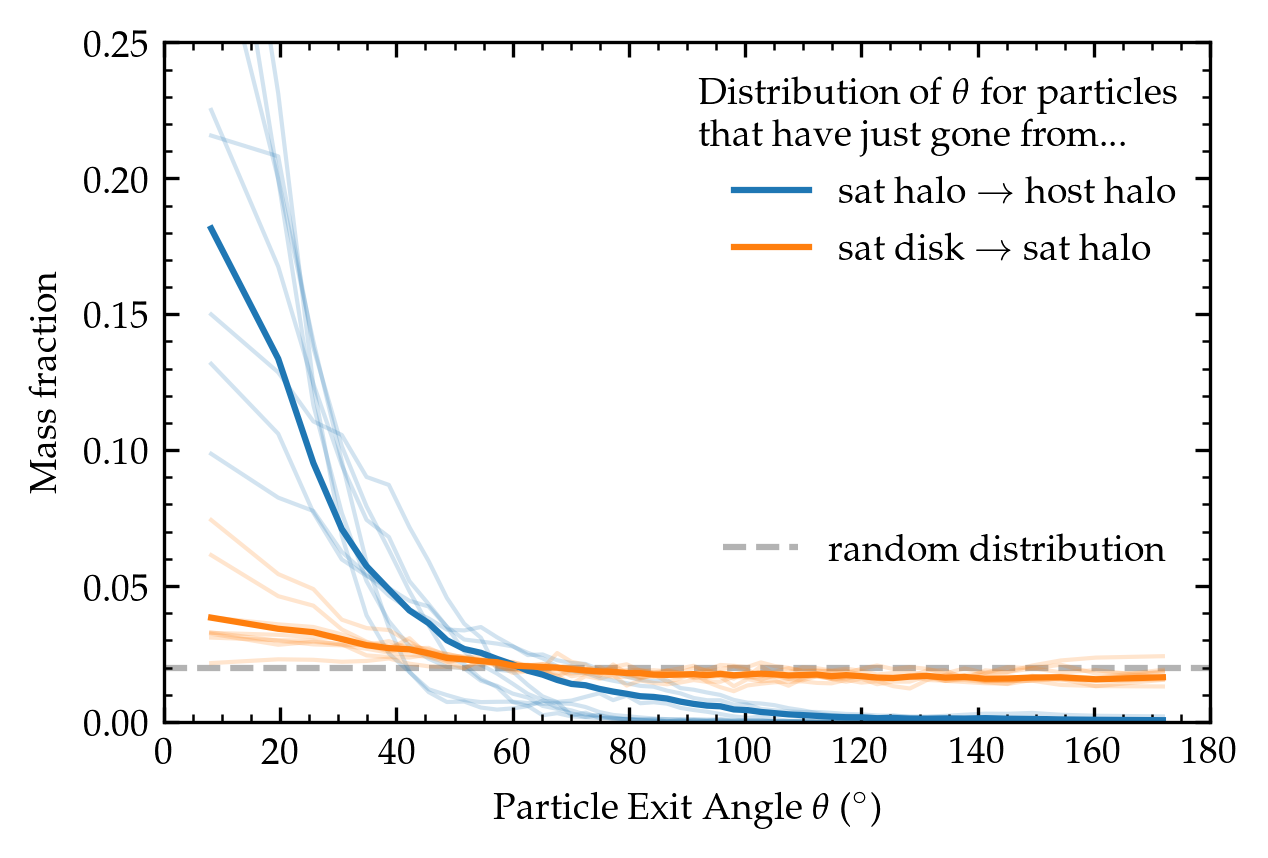

In [200]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3))

# plot the two distributions
y1, bins = np.histogram(angles1, bins=bins, weights=weights1)
l1 = r'sat halo $\to$ host halo'
p1, = ax.plot(bincenters, y1, label=l1)
y2, bins = np.histogram(angles2, bins=bins, weights=weights2)
l2 = r'sat disk $\to$ sat halo'
p2, = ax.plot(bincenters, y2, label=l2)


for key in keys:
    cond = just_left1.key == key
    mass = np.array(just_left1.mass)[cond]
    weights = mass/mass.sum()
    y1, bins = np.histogram(angles1[cond], bins=bins, weights=weights)
    ax.plot(bincenters, y1, color='tab:blue', alpha=0.2, zorder=0, linewidth=1)
    
for key in keys:
    cond = just_left2.key == key
    mass = np.array(just_left2.mass)[cond]
    weights = mass/mass.sum()
    y2, bins = np.histogram(angles2[cond], bins=bins, weights=weights)
    ax.plot(bincenters, y2, color='tab:orange', alpha=0.2, zorder=0, linewidth=1)

# plot the line that represents a random distribution
percent = 1/N
p3, = ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)

# add legends
leg1 = ax.legend([p1,p2],[l1,l2],title=r'Distribution of $\theta$ for'+' particles\n that have just gone from...', frameon=False)
leg1._legend_box.align = 'right'
leg2 = ax.legend([p3],['random distribution'], frameon=False, loc=(0.52,0.2))
ax.add_artist(leg1)

# labels and ticks and such
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Mass fraction')
ax.set_xlim(0,180)
ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('plots/theta_allsats.pdf')
plt.show()

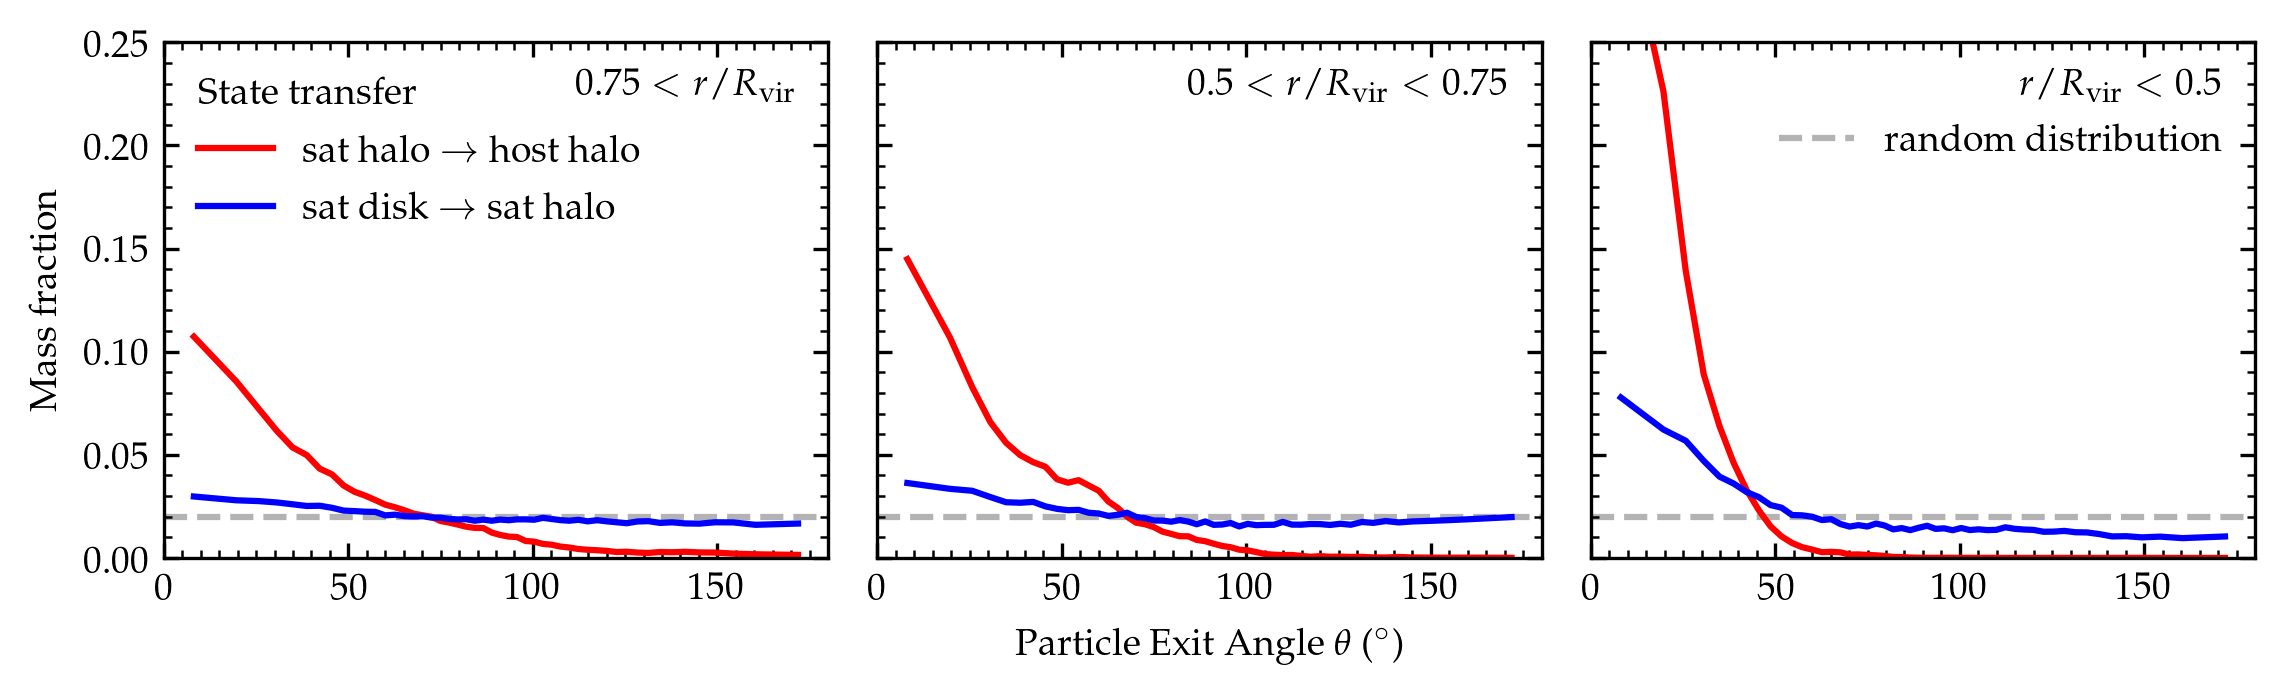

In [201]:
sat_pos = np.array([np.array(just_left1.sat_Xc), np.array(just_left1.sat_Yc), np.array(just_left1.sat_Zc)]).T
host_pos = np.array([np.array(just_left1.host_Xc), np.array(just_left1.host_Yc), np.array(just_left1.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag1 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag1 /= np.array(just_left1.h1Rvir)

sat_pos = np.array([np.array(just_left2.sat_Xc), np.array(just_left2.sat_Yc), np.array(just_left2.sat_Zc)]).T
host_pos = np.array([np.array(just_left2.host_Xc), np.array(just_left2.host_Yc), np.array(just_left2.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag2 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag2 /= np.array(just_left2.h1Rvir)


fig,ax = plt.subplots(1,3, dpi=300, figsize=(7.5,2.2), sharey=True, constrained_layout=True)

# leftmost ax will be r > 0.75
ax[0].annotate(r'$0.75 < r/R_{\rm vir}$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = pos_mag1 >= 0.75
y1, bins = np.histogram(angles1[cond], bins=bins, weights=mass1[cond]/np.sum(mass1[cond]))
l1 = r'sat halo $\to$ host halo'
ax[0].plot(bincenters, y1, label=l1, color='r')

cond = pos_mag2 > 0.75
y2, bins = np.histogram(angles2[cond], bins=bins, weights=mass2[cond]/np.sum(mass2[cond]))
l2 = r'sat disk $\to$ sat halo'
ax[0].plot(bincenters, y2, label=l2, color='b')


# middle ax will be 0.5 < r < 0.75
ax[1].annotate(r'$0.5 < r/R_{\rm vir} < 0.75$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = (pos_mag1 >= 0.5) & (pos_mag1 < 0.75)
y1, bins = np.histogram(angles1[cond], bins=bins, weights=mass1[cond]/np.sum(mass1[cond]))
ax[1].plot(bincenters, y1, color='r')

cond = (pos_mag2 >= 0.5) & (pos_mag2 < 0.75)
y2, bins = np.histogram(angles2[cond], bins=bins, weights=mass2[cond]/np.sum(mass2[cond]))
ax[1].plot(bincenters, y2, color='b')


# rightmost ax will be r < 0.5
ax[2].annotate(r'$r/R_{\rm vir} < 0.5$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = pos_mag1 < 0.5
y1, bins = np.histogram(angles1[cond], bins=bins, weights=mass1[cond]/np.sum(mass1[cond]))
ax[2].plot(bincenters, y1, color='r')

cond = pos_mag2 < 0.5
y2, bins = np.histogram(angles2[cond], bins=bins, weights=mass2[cond]/np.sum(mass2[cond]))
ax[2].plot(bincenters, y2, color='b')


# plot the line that represents a random distribution
percent = 1/N
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[2].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='random distribution')

# add legends
leg1 = ax[0].legend(title=r'State transfer', frameon=False, loc='upper left')
leg1._legend_box.align = 'left'
ax[2].legend(frameon=False, loc=(0.26,0.74))

# labels and ticks and such
ax[1].set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax[0].set_ylabel('Mass fraction')
for a in ax:
    a.set_xlim(0,180)
    a.set_ylim(0,0.25)

    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
    a.tick_params(direction='in',which='both',right=True,top=True)

# plt.savefig('plots/theta_allsats_byR.pdf')
plt.show()

Dominated by one satellite?

Mass effect? Lower mass galaxies will have weaker restoring forces, will we see more stripping of disk gas?

Higher mass satellites, disk gas is protected from RPS for larger fractions of the orbit. 

Distinct effect from potential well vs. gas reservoir

Set up a separate script to calculate ram pressure as a function of time.

Tracking stars as well?

Other things to look at: 
temperature/density of gas as it is lost? 

to distinguish between the processes affecting the disk

*feedback*: start of at high density, low temperature and then high temperature/high density after removal

RPS: high temperature, low density gas is most easily removed

tidal stripping should have no affect or preference on temperature, might affect the density

*make orbit plots with gas temperature and density, looking at ram pressure over time and comparing to orbital dynamics*

spherically averaged density profile vs. local CGM density

more robust way: picking up gas that is leaving the satellite? 
maybe do it only for gas particles that have not yet been in the satellite? 

need to do a comparison between these two methods

In [26]:
pd.read_hdf('../../Data/ejected_particles.hdf5', key='h229_20')

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,K,U,ratio,cool_disk,hot_disk,cool_halo,hot_halo,CGM,state1,angle
71544,8.608831,975088,0.000116,33267.402344,26592.766544,0.0,12.991873,0.383907,-6.482302,-7.503606,...,1.008880e+44,2.442687e+42,41.302069,False,False,False,True,False,hot disk,72.860759
98374,9.383249,1155002,0.000594,20711.935547,26510.536704,0.0,9.312866,0.268513,-7.817292,-0.054865,...,5.995459e+42,2.611073e+42,2.296166,False,False,False,True,False,hot disk,71.870363
116260,10.029719,1155002,0.000471,21645.367188,26510.536704,0.0,8.796327,0.250547,-7.091941,-5.203083,...,2.527772e+43,2.196080e+42,11.510385,False,False,False,True,False,hot disk,108.160118
143089,10.767100,1155002,0.001077,15319.998047,26510.536704,0.0,5.138809,0.142676,4.310928,-1.573167,...,4.705663e+42,2.899006e+42,1.623199,False,False,False,True,False,hot disk,167.367557
160974,11.322660,1155002,0.000827,22052.873047,26510.536704,0.0,4.541622,0.122700,2.309376,3.429021,...,7.661343e+42,2.758791e+42,2.777065,False,False,False,True,False,hot disk,53.688764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35768,7.120602,11155099,0.000343,54110.644531,26511.654079,0.0,9.753234,0.332823,5.348653,-2.614360,...,7.575049e+42,3.314847e+42,2.285188,False,False,False,True,False,hot disk,80.339935
143085,10.676190,11155112,0.000505,17185.449219,26616.392037,0.0,5.284029,0.147187,-2.918177,-4.397947,...,4.433038e+42,2.904556e+42,1.526236,False,False,False,True,False,cool disk,124.063069
205668,12.292366,11155112,0.000405,17403.199219,26616.392037,0.0,6.474071,0.165471,2.694308,5.226835,...,4.803162e+43,1.571987e+42,30.554725,False,False,False,True,False,hot disk,115.401389
62599,8.090307,11155120,0.000333,27866.890625,26510.536704,0.0,13.872408,0.425907,-5.707792,-6.095501,...,5.385837e+42,2.722344e+42,1.978382,False,False,False,True,False,hot disk,135.524091


In [14]:
ejected, cooled, expelled, accreted = read_ejected_expelled('h148',68)

Returning (ejected, cooled, expelled, accreted) for h148-68...


In [15]:
ejected.head()

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,angle,angle_tidal
2,9.921974,1274232,0.014496,12363.898438,27512.392303,8.988137,2.613642,0.076467,1.055830,1.901123,...,0.858923,20.680841,False,True,False,False,False,False,38.649036,70.175135
20,9.490994,2015967,0.011167,12892.569336,26554.675618,0.000000,6.252593,0.194709,-4.479509,4.213721,...,0.972404,18.539079,False,True,False,False,False,False,30.139505,60.381517
22,10.352954,2016219,0.037235,11034.901367,26635.131819,9.833260,1.485281,0.042876,0.101484,1.129554,...,0.902321,19.590469,False,True,False,False,False,False,132.318091,178.461611
27,9.490994,2016971,0.047780,11107.617188,26531.219372,0.000000,1.901776,0.059222,-1.551170,0.502463,...,0.972404,18.539079,False,True,False,False,False,False,123.097028,70.088318
30,9.490994,2016985,0.051126,11085.542969,26537.721564,9.093356,2.112979,0.065799,-0.905954,1.908907,...,0.972404,18.539079,False,True,False,False,False,False,67.467803,16.857477


In [16]:
N = 50 # more bins than Bahé et al since we have lots of particles
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])
print(bins)

[  0.          16.26020471  23.07391807  28.35763658  32.85988038
  36.86989765  40.53580211  43.94551956  47.15635696  50.2081805
  53.13010235  55.94420226  58.6677485   61.31459799  63.89611886
  66.42182152  68.89980398  71.33707512  73.73979529  76.11345964
  78.46304097  80.79310378  83.10789742  85.41143426  87.70755722
  90.          92.29244278  94.58856574  96.89210258  99.20689622
 101.53695903 103.88654036 106.26020471 108.66292488 111.10019602
 113.57817848 116.10388114 118.68540201 121.3322515  124.05579774
 126.86989765 129.7918195  132.84364304 136.05448044 139.46419789
 143.13010235 147.14011962 151.64236342 156.92608193 163.73979529
 179.99999774]


In [17]:
ejected['weight'] = ejected['mass'] / ejected['mass'].sum()
expelled['weight'] = expelled['mass'] / expelled['mass'].sum()

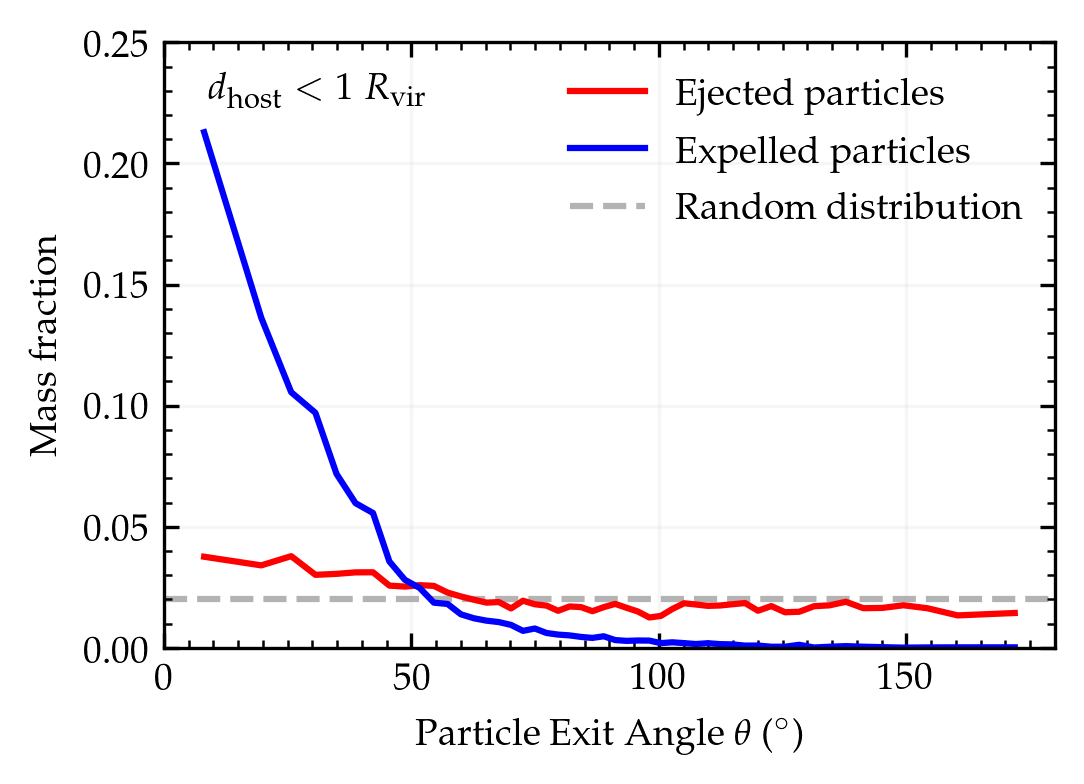

In [18]:
sat_pos = np.array([np.array(ejected.sat_Xc), np.array(ejected.sat_Yc), np.array(ejected.sat_Zc)]).T
host_pos = np.array([np.array(ejected.host_Xc), np.array(ejected.host_Yc), np.array(ejected.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag1 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag1 /= np.array(ejected.hostRvir)

sat_pos = np.array([np.array(expelled.sat_Xc), np.array(expelled.sat_Yc), np.array(expelled.sat_Zc)]).T
host_pos = np.array([np.array(expelled.host_Xc), np.array(expelled.host_Yc), np.array(expelled.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag2 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag2 /= np.array(expelled.hostRvir)

fig, ax = plt.subplots(1,1,dpi=300, figsize=(3.5,2.5), constrained_layout=True)

cond = pos_mag1 < 1
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=ejected.mass[cond]/np.sum(ejected.mass[cond]))
ax.plot(bincenters, y1, label='Ejected particles', c='r')

cond = pos_mag2 < 1
y2, bins = np.histogram(expelled.angle[cond], bins=bins, weights=expelled.mass[cond]/np.sum(expelled.mass[cond]))
ax.plot(bincenters, y2, label='Expelled particles', c='b')

# plot the line that represents a random distribution
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='Random distribution')

# add legends
ax.legend(frameon=False)

# labels and ticks and such
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Mass fraction')
ax.set_xlim(0,180)
ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.1, zorder=-1000)
ax.annotate(r'$d_{\rm host} < 1~R_{\rm vir}$', (0.05, 0.95), xycoords='axes fraction', va='top')

# plt.savefig('plots/theta_allsats_stacked.pdf')
plt.show()